In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Chargement des données 
print("=== CHARGEMENT DES DONNEES ===\n")
df = pd.read_excel('base_SNI.xlsx', sheet_name=1)  

print(f"Donnees chargees depuis: base_SNI.xlsx (Feuille 2)")
print(f"Dimensions: {df.shape[0]} lignes x {df.shape[1]} colonnes")
print(f"\nApercu des colonnes:")
print(df.columns.tolist())

df.head()

=== CHARGEMENT DES DONNEES ===



Donnees chargees depuis: base_SNI.xlsx (Feuille 2)
Dimensions: 5752 lignes x 29 colonnes

Apercu des colonnes:
['id_tiers', 'code_client', 'CRD', 'PNU', 'nb_pret', 'Maturite', 'Garantie_max', 'flag_lombard_decouvert', 'DPD 12M', 'Pays de domiciliation', 'Etat civil', 'Nationalité', 'Profession', 'Segmentation commercilale', 'Type de revenu', 'Catégorie sociale', 'Code tribunal', 'Code localité', 'Interdiction cheque', 'Segment', 'date OBSERVATION', 'Age_relation', 'Date_naissance', 'Solde_moyen', 'Revenus_mensuels', 'Solde_arrete', 'Engagement', 'CRD/gar', 'CRD/eng']


,id_tiers,code_client,CRD,PNU,nb_pret,Maturite,Garantie_max,flag_lombard_decouvert,DPD 12M,Pays de domiciliation,...,Segment,date OBSERVATION,Age_relation,Date_naissance,Solde_moyen,Revenus_mensuels,Solde_arrete,Engagement,CRD/gar,CRD/eng
0,10231_2018,10231,3877.51,54792.50,1,-58,109585.0,1,0,France,...,Retail GOLD (08),2018-12-31,154,1963-01-14,NaN,NaN,-3877.510000,54792.50,0.035384,0.070767
1,10231_2019,10231,8087.98,45936.25,1,-59,0.0,1,0,France,...,Retail GOLD (08),2019-12-31,166,1963-01-14,NaN,NaN,-8115.410000,45936.25,1.000000,0.176070
2,10231_2020,10231,11702.36,45000.00,1,-60,0.0,1,0,France,...,Retail GOLD (08),2020-12-31,178,1963-01-15,NaN,NaN,-8115.410000,45000.00,1.000000,0.260052
3,10231_2021,10231,328.53,53085.75,1,-61,0.0,1,0,France,...,Retail GOLD (08),2021-12-31,190,1963-01-15,NaN,NaN,-328.530000,53085.75,1.000000,0.006189
4,10261_2018,10261,1277030.69,0.00,1,18,2475000.0,0,0,Morocco,...,"Private customer, universal (01)",2018-12-31,154,1978-01-10,NaN,NaN,78611.768604,2650000.00,0.515972,0.481898


# SYSTEME DE NOTATION INTERNE (SNI)
## Credit Scoring - Modele de Prediction du Risque de Defaut

---

### Description du Projet
Ce notebook presente le developpement complet d'un **systeme de notation interne (SNI)** pour l'evaluation du risque de credit bancaire, conforme aux exigences reglementaires **Bale II/III**.

### Objectifs
- Identifier les clients a risque de defaut de paiement (DPD > 90 jours)
- Construire un modele de scoring predictif interpretable
- Produire une scorecard utilisable en production

### Methodologie
| Etape | Description |
|:---:|:---|
| **1** | Data Quality Check & Analyse Exploratoire (EDA) |
| **2** | Traitement des Donnees & Encodage WoE |
| **3** | Selection des Variables (Information Value) |
| **4** | Modelisation (Regression Logistique) & Scorecard |

### Source des Donnees
- **Fichier**: `base_SNI.xlsx`
- **Observations**: 5 752 clients bancaires
- **Variables**: 29 caracteristiques (financieres, sociodemographiques, comportementales)

---

# ETAPE 1 : DATA QUALITY CHECK & ANALYSE EXPLORATOIRE

---

## 1.1 Creation de la Variable Cible (`flag_defaut`)

> **Definition Bale II/III** : Un client est considere en **defaut** si son retard de paiement depasse **90 jours** (DPD > 90).

| Etat | Condition | Valeur |
|:---:|:---|:---:|
| Sain | DPD <= 90 jours | 0 |
| Defaut | DPD > 90 jours | 1 |

In [371]:
# Création de la variable cible flag_défaut
df['flag_defaut'] = (df['DPD 12M'] > 90).astype(int)

print("=== VARIABLE CIBLE CRÉÉE ===")
print(f"Distribution de flag_defaut:")
print(df['flag_defaut'].value_counts())
print(f"\nTaux de défaut: {df['flag_defaut'].mean()*100:.2f}%")

=== VARIABLE CIBLE CRÉÉE ===
Distribution de flag_defaut:
flag_defaut
0    5633
1     119
Name: count, dtype: int64

Taux de défaut: 2.07%


## 1.2 Dictionnaire des Variables

> **Description complete** de l'ensemble des variables disponibles dans la base de donnees.

| Variable | Type | Description | Categorie |
|:---------|:----:|:------------|:---------:|
| **id_tiers** | Object | Identifiant unique du client | ID |
| **code_client** | Int | Code numerique du client | ID |
| **CRD** | Float | Capital Restant Du - Montant du credit a rembourser | Finance |
| **PNU** | Float | Part Non Utilisee - Credit disponible non utilise | Finance |
| **nb_pret** | Int | Nombre de prets en cours | Finance |
| **Maturite** | Int | Duree restante du pret (mois) | Finance |
| **Garantie_max** | Float | Montant maximal des garanties | Finance |
| **flag_lombard_decouvert** | Int | Type de credit (0=Standard, 1=Lombard/Decouvert) | Finance |
| **DPD 12M** | Int | Days Past Due - Jours de retard (12 derniers mois) | Risque |
| **Pays de domiciliation** | Object | Pays de residence | Socio |
| **Etat civil** | Object | Statut matrimonial | Socio |
| **Nationalite** | Object | Nationalite du client | Socio |
| **Profession** | Object | Metier/profession | Socio |
| **Segmentation commerciale** | Object | Categorie commerciale banque | Segment |
| **Type de revenu** | Object | Source des revenus | Socio |
| **Categorie sociale** | Object | Classification socio-professionnelle | Socio |
| **Code tribunal** | Object | Juridiction competente | Localisation |
| **Code localite** | Object | Code geographique | Localisation |
| **Interdiction cheque** | Object | Indicateur d'interdiction bancaire | Risque |
| **Segment** | Object | Segment client (Bronze/Silver/Gold/Platinum) | Segment |
| **date OBSERVATION** | Datetime | Date de collecte des donnees | Temporel |
| **Age_relation** | Int | Anciennete relation banque (mois) | Socio |
| **Date_naissance** | Datetime | Date de naissance | Socio |
| **Solde_moyen** | Float | Solde moyen du compte | Finance |
| **Revenus_mensuels** | Float | Revenus mensuels declares | Finance |
| **Solde_arrete** | Float | Solde a la date d'arrete | Finance |
| **Engagement** | Float | Montant total des engagements | Finance |
| **CRD/gar** | Float | Ratio Credit / Garantie | Ratio |
| **CRD/eng** | Float | Ratio Credit / Engagement | Ratio |
| **flag_defaut** | Int | **Variable Cible** (1 si DPD > 90, sinon 0) | Target |

### Legende des Categories
| Code | Categorie | Description |
|:-----:|:----------|:------------|
| ID | Identifiant | Variables d'identification (exclues du modele) |
| Finance | Finance | Variables liees aux montants et credits |
| Risque | Risque | Indicateurs de risque |
| Socio | Sociodemographique | Caracteristiques du client |
| Segment | Segment | Classification commerciale |
| Localisation | Localisation | Donnees geographiques |
| Ratio | Ratio | Indicateurs calcules |
| Temporel | Temporel | Variables de date |
| Target | Target | Variable cible a predire |

---
## 1.3 Analyse des Valeurs Manquantes

> Identification des donnees manquantes pour chaque variable.

In [372]:
# Analyse des valeurs manquantes
import numpy as np

missing_data = pd.DataFrame({
    'Variable': df.columns,
    'Valeurs_manquantes': df.isnull().sum(),
    'Pourcentage': (df.isnull().sum() / len(df) * 100).round(2),
    'Type': df.dtypes.values
})

# Trier par nombre de valeurs manquantes decroissant
missing_data = missing_data.sort_values('Valeurs_manquantes', ascending=False)

print("=== ANALYSE DES VALEURS MANQUANTES ===")
print(f"Total de variables: {len(df.columns)}")
print(f"Variables avec valeurs manquantes: {(missing_data['Valeurs_manquantes'] > 0).sum()}")
print("\n")
print(missing_data[missing_data['Valeurs_manquantes'] > 0].to_string(index=False))

=== ANALYSE DES VALEURS MANQUANTES ===
Total de variables: 30
Variables avec valeurs manquantes: 17


                 Variable  Valeurs_manquantes  Pourcentage           Type
      Interdiction cheque                5605        97.44         object
            Code tribunal                5118        88.98         object
               Profession                4588        79.76         object
         Revenus_mensuels                2205        38.33        float64
           Type de revenu                1978        34.39         object
            Code localité                1809        31.45         object
        Catégorie sociale                1775        30.86         object
              Nationalité                1753        30.48         object
Segmentation commercilale                1753        30.48         object
               Etat civil                1753        30.48         object
    Pays de domiciliation                1753        30.48         object
          

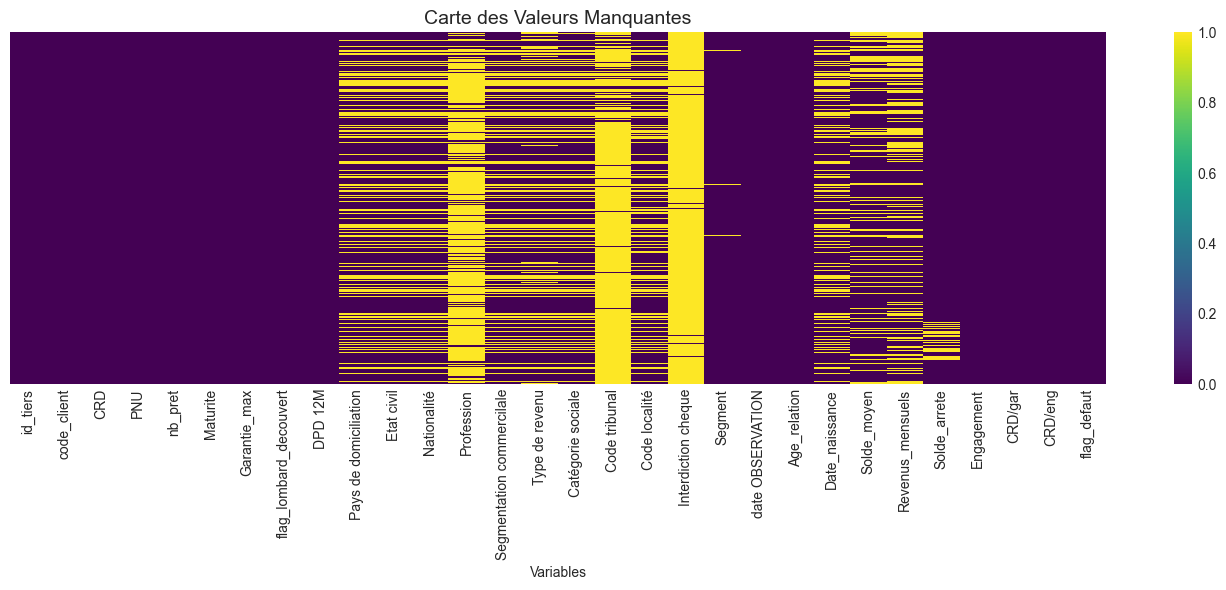

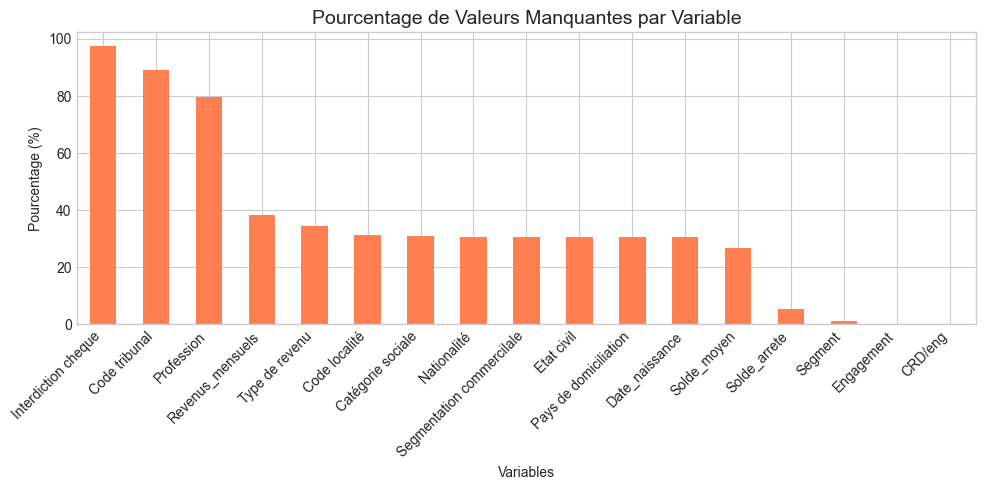

In [373]:
# Visualisation des valeurs manquantes
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap des valeurs manquantes
plt.figure(figsize=(14, 6))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Carte des Valeurs Manquantes', fontsize=14)
plt.xlabel('Variables')
plt.tight_layout()
plt.show()

# Bar plot des pourcentages de valeurs manquantes
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]

if len(missing_pct) > 0:
    plt.figure(figsize=(10, 5))
    missing_pct.plot(kind='bar', color='coral')
    plt.title('Pourcentage de Valeurs Manquantes par Variable', fontsize=14)
    plt.ylabel('Pourcentage (%)')
    plt.xlabel('Variables')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Aucune valeur manquante dans le dataset!")

---
## 1.4 Statistiques Descriptives

> Analyse statistique des variables numeriques (tendance centrale, dispersion, distribution).

In [374]:
# Analyse des doublons
print("=== ANALYSE DES DOUBLONS ===")

# Doublons sur toutes les colonnes
doublons_complets = df.duplicated().sum()
print(f"Doublons complets (toutes colonnes): {doublons_complets}")

# Doublons sur les identifiants
doublons_id_tiers = df['id_tiers'].duplicated().sum()
doublons_code_client = df['code_client'].duplicated().sum()

print(f"Doublons sur id_tiers: {doublons_id_tiers}")
print(f"Doublons sur code_client: {doublons_code_client}")

# Afficher les doublons si présents
if doublons_id_tiers > 0:
    print("\n--- Exemples de doublons id_tiers ---")
    ids_dupliques = df[df['id_tiers'].duplicated(keep=False)]['id_tiers'].unique()[:5]
    print(df[df['id_tiers'].isin(ids_dupliques)][['id_tiers', 'code_client', 'CRD', 'DPD 12M']].head(10))

=== ANALYSE DES DOUBLONS ===
Doublons complets (toutes colonnes): 27
Doublons sur id_tiers: 27
Doublons sur code_client: 3463

--- Exemples de doublons id_tiers ---
      id_tiers  code_client         CRD  DPD 12M
4   10261_2018        10261  1277030.69        0
5   10261_2018        10261  1277030.69        0
6   10261_2019        10261  1226293.50        0
7   10261_2019        10261  1226293.50        0
8   10261_2020        10261  1172463.80        0
9   10261_2020        10261  1172463.80        0
10  10261_2021        10261  1113645.81        0
11  10261_2021        10261  1113645.81        0
12  10277_2018        10277        0.00        0
13  10277_2018        10277        0.00        0


---
## 1.5 Detection des Outliers (Valeurs Aberrantes)

> Visualisation par boxplots pour identifier les valeurs extremes.

In [375]:
# Detection des incoherences et anomalies
print("=== DETECTION DES INCOHERENCES ===\n")

# Variables numeriques
vars_numeriques = df.select_dtypes(include=[np.number]).columns.tolist()
vars_numeriques = [v for v in vars_numeriques if v not in ['flag_defaut']]

# 1. Valeurs negatives ou elles ne devraient pas etre
print("1. VALEURS NEGATIVES SUSPECTES:")
cols_positives = ['CRD', 'PNU', 'nb_pret', 'Maturite', 'Garantie_max', 'Revenus_mensuels', 'Age_relation']
for col in cols_positives:
    if col in df.columns:
        negatifs = (df[col] < 0).sum()
        if negatifs > 0:
            print(f"   [ATTENTION] {col}: {negatifs} valeurs negatives")
        else:
            print(f"   [OK] {col}: OK")

# 2. Verification des dates - Calcul correct de l'age
print("\n2. COHERENCE DES DATES:")
if 'Date_naissance' in df.columns and 'date OBSERVATION' in df.columns:
    # Age calcule correctement : date OBSERVATION - Date_naissance
    df['Age_calcule'] = (df['date OBSERVATION'] - df['Date_naissance']).dt.days / 365.25
    ages_aberrants = ((df['Age_calcule'] < 18) | (df['Age_calcule'] > 100)).sum()
    print(f"   Methode: date OBSERVATION - Date_naissance")
    print(f"   Ages aberrants (<18 ou >100 ans): {ages_aberrants}")
    print(f"   Age min: {df['Age_calcule'].min():.1f} ans")
    print(f"   Age max: {df['Age_calcule'].max():.1f} ans")
elif 'Date_naissance' in df.columns:
    # Fallback si date OBSERVATION n'existe pas
    df['Age_calcule'] = (pd.to_datetime('today') - df['Date_naissance']).dt.days / 365.25
    ages_aberrants = ((df['Age_calcule'] < 18) | (df['Age_calcule'] > 100)).sum()
    print(f"   [NOTE] Fallback: date actuelle - Date_naissance (date OBSERVATION non disponible)")
    print(f"   Ages aberrants (<18 ou >100 ans): {ages_aberrants}")
    print(f"   Age min: {df['Age_calcule'].min():.1f} ans")
    print(f"   Age max: {df['Age_calcule'].max():.1f} ans")

# 3. Verification DPD
print("\n3. COHERENCE DPD 12M:")
dpd_negatifs = (df['DPD 12M'] < 0).sum()
dpd_excessifs = (df['DPD 12M'] > 365).sum()
print(f"   DPD negatifs: {dpd_negatifs}")
print(f"   DPD > 365 jours: {dpd_excessifs}")

# 4. Ratios
print("\n4. COHERENCE DES RATIOS:")
if 'CRD/gar' in df.columns:
    ratio_aberrant = (df['CRD/gar'] < 0).sum()
    print(f"   CRD/gar negatifs: {ratio_aberrant}")
if 'CRD/eng' in df.columns:
    ratio_aberrant = (df['CRD/eng'] < 0).sum()
    print(f"   CRD/eng negatifs: {ratio_aberrant}")

=== DETECTION DES INCOHERENCES ===

1. VALEURS NEGATIVES SUSPECTES:
   [OK] CRD: OK
   [OK] PNU: OK
   [OK] nb_pret: OK
   [ATTENTION] Maturite: 733 valeurs negatives
   [OK] Garantie_max: OK
   [OK] Revenus_mensuels: OK
   [OK] Age_relation: OK

2. COHERENCE DES DATES:
   Methode: date OBSERVATION - Date_naissance
   Ages aberrants (<18 ou >100 ans): 6
   Age min: 1.0 ans
   Age max: 87.9 ans

3. COHERENCE DPD 12M:
   DPD negatifs: 0
   DPD > 365 jours: 54

4. COHERENCE DES RATIOS:
   CRD/gar negatifs: 0
   CRD/eng negatifs: 0


## 1.5 EDA - Analyse des Variables Numeriques

> Statistiques descriptives et distribution des variables quantitatives.

In [376]:
# Statistiques descriptives des variables numériques
vars_num = df.select_dtypes(include=[np.number]).columns.tolist()
vars_num = [v for v in vars_num if v not in ['flag_defaut', 'code_client']]

print("=== STATISTIQUES DESCRIPTIVES - VARIABLES NUMÉRIQUES ===\n")
stats_desc = df[vars_num].describe().T
stats_desc['skewness'] = df[vars_num].skew()
stats_desc['kurtosis'] = df[vars_num].kurtosis()
print(stats_desc.round(2).to_string())

=== STATISTIQUES DESCRIPTIVES - VARIABLES NUMÉRIQUES ===

                         count        mean         std          min        25%         50%         75%           max  skewness  kurtosis
CRD                     5752.0  1514236.45  2921435.67         0.00  495031.69   954789.97  1725396.19  1.060000e+08     16.89    459.44
PNU                     5752.0   187128.06  1914215.33         0.00       0.00        0.00        0.00  7.698238e+07     28.22    990.51
nb_pret                 5752.0        1.25        0.70         1.00       1.00        1.00        1.00  1.300000e+01      5.75     54.51
Maturite                5752.0        4.28       24.95       -61.00       6.75       13.00       18.00  2.500000e+01     -2.05      2.54
Garantie_max            5752.0  1493534.42  3780504.09         0.00       0.00   900000.00  1750000.00  2.157835e+08     34.21   1821.33
flag_lombard_decouvert  5752.0        0.21        0.43         0.00       0.00        0.00        0.00  4.000000e+00    

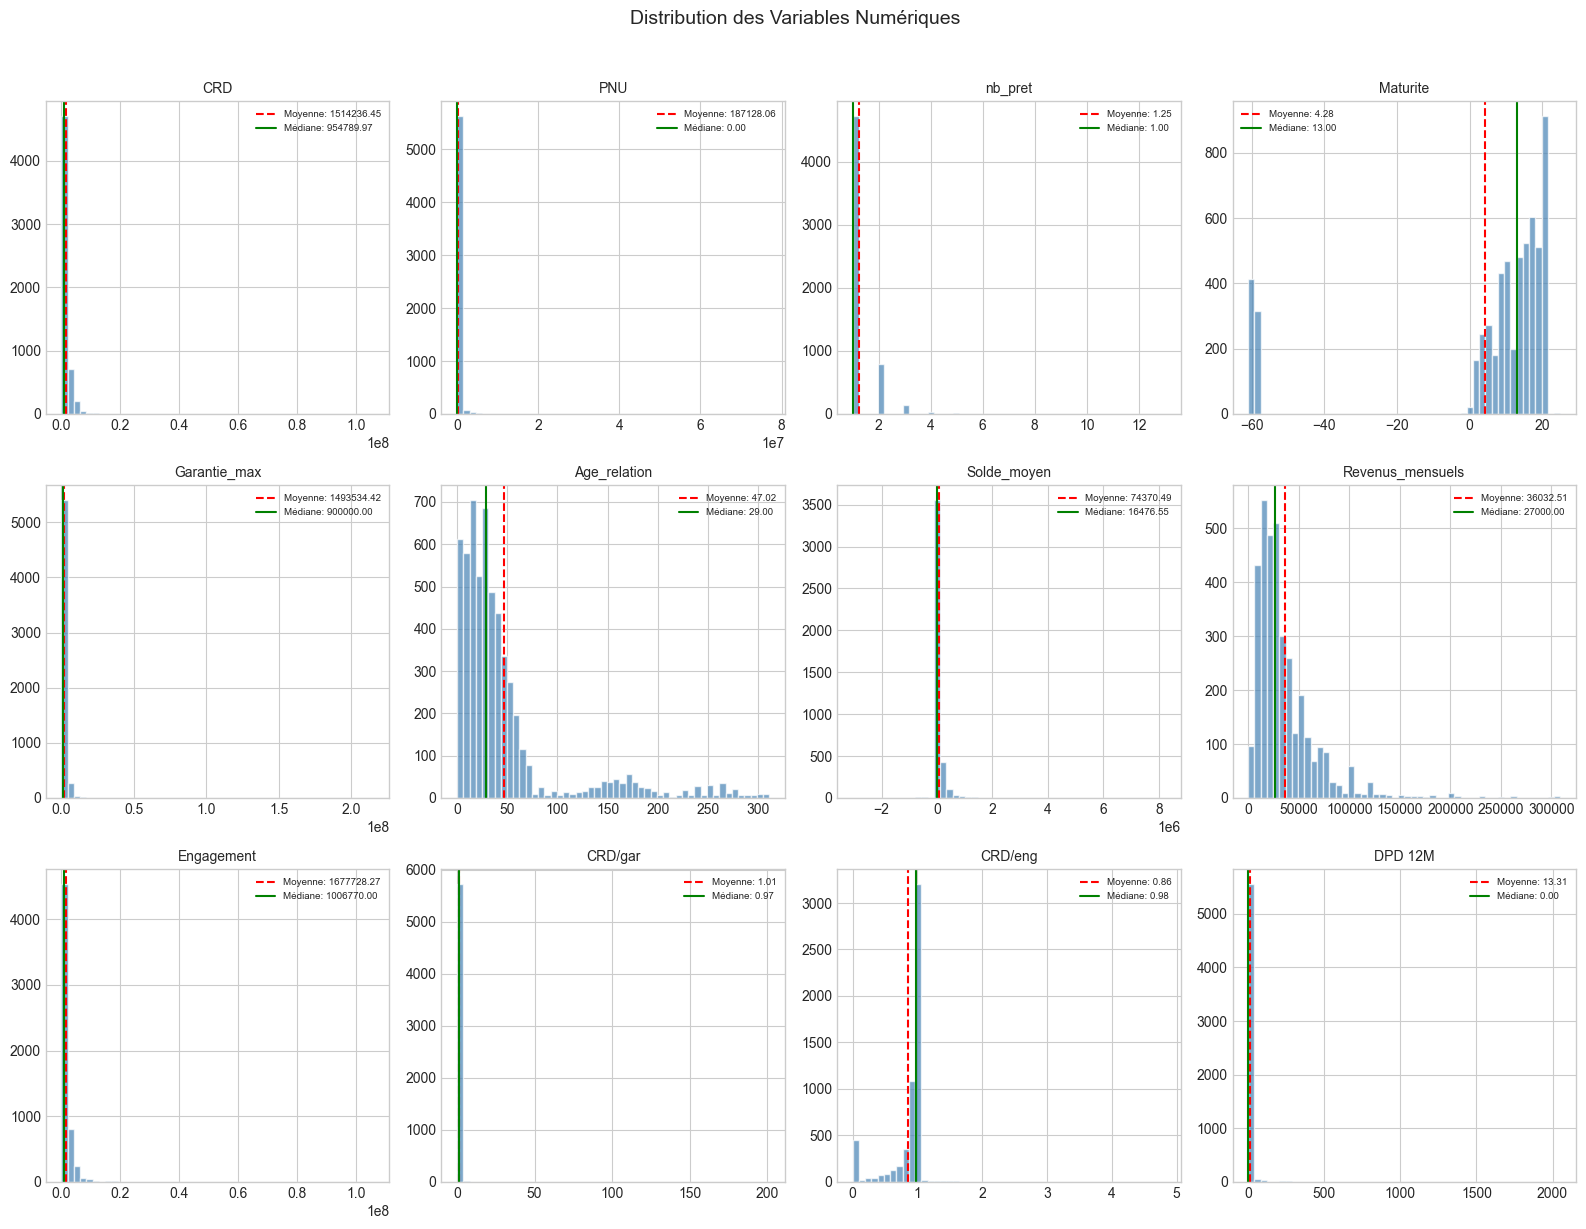

In [377]:
# Distribution des variables numériques clés
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

vars_to_plot = ['CRD', 'PNU', 'nb_pret', 'Maturite', 'Garantie_max', 'Age_relation', 
                'Solde_moyen', 'Revenus_mensuels', 'Engagement', 'CRD/gar', 'CRD/eng', 'DPD 12M']

for i, var in enumerate(vars_to_plot):
    if var in df.columns:
        ax = axes[i]
        # Utiliser des bins adaptés
        data = df[var].dropna()
        ax.hist(data, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
        ax.set_title(f'{var}', fontsize=10)
        ax.set_xlabel('')
        ax.axvline(data.mean(), color='red', linestyle='--', label=f'Moyenne: {data.mean():.2f}')
        ax.axvline(data.median(), color='green', linestyle='-', label=f'Médiane: {data.median():.2f}')
        ax.legend(fontsize=7)

plt.suptitle('Distribution des Variables Numériques', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

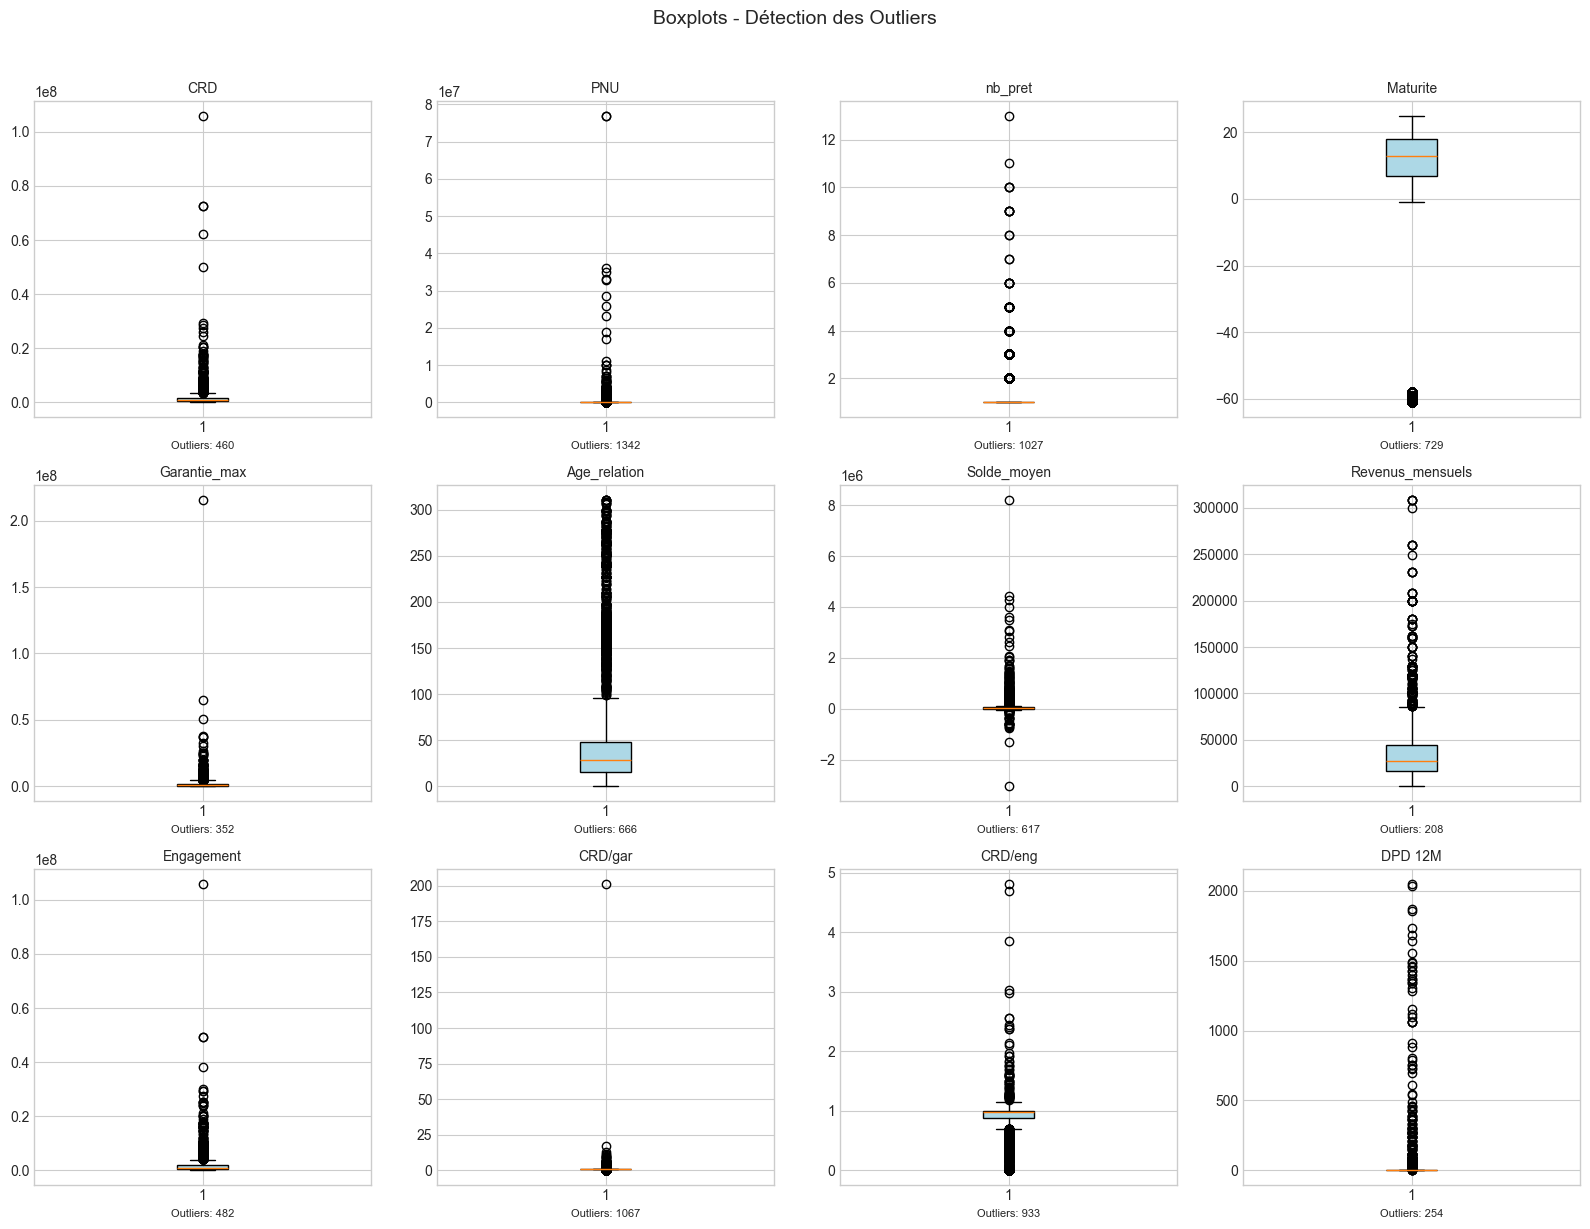

In [378]:
# Boxplots pour détecter les outliers
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    if var in df.columns:
        ax = axes[i]
        data = df[var].dropna()
        bp = ax.boxplot(data, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        ax.set_title(f'{var}', fontsize=10)
        
        # Calculer et afficher le nombre d'outliers
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)).sum()
        ax.set_xlabel(f'Outliers: {outliers}', fontsize=8)

plt.suptitle('Boxplots - Détection des Outliers', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## 1.6 Analyse des Variables Categorielles

> Distribution des modalites pour chaque variable qualitative.

In [379]:
# Analyse des variables catégorielles
vars_cat = df.select_dtypes(include=['object']).columns.tolist()
vars_cat = [v for v in vars_cat if v != 'id_tiers']  # Exclure identifiant

print("=== VARIABLES CATÉGORIELLES ===\n")
for var in vars_cat:
    n_unique = df[var].nunique()
    print(f"{var}:")
    print(f"   - Modalités uniques: {n_unique}")
    print(f"   - Valeurs manquantes: {df[var].isnull().sum()}")
    if n_unique <= 10:
        print(f"   - Distribution:")
        for val, count in df[var].value_counts().head(10).items():
            pct = count / len(df) * 100
            print(f"      {val}: {count} ({pct:.1f}%)")
    print()

=== VARIABLES CATÉGORIELLES ===

Pays de domiciliation:
   - Modalités uniques: 14
   - Valeurs manquantes: 1753

Etat civil:
   - Modalités uniques: 6
   - Valeurs manquantes: 1753
   - Distribution:
      Marié: 2761 (48.0%)
      Célibataire: 1094 (19.0%)
      Divorcé: 120 (2.1%)
      Concubinage: 15 (0.3%)
      Veuf: 8 (0.1%)
      Séparé: 1 (0.0%)

Nationalité:
   - Modalités uniques: 14
   - Valeurs manquantes: 1753

Profession:
   - Modalités uniques: 353
   - Valeurs manquantes: 4588

Segmentation commercilale:
   - Modalités uniques: 16
   - Valeurs manquantes: 1753

Type de revenu:
   - Modalités uniques: 5
   - Valeurs manquantes: 1978
   - Distribution:
      Revenus salariés (02): 3025 (52.6%)
      Revenus professionnels à flux immédiats (04): 371 (6.4%)
      Revenus professionnels à flux différés (05): 231 (4.0%)
      Revenus patrimoniaux (03): 112 (1.9%)
      Revenu dépendant d’un tiers (01): 35 (0.6%)

Catégorie sociale:
   - Modalités uniques: 18
   - Valeurs ma

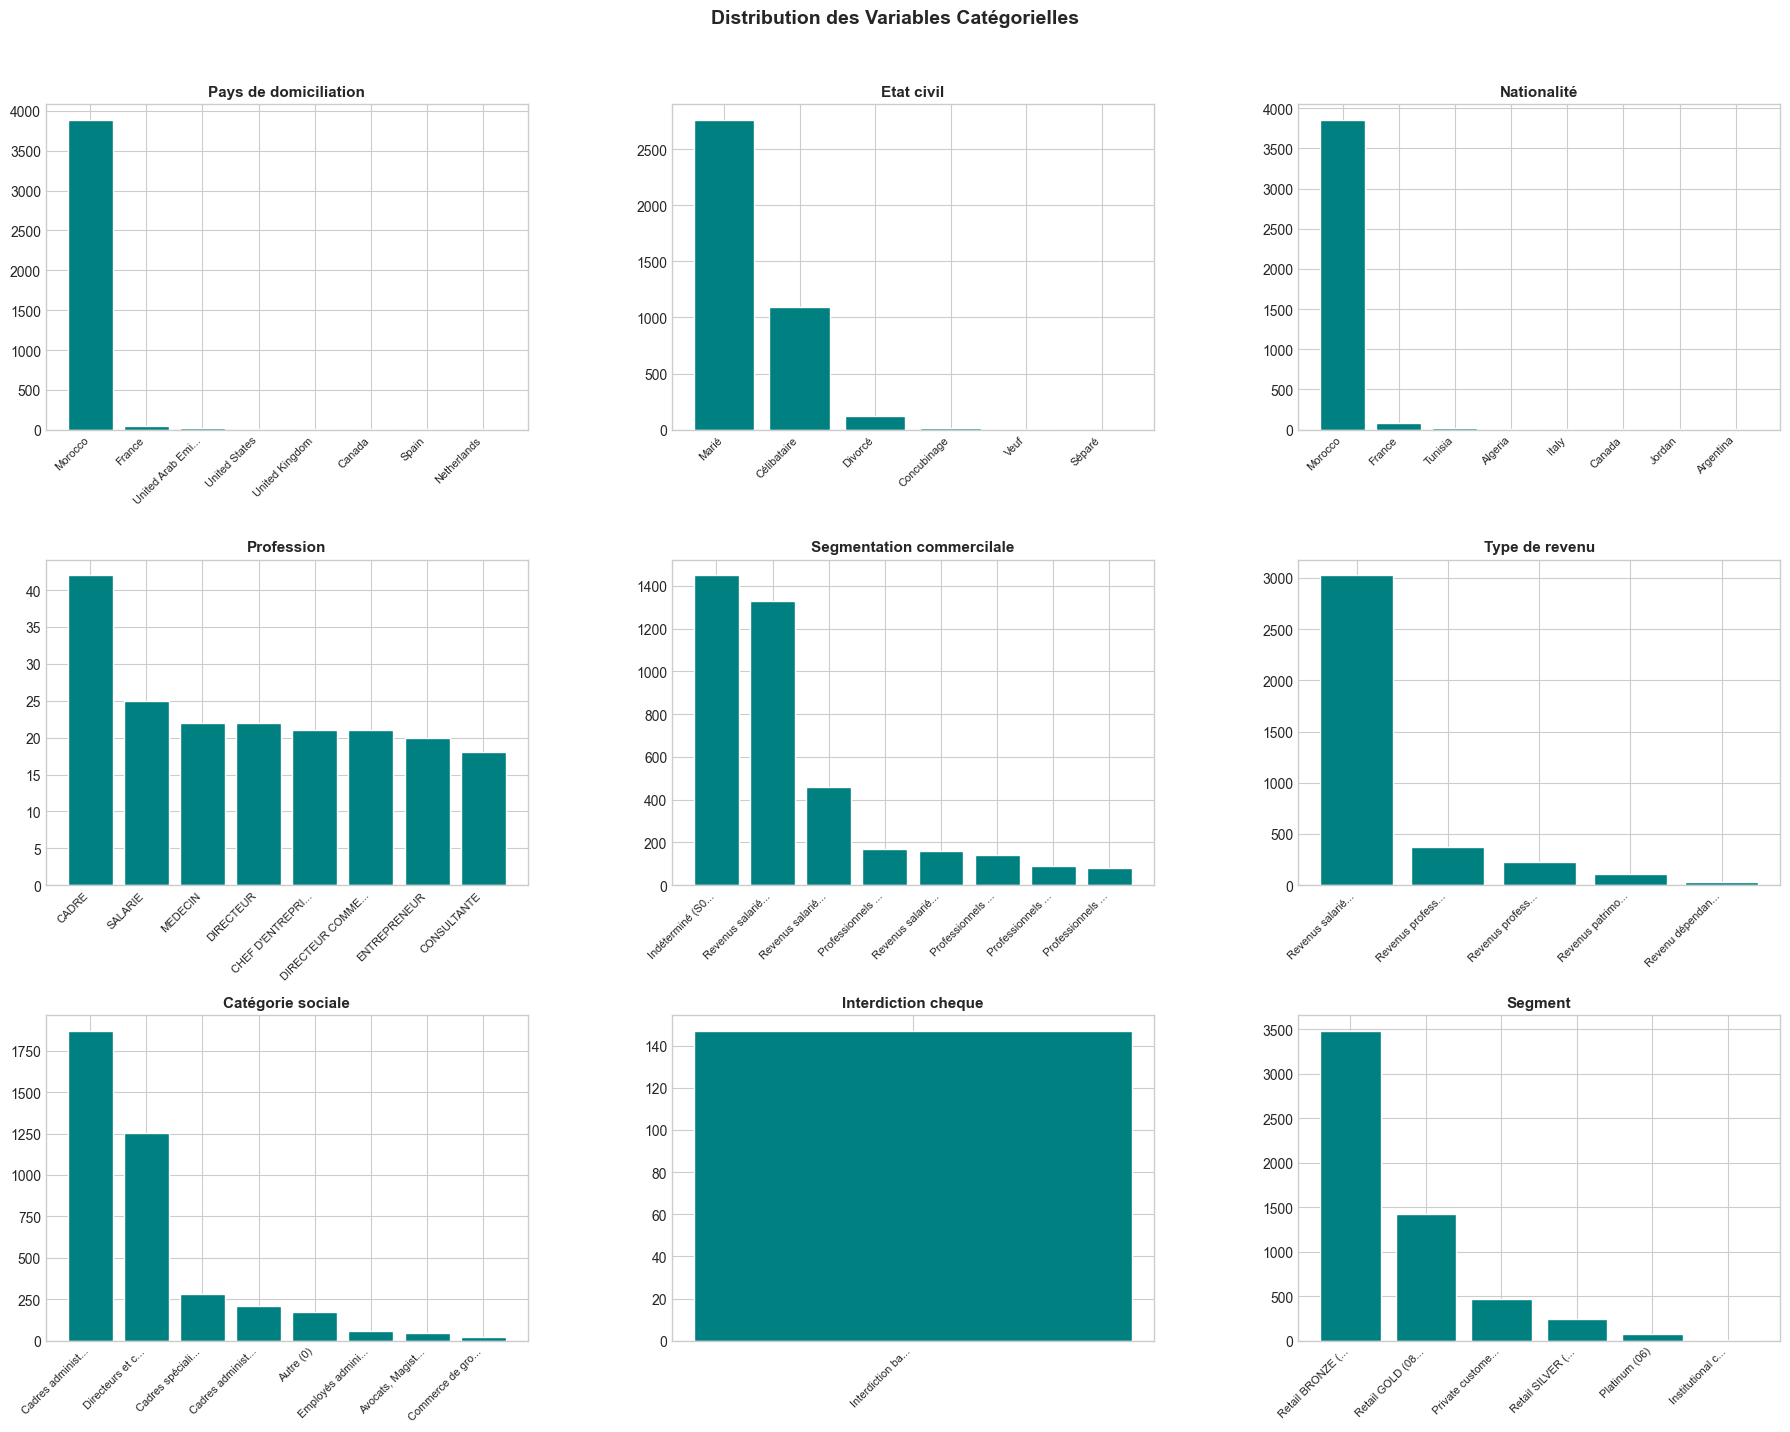

In [380]:
# Visualisation des variables catégorielles principales
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

vars_cat_plot = ['Pays de domiciliation', 'Etat civil', 'Nationalité', 'Profession', 
                  'Segmentation commercilale', 'Type de revenu', 'Catégorie sociale', 
                  'Interdiction cheque', 'Segment']

for i, var in enumerate(vars_cat_plot):
    if var in df.columns and i < len(axes):
        ax = axes[i]
        counts = df[var].value_counts().head(8)
        # Tronquer les labels longs
        labels = [str(x)[:15] + '...' if len(str(x)) > 15 else str(x) for x in counts.index]
        bars = ax.bar(range(len(counts)), counts.values, color='teal', edgecolor='white')
        ax.set_xticks(range(len(counts)))
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
        ax.set_title(f'{var}', fontsize=11, fontweight='bold')
        ax.set_xlabel('')

plt.suptitle('Distribution des Variables Catégorielles', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

---
## 1.6 Analyse Bivariee : Variable Cible vs Variables Explicatives

> Etude de la relation entre chaque variable et le risque de defaut.

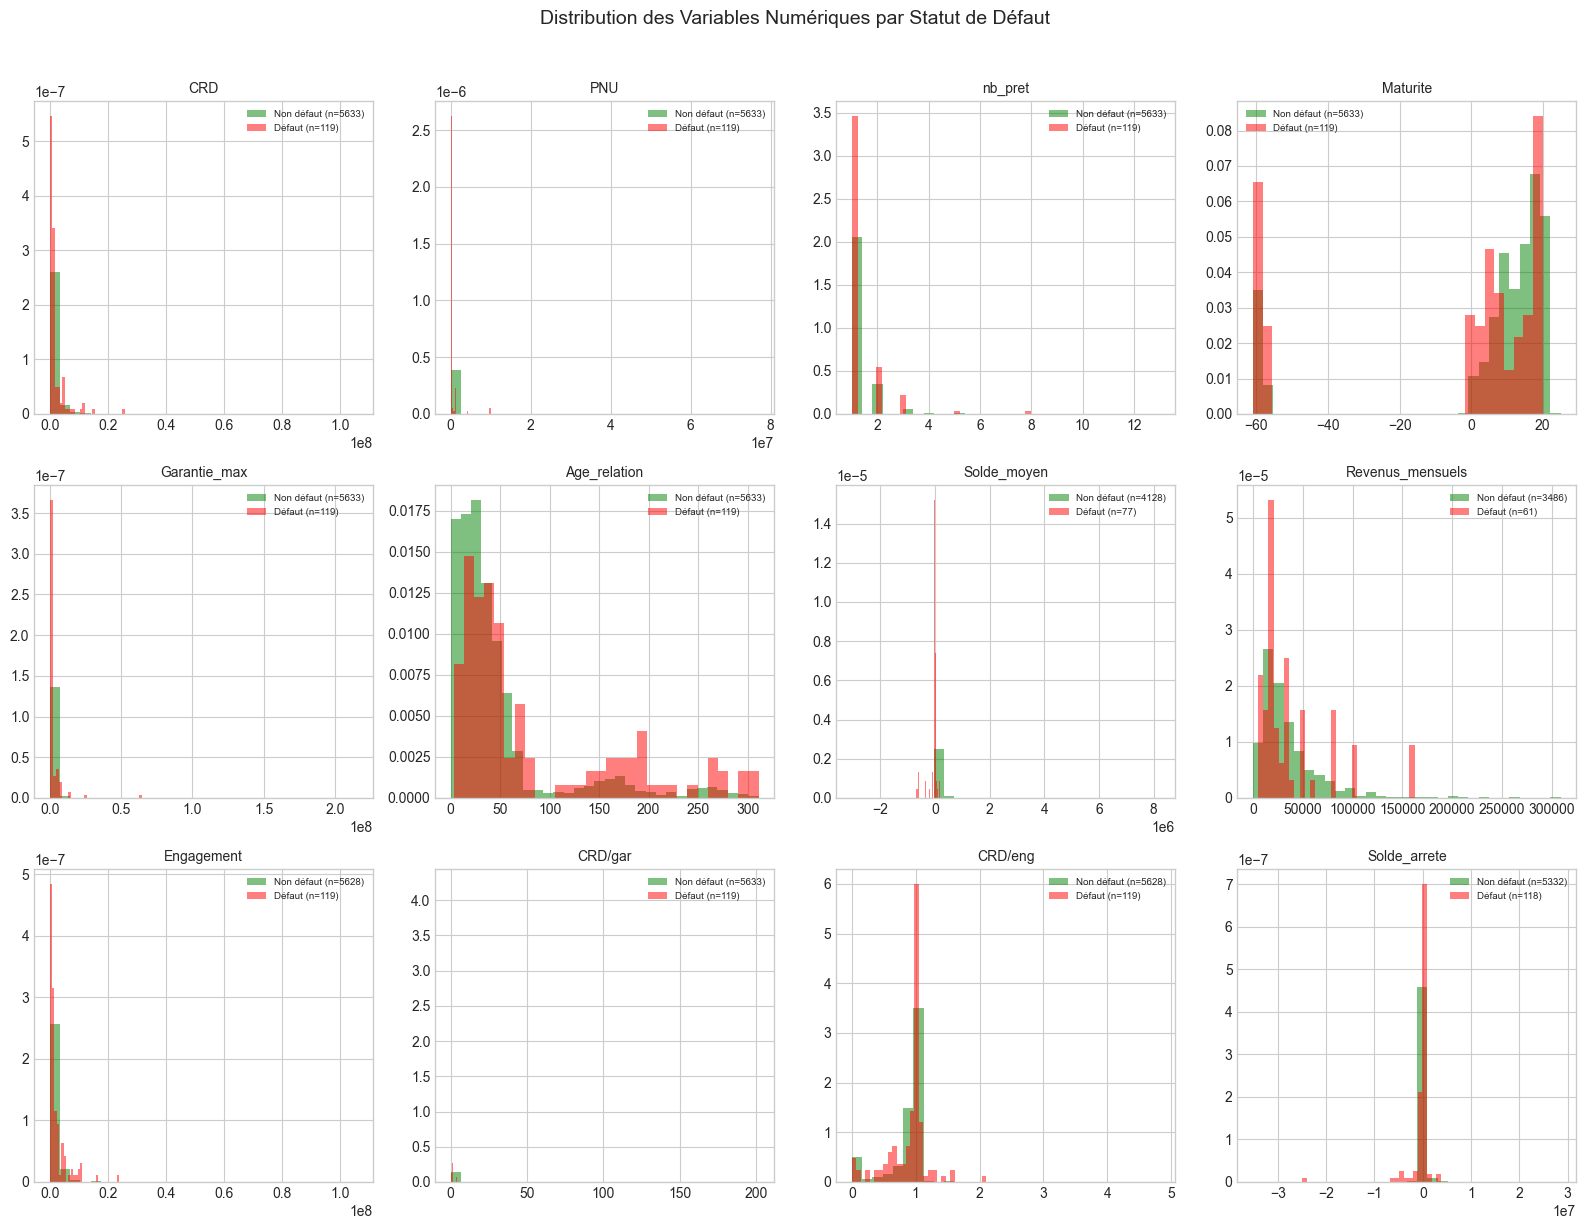

In [381]:
# Analyse bivariée : Variables numériques vs flag_defaut
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

vars_num_analyse = ['CRD', 'PNU', 'nb_pret', 'Maturite', 'Garantie_max', 'Age_relation', 
                    'Solde_moyen', 'Revenus_mensuels', 'Engagement', 'CRD/gar', 'CRD/eng', 'Solde_arrete']

for i, var in enumerate(vars_num_analyse):
    if var in df.columns and i < len(axes):
        ax = axes[i]
        # Comparaison des distributions entre défaut et non défaut
        df_0 = df[df['flag_defaut'] == 0][var].dropna()
        df_1 = df[df['flag_defaut'] == 1][var].dropna()
        
        ax.hist(df_0, bins=30, alpha=0.5, label=f'Non défaut (n={len(df_0)})', color='green', density=True)
        ax.hist(df_1, bins=30, alpha=0.5, label=f'Défaut (n={len(df_1)})', color='red', density=True)
        ax.set_title(f'{var}', fontsize=10)
        ax.legend(fontsize=7)

plt.suptitle('Distribution des Variables Numériques par Statut de Défaut', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

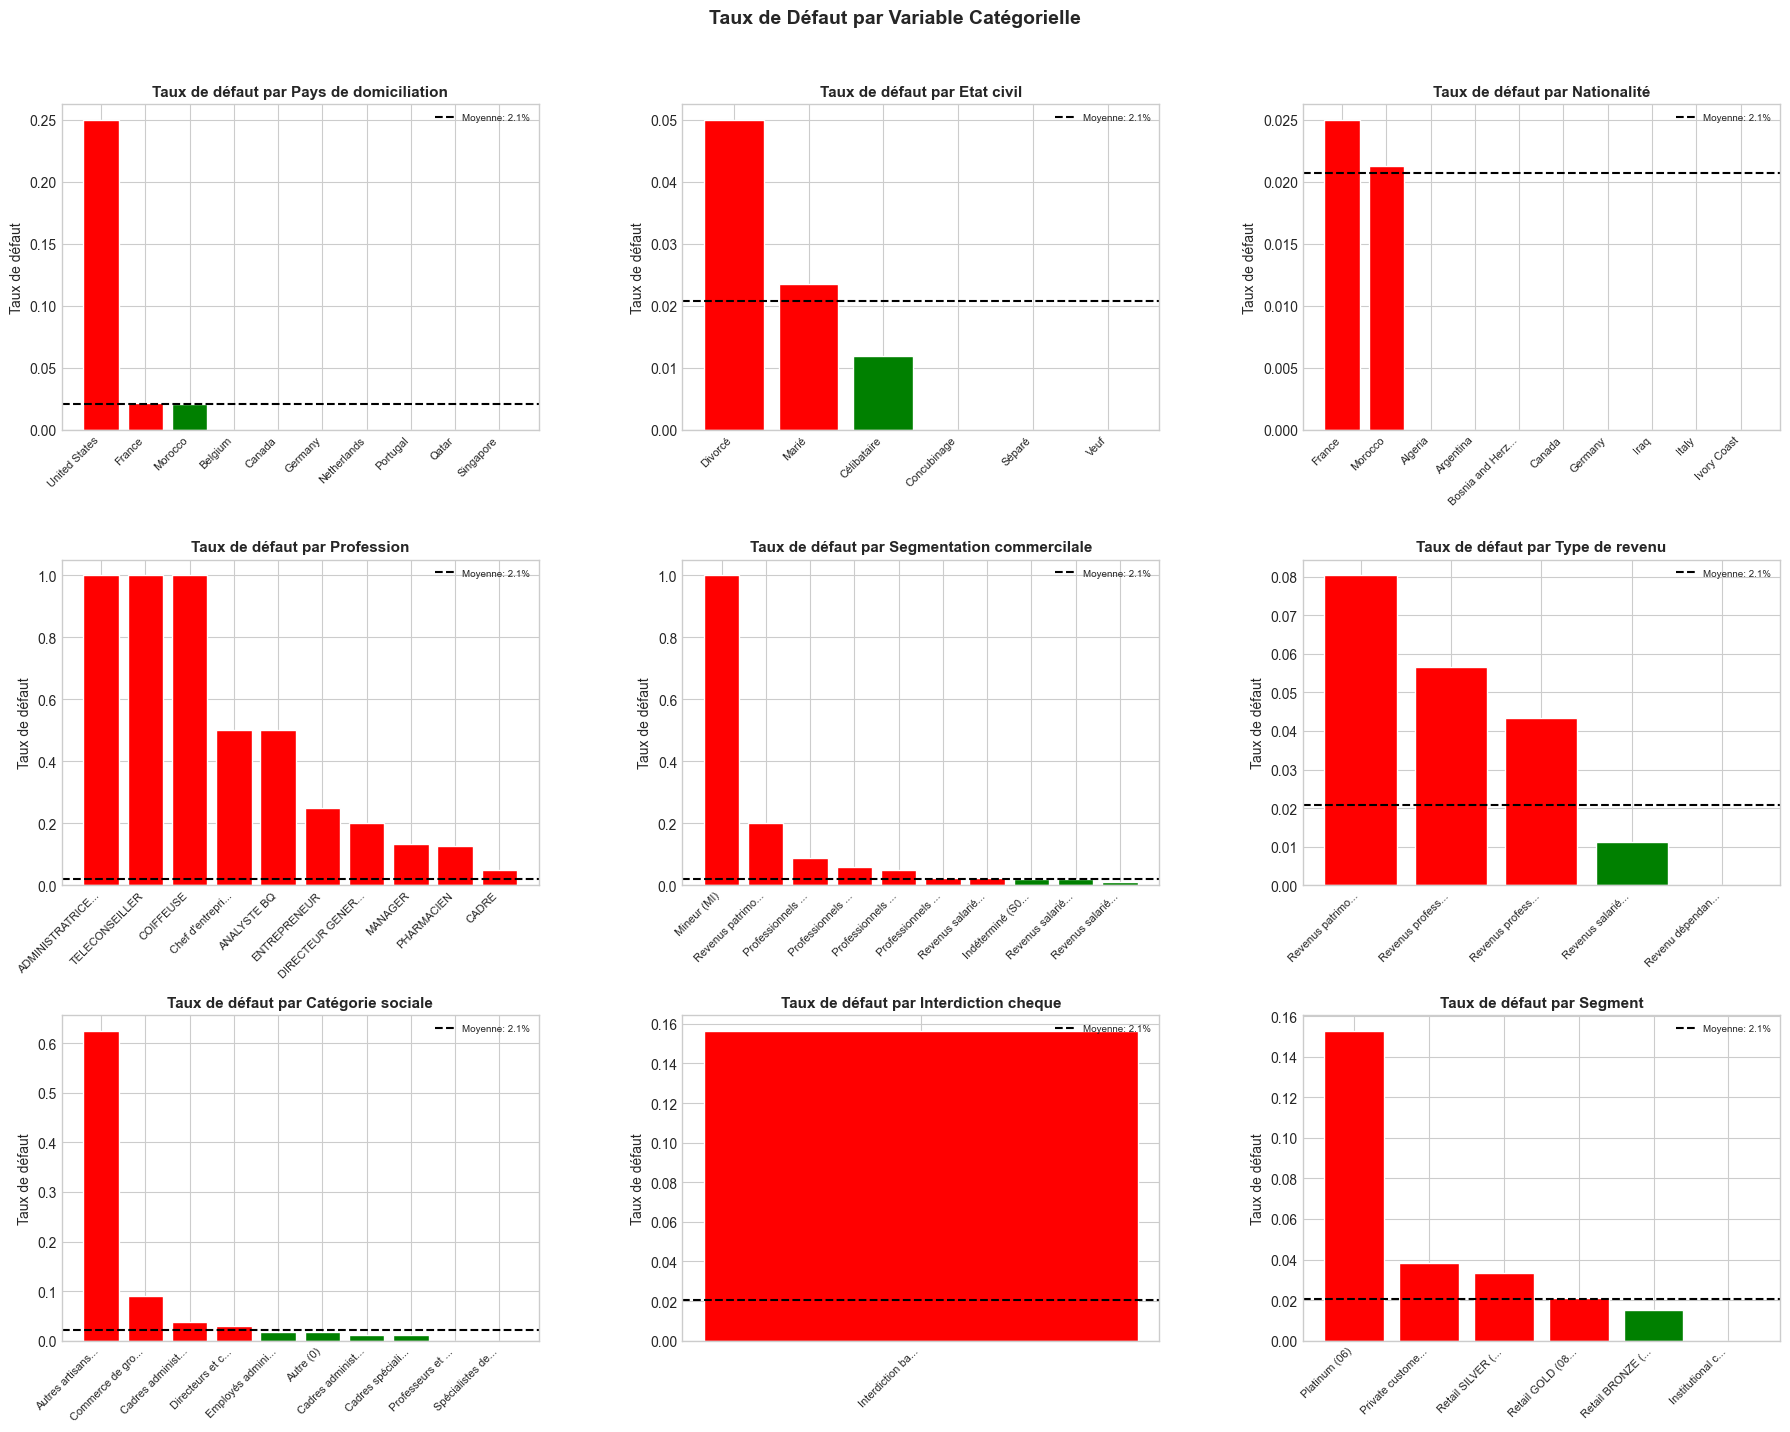

In [382]:
# Taux de défaut par variable catégorielle
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for i, var in enumerate(vars_cat_plot):
    if var in df.columns and i < len(axes):
        ax = axes[i]
        # Calculer le taux de défaut par modalité
        taux_defaut = df.groupby(var)['flag_defaut'].mean().sort_values(ascending=False).head(10)
        colors = ['red' if x > df['flag_defaut'].mean() else 'green' for x in taux_defaut]
        # Tronquer les labels longs
        labels = [str(x)[:15] + '...' if len(str(x)) > 15 else str(x) for x in taux_defaut.index]
        bars = ax.bar(range(len(taux_defaut)), taux_defaut.values, color=colors, edgecolor='white')
        ax.set_xticks(range(len(taux_defaut)))
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
        ax.axhline(y=df['flag_defaut'].mean(), color='black', linestyle='--', label=f"Moyenne: {df['flag_defaut'].mean()*100:.1f}%")
        ax.set_title(f'Taux de défaut par {var}', fontsize=11, fontweight='bold')
        ax.set_ylabel('Taux de défaut')
        ax.legend(fontsize=7)

plt.suptitle('Taux de Défaut par Variable Catégorielle', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

---
## 1.8 Synthese de l'Etape 1

> **Resume des observations** et recommandations pour les etapes suivantes.

In [383]:
# Resume complet du Data Quality Check
print("=" * 70)
print("              RESUME DU DATA QUALITY CHECK")
print("=" * 70)

print("\n[INFO] INFORMATIONS GENERALES:")
print(f"   - Nombre total d'observations: {len(df)}")
print(f"   - Nombre total de variables: {len(df.columns)}")
print(f"   - Variables numeriques: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"   - Variables categorielles: {len(df.select_dtypes(include=['object']).columns)}")
print(f"   - Variables temporelles: {len(df.select_dtypes(include=['datetime64']).columns)}")

print("\n[TARGET] VARIABLE CIBLE (flag_defaut):")
print(f"   - Defauts (1): {df['flag_defaut'].sum()} ({df['flag_defaut'].mean()*100:.2f}%)")
print(f"   - Non defauts (0): {(df['flag_defaut']==0).sum()} ({(df['flag_defaut']==0).mean()*100:.2f}%)")
print(f"   [ATTENTION] Base tres desequilibree - Reechantillonnage necessaire!")

print("\n[MISSING] VALEURS MANQUANTES:")
missing_count = df.isnull().sum().sum()
cols_with_missing = (df.isnull().sum() > 0).sum()
print(f"   - Total valeurs manquantes: {missing_count}")
print(f"   - Variables avec valeurs manquantes: {cols_with_missing}")
if cols_with_missing > 0:
    for col in df.columns[df.isnull().sum() > 0]:
        print(f"      - {col}: {df[col].isnull().sum()} ({df[col].isnull().mean()*100:.1f}%)")

print("\n[DOUBLONS] DOUBLONS:")
print(f"   - Doublons complets: {df.duplicated().sum()}")
print(f"   - Doublons id_tiers: {df['id_tiers'].duplicated().sum()}")

print("\n[NEXT] RECOMMANDATIONS POUR L'ETAPE 2:")
print("   1. Creer/Conserver flag_defaut (DPD > 90 jours)")
print("   2. Traiter les valeurs manquantes (imputation)")
print("   3. Supprimer les variables identifiantes (id_tiers, code_client)")
print("   4. Discretiser les variables continues")
print("   5. Encoder les variables categorielles")
print("   6. Appliquer SMOTE pour equilibrer les classes")
print("=" * 70)

              RESUME DU DATA QUALITY CHECK

[INFO] INFORMATIONS GENERALES:
   - Nombre total d'observations: 5752
   - Nombre total de variables: 31
   - Variables numeriques: 17
   - Variables categorielles: 12
   - Variables temporelles: 2

[TARGET] VARIABLE CIBLE (flag_defaut):
   - Defauts (1): 119 (2.07%)
   - Non defauts (0): 5633 (97.93%)
   [ATTENTION] Base tres desequilibree - Reechantillonnage necessaire!

[MISSING] VALEURS MANQUANTES:
   - Total valeurs manquantes: 35519
   - Variables avec valeurs manquantes: 18
      - Pays de domiciliation: 1753 (30.5%)
      - Etat civil: 1753 (30.5%)
      - Nationalité: 1753 (30.5%)
      - Profession: 4588 (79.8%)
      - Segmentation commercilale: 1753 (30.5%)
      - Type de revenu: 1978 (34.4%)
      - Catégorie sociale: 1775 (30.9%)
      - Code tribunal: 5118 (89.0%)
      - Code localité: 1809 (31.4%)
      - Interdiction cheque: 5605 (97.4%)
      - Segment: 64 (1.1%)
      - Date_naissance: 1753 (30.5%)
      - Solde_moyen: 15

### Resume de l'Etape 1 - Data Quality Check

**Observations principales :**

| Element | Resultat |
|:--------|:---------|
| Observations | 5 752 clients |
| Variables | 31 (apres creation flag_defaut) |
| Taux de defaut | 2.07% (119 defauts) |
| Valeurs manquantes | Presentes dans 18 variables |
| Doublons complets | 27 a supprimer |

**Composition des variables :**
- Variables numeriques : 17
- Variables categorielles : 12
- Variables temporelles : 2

**Points d'attention :**
- **Classes tres desequilibrees** : 97.93% non-defauts vs 2.07% defauts
- **Variables a supprimer** : > 70% de donnees manquantes (Interdiction cheque, Code tribunal, Profession)
- **Calcul de l'age** : Utiliser `date OBSERVATION - Date_naissance` pour eviter les biais

**Actions pour l'Etape 2 :**
1. Suppression des doublons et variables inutiles
2. Imputation des valeurs manquantes
3. Encodage WoE des variables categorielles
4. Reechantillonnage pour equilibrer les classes

# ETAPE 2 : TRAITEMENT DES DONNEES & PREPARATION

---

> **D'apres ce qu'on a vu dans le Data Quality Check**, nous allons maintenant :
> - Supprimer les variables identifiantes (`id_tiers`, `code_client`)
> - Imputer les valeurs manquantes (mediane pour numeriques, mode pour categorielles)
> - Corriger les incoherences (maturites negatives, ages aberrants)
> - Encoder les variables categorielles avec le **WoE** (Weight of Evidence)
> - Reechantillonner les donnees pour traiter le **desequilibre des classes** (~2% de defauts)

## 2.1 Suppression des Doublons et Variables Inutiles

> Nettoyage initial : suppression des identifiants et variables non pertinentes pour le modele.

In [384]:
# Créer une copie du dataframe pour le traitement
df_clean = df.copy()

print("=== NETTOYAGE DES DONNÉES ===\n")
print(f"Taille initiale: {df_clean.shape}")

# 1. Suppression des doublons complets
df_clean = df_clean.drop_duplicates()
print(f"Après suppression des doublons: {df_clean.shape}")

# 2. Suppression des variables identifiantes et inutiles pour le modèle
cols_to_drop = ['id_tiers', 'code_client', 'date OBSERVATION', 'Age_calcule']
cols_to_drop = [c for c in cols_to_drop if c in df_clean.columns]
df_clean = df_clean.drop(columns=cols_to_drop)
print(f"Variables supprimées: {cols_to_drop}")

# 3. Suppression des variables avec trop de valeurs manquantes (>70%)
threshold = 0.70
cols_high_missing = [col for col in df_clean.columns if df_clean[col].isnull().mean() > threshold]
print(f"\nVariables avec >70% de NA (à supprimer): {cols_high_missing}")
df_clean = df_clean.drop(columns=cols_high_missing)

print(f"\nTaille après nettoyage: {df_clean.shape}")
print(f"Colonnes restantes: {df_clean.columns.tolist()}")

=== NETTOYAGE DES DONNÉES ===

Taille initiale: (5752, 31)
Après suppression des doublons: (5725, 31)
Variables supprimées: ['id_tiers', 'code_client', 'date OBSERVATION', 'Age_calcule']

Variables avec >70% de NA (à supprimer): ['Profession', 'Code tribunal', 'Interdiction cheque']

Taille après nettoyage: (5725, 24)
Colonnes restantes: ['CRD', 'PNU', 'nb_pret', 'Maturite', 'Garantie_max', 'flag_lombard_decouvert', 'DPD 12M', 'Pays de domiciliation', 'Etat civil', 'Nationalité', 'Segmentation commercilale', 'Type de revenu', 'Catégorie sociale', 'Code localité', 'Segment', 'Age_relation', 'Date_naissance', 'Solde_moyen', 'Revenus_mensuels', 'Solde_arrete', 'Engagement', 'CRD/gar', 'CRD/eng', 'flag_defaut']


---
## 2.2 Imputation des Valeurs Manquantes

> **Strategie d'imputation** :
> - **Variables numeriques** : Mediane (robuste aux outliers)
> - **Variables categorielles** : Mode (valeur la plus frequente)

In [385]:
# Traitement des valeurs manquantes
print("=== IMPUTATION DES VALEURS MANQUANTES ===\n")

# Identifier les types de variables
vars_numeriques = df_clean.select_dtypes(include=[np.number]).columns.tolist()
vars_numeriques = [v for v in vars_numeriques if v != 'flag_defaut']
vars_categorielles = df_clean.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numeriques a imputer: {vars_numeriques}")
print(f"Variables categorielles a imputer: {vars_categorielles}")

# Imputation des variables numeriques par la mediane
print("\n--- Imputation Numeriques (Mediane) ---")
for col in vars_numeriques:
    missing_before = df_clean[col].isnull().sum()
    if missing_before > 0:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)
        print(f"  {col}: {missing_before} NA -> mediane = {median_val:.2f}")

# Imputation des variables categorielles par le mode
print("\n--- Imputation Categorielles (Mode) ---")
for col in vars_categorielles:
    missing_before = df_clean[col].isnull().sum()
    if missing_before > 0:
        mode_val = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
        df_clean[col] = df_clean[col].fillna(mode_val)
        print(f"  {col}: {missing_before} NA -> mode = '{mode_val}'")

# Verification
print(f"\n[OK] Valeurs manquantes restantes: {df_clean.isnull().sum().sum()}")

=== IMPUTATION DES VALEURS MANQUANTES ===

Variables numeriques a imputer: ['CRD', 'PNU', 'nb_pret', 'Maturite', 'Garantie_max', 'flag_lombard_decouvert', 'DPD 12M', 'Age_relation', 'Solde_moyen', 'Revenus_mensuels', 'Solde_arrete', 'Engagement', 'CRD/gar', 'CRD/eng']
Variables categorielles a imputer: ['Pays de domiciliation', 'Etat civil', 'Nationalité', 'Segmentation commercilale', 'Type de revenu', 'Catégorie sociale', 'Code localité', 'Segment']

--- Imputation Numeriques (Mediane) ---
  Solde_moyen: 1529 NA -> mediane = 16498.90
  Revenus_mensuels: 2183 NA -> mediane = 27000.00
  Solde_arrete: 302 NA -> mediane = 29540.15
  Engagement: 5 NA -> mediane = 1005501.94
  CRD/eng: 5 NA -> mediane = 0.98

--- Imputation Categorielles (Mode) ---
  Pays de domiciliation: 1749 NA -> mode = 'Morocco'
  Etat civil: 1749 NA -> mode = 'Marié'
  Nationalité: 1749 NA -> mode = 'Morocco'
  Segmentation commercilale: 1749 NA -> mode = 'Indéterminé (S0)'
  Type de revenu: 1963 NA -> mode = 'Revenus

---
## 2.3 Traitement des Incoherences

> Correction des valeurs aberrantes (maturite negative, age incoherent, etc.)

In [386]:
# Traitement des valeurs incoherentes
print("=== TRAITEMENT DES INCOHERENCES ===\n")

# 1. Maturite negative -> Remplacer par 0 (pret echu)
if 'Maturite' in df_clean.columns:
    neg_maturite = (df_clean['Maturite'] < 0).sum()
    df_clean.loc[df_clean['Maturite'] < 0, 'Maturite'] = 0
    print(f"Maturite negative: {neg_maturite} valeurs -> remplacees par 0")

# 2. Traitement de la date de naissance (conversion en age)
# Utiliser date OBSERVATION - Date_naissance pour un calcul correct
if 'Date_naissance' in df_clean.columns and 'date OBSERVATION' in df.columns:
    # Recuperer la date d'observation depuis le df original (aligne sur l'index)
    date_obs = df.loc[df_clean.index, 'date OBSERVATION']
    df_clean['Age'] = (date_obs - df_clean['Date_naissance']).dt.days / 365.25
    # Borner les ages aberrants
    df_clean.loc[df_clean['Age'] < 18, 'Age'] = 18
    df_clean.loc[df_clean['Age'] > 100, 'Age'] = df_clean['Age'].median()
    # Supprimer la colonne date
    df_clean = df_clean.drop(columns=['Date_naissance'])
    print("Date_naissance -> convertie en 'Age' (date OBSERVATION - Date_naissance, borne 18-100)")
elif 'Date_naissance' in df_clean.columns:
    # Fallback si date OBSERVATION n'est pas disponible
    df_clean['Age'] = (pd.Timestamp.now() - df_clean['Date_naissance']).dt.days / 365.25
    df_clean.loc[df_clean['Age'] < 18, 'Age'] = 18
    df_clean.loc[df_clean['Age'] > 100, 'Age'] = df_clean['Age'].median()
    df_clean = df_clean.drop(columns=['Date_naissance'])
    print("Date_naissance -> convertie en 'Age' (fallback: date actuelle, borne 18-100)")

# 3. Verifier et borner les ratios aberrants
if 'CRD/gar' in df_clean.columns:
    q99 = df_clean['CRD/gar'].quantile(0.99)
    outliers_crd_gar = (df_clean['CRD/gar'] > q99).sum()
    df_clean.loc[df_clean['CRD/gar'] > q99, 'CRD/gar'] = q99
    print(f"CRD/gar: {outliers_crd_gar} outliers bornes au 99e percentile ({q99:.2f})")

print(f"\n[OK] Donnees apres traitement des incoherences: {df_clean.shape}")

=== TRAITEMENT DES INCOHERENCES ===

Maturite negative: 727 valeurs -> remplacees par 0
Date_naissance -> convertie en 'Age' (date OBSERVATION - Date_naissance, borne 18-100)
CRD/gar: 58 outliers bornes au 99e percentile (2.67)

[OK] Donnees apres traitement des incoherences: (5725, 24)


---
## 2.4 Feature Engineering - Creation de Nouvelles Variables

> **Objectif** : Enrichir les donnees avec des ratios et interactions pour ameliorer le pouvoir predictif.

### Description des Variables Creees

| Variable | Formule | Description | Interpretation |
|:---------|:--------|:------------|:---------------|
| **DTI_ratio** | Engagement / Revenus_mensuels | Ratio d'endettement (Debt-to-Income) | Plus eleve = plus endette, risque accru |
| **CRD_revenus_ratio** | CRD / Revenus_mensuels | Poids du credit par rapport aux revenus | Plus eleve = charge de credit importante |
| **utilisation_credit** | CRD / Engagement | Taux d'utilisation du credit accorde | Proche de 1 = credit presque entierement utilise |
| **intensite_relation** | nb_pret / Age_relation | Frequence de prets par mois de relation | Plus eleve = client tres actif |
| **solde_revenus_ratio** | Solde_moyen / Revenus_mensuels | Epargne relative aux revenus | Negatif ou faible = risque de tresorerie |
| **flag_surendettement** | 1 si DTI > 40% | Indicateur de sur-endettement | Standard bancaire : DTI > 40% = risque |
| **flag_sous_garanti** | 1 si CRD/gar > 1 | Indicateur de sous-couverture | Credit superieur aux garanties |
| **log_CRD** | log(1 + CRD) | Transformation logarithmique | Linearise la relation, reduit l'asymetrie |
| **log_Engagement** | log(1 + Engagement) | Transformation logarithmique | Linearise la relation |
| **log_Revenus_mensuels** | log(1 + Revenus) | Transformation logarithmique | Linearise la relation |
| **nb_flags_risque** | Somme des flags | Score de risque composite | Plus eleve = plus de signaux de risque |

### Justification du Feature Engineering

1. **Ratios financiers** : Capturent la capacite de remboursement relative plutot qu'absolue
2. **Indicateurs binaires** : Detectent les situations a risque selon les standards bancaires
3. **Transformations log** : Reduisent l'impact des valeurs extremes et linearisent les relations
4. **Score composite** : Agregent plusieurs signaux de risque en un indicateur synthetique

> **IMPORTANT** : Aucune variable basee sur DPD n'est creee pour eviter le **data leakage** (la cible est derivee du DPD)

In [387]:
# Feature Engineering - Creation de nouvelles variables
print("=== FEATURE ENGINEERING ===\n")

n_vars_before = df_clean.shape[1]

# SUPPRESSION des variables liees a DPD (data leakage)
if 'flag_dpd_historique' in df_clean.columns:
    df_clean = df_clean.drop(columns=['flag_dpd_historique'])
    print("[SUPPRIME] flag_dpd_historique (data leakage avec la cible)")

# Recalculer nb_flags_risque sans flag_dpd
if 'nb_flags_risque' in df_clean.columns:
    df_clean = df_clean.drop(columns=['nb_flags_risque'])

# 1. RATIOS FINANCIERS - Capacite de remboursement
print("\n--- 1. Ratios Financiers ---")

# Ratio Engagement / Revenus (Debt-to-Income)
if 'Engagement' in df_clean.columns and 'Revenus_mensuels' in df_clean.columns:
    df_clean['DTI_ratio'] = df_clean['Engagement'] / (df_clean['Revenus_mensuels'] + 1)
    df_clean['DTI_ratio'] = df_clean['DTI_ratio'].clip(upper=df_clean['DTI_ratio'].quantile(0.99))
    print(f"  [OK] DTI_ratio (Engagement/Revenus): cree")

# Ratio CRD / Revenus mensuels
if 'CRD' in df_clean.columns and 'Revenus_mensuels' in df_clean.columns:
    df_clean['CRD_revenus_ratio'] = df_clean['CRD'] / (df_clean['Revenus_mensuels'] + 1)
    df_clean['CRD_revenus_ratio'] = df_clean['CRD_revenus_ratio'].clip(upper=df_clean['CRD_revenus_ratio'].quantile(0.99))
    print(f"  [OK] CRD_revenus_ratio (CRD/Revenus): cree")

# Taux d'utilisation du credit
if 'CRD' in df_clean.columns and 'Engagement' in df_clean.columns:
    df_clean['utilisation_credit'] = df_clean['CRD'] / (df_clean['Engagement'] + 1)
    df_clean['utilisation_credit'] = df_clean['utilisation_credit'].clip(0, 1.5)
    print(f"  [OK] utilisation_credit (CRD/Engagement): cree")

# 2. RATIOS DE COMPORTEMENT
print("\n--- 2. Ratios de Comportement ---")

# Intensite de la relation (nb_pret / Age_relation)
if 'nb_pret' in df_clean.columns and 'Age_relation' in df_clean.columns:
    df_clean['intensite_relation'] = df_clean['nb_pret'] / (df_clean['Age_relation'] + 1)
    print(f"  [OK] intensite_relation (nb_pret/Age_relation): cree")

# Ratio Solde moyen / Revenus
if 'Solde_moyen' in df_clean.columns and 'Revenus_mensuels' in df_clean.columns:
    df_clean['solde_revenus_ratio'] = df_clean['Solde_moyen'] / (df_clean['Revenus_mensuels'] + 1)
    df_clean['solde_revenus_ratio'] = df_clean['solde_revenus_ratio'].clip(
        lower=df_clean['solde_revenus_ratio'].quantile(0.01),
        upper=df_clean['solde_revenus_ratio'].quantile(0.99)
    )
    print(f"  [OK] solde_revenus_ratio (Solde_moyen/Revenus): cree")

# 3. INDICATEURS BINAIRES DE RISQUE (SANS DPD - eviter data leakage)
print("\n--- 3. Indicateurs de Risque ---")

# Flag sur-engagement (DTI > 40%)
if 'DTI_ratio' in df_clean.columns:
    df_clean['flag_surendettement'] = (df_clean['DTI_ratio'] > 0.4).astype(int)
    print(f"  [OK] flag_surendettement (DTI > 40%): cree")

# Flag garantie insuffisante
if 'CRD/gar' in df_clean.columns:
    df_clean['flag_sous_garanti'] = (df_clean['CRD/gar'] > 1).astype(int)
    print(f"  [OK] flag_sous_garanti (CRD/gar > 1): cree")

# 4. TRANSFORMATIONS
print("\n--- 4. Transformations ---")

# Log des variables a forte asymetrie
for col in ['CRD', 'Engagement', 'Revenus_mensuels']:
    if col in df_clean.columns:
        df_clean[f'log_{col}'] = np.log1p(df_clean[col].clip(lower=0))
        print(f"  [OK] log_{col}: cree")

# 5. INTERACTIONS (sans flag_dpd_historique)
print("\n--- 5. Interactions ---")

# Score de risque composite (SANS flag_dpd_historique pour eviter data leakage)
risk_factors = []
if 'flag_surendettement' in df_clean.columns:
    risk_factors.append(df_clean['flag_surendettement'])
if 'flag_sous_garanti' in df_clean.columns:
    risk_factors.append(df_clean['flag_sous_garanti'])

if risk_factors:
    df_clean['nb_flags_risque'] = sum(risk_factors)
    print(f"  [OK] nb_flags_risque (somme des flags, sans DPD): cree")

n_vars_after = df_clean.shape[1]
n_new_vars = n_vars_after - n_vars_before

print(f"\n{'='*50}")
print(f"RESUME DU FEATURE ENGINEERING")
print(f"{'='*50}")
print(f"   Variables avant: {n_vars_before}")
print(f"   Variables apres: {n_vars_after}")
print(f"\n[IMPORTANT] Aucune variable basee sur DPD (evite data leakage)")
print(f"\nFeatures disponibles:")
new_features = ['DTI_ratio', 'CRD_revenus_ratio', 'utilisation_credit', 'intensite_relation',
                'solde_revenus_ratio', 'flag_surendettement', 
                'flag_sous_garanti', 'log_CRD', 'log_Engagement', 'log_Revenus_mensuels', 'nb_flags_risque']
for f in new_features:
    if f in df_clean.columns:
        print(f"   - {f}")

=== FEATURE ENGINEERING ===


--- 1. Ratios Financiers ---
  [OK] DTI_ratio (Engagement/Revenus): cree
  [OK] CRD_revenus_ratio (CRD/Revenus): cree
  [OK] utilisation_credit (CRD/Engagement): cree

--- 2. Ratios de Comportement ---
  [OK] intensite_relation (nb_pret/Age_relation): cree
  [OK] solde_revenus_ratio (Solde_moyen/Revenus): cree

--- 3. Indicateurs de Risque ---
  [OK] flag_surendettement (DTI > 40%): cree
  [OK] flag_sous_garanti (CRD/gar > 1): cree

--- 4. Transformations ---
  [OK] log_CRD: cree
  [OK] log_Engagement: cree
  [OK] log_Revenus_mensuels: cree

--- 5. Interactions ---
  [OK] nb_flags_risque (somme des flags, sans DPD): cree

RESUME DU FEATURE ENGINEERING
   Variables avant: 24
   Variables apres: 35

[IMPORTANT] Aucune variable basee sur DPD (evite data leakage)

Features disponibles:
   - DTI_ratio
   - CRD_revenus_ratio
   - utilisation_credit
   - intensite_relation
   - solde_revenus_ratio
   - flag_surendettement
   - flag_sous_garanti
   - log_CRD
   - 

---
## 2.5 Identification des Variables Categorielles

> Preparation pour l'encodage WoE (Weight of Evidence).

In [388]:
# Identification des variables categorielles (encodage differe apres split)
print("=== IDENTIFICATION DES VARIABLES CATEGORIELLES ===\n")

# Identifier les variables categorielles restantes
vars_cat = df_clean.select_dtypes(include=['object']).columns.tolist()
print(f"Variables categorielles identifiees ({len(vars_cat)}):")
for col in vars_cat:
    n_unique = df_clean[col].nunique()
    print(f"  - {col}: {n_unique} modalites")

print("\n[IMPORTANT] L'encodage WoE sera effectue APRES le split Train/Test")
print("   pour eviter le Data Leakage (biais d'information)")
print("\n[OK] Variables categorielles a encoder: ", vars_cat)

=== IDENTIFICATION DES VARIABLES CATEGORIELLES ===

Variables categorielles identifiees (8):
  - Pays de domiciliation: 14 modalites
  - Etat civil: 6 modalites
  - Nationalité: 14 modalites
  - Segmentation commercilale: 16 modalites
  - Type de revenu: 5 modalites
  - Catégorie sociale: 18 modalites
  - Code localité: 38 modalites
  - Segment: 6 modalites

[IMPORTANT] L'encodage WoE sera effectue APRES le split Train/Test
   pour eviter le Data Leakage (biais d'information)

[OK] Variables categorielles a encoder:  ['Pays de domiciliation', 'Etat civil', 'Nationalité', 'Segmentation commercilale', 'Type de revenu', 'Catégorie sociale', 'Code localité', 'Segment']


---
## 2.6 Note sur la Discretisation

> La discretisation des variables continues est **optionnelle** pour la regression logistique.

In [389]:
# Note: La discretisation des variables continues est optionnelle
# Les variables continues seront utilisees telles quelles dans le modele
# La discretisation peut etre utile pour l'interpretation mais n'est pas 
# obligatoire pour la regression logistique

print("=== NOTE SUR LA DISCRETISATION ===\n")
print("Les variables continues seront utilisees directement dans le modele.")
print("La regression logistique gere bien les variables continues.")
print("L'encodage WoE sera applique uniquement aux variables categorielles.")
print(f"\n[OK] Shape actuel: {df_clean.shape}")

=== NOTE SUR LA DISCRETISATION ===

Les variables continues seront utilisees directement dans le modele.
La regression logistique gere bien les variables continues.
L'encodage WoE sera applique uniquement aux variables categorielles.

[OK] Shape actuel: (5725, 35)


---
## 2.7 Separation Train/Test & Encodage WoE

> **Point critique** : Le split est effectue **AVANT** l'encodage pour eviter le **data leakage**.

| Ensemble | Proportion | Usage |
|:--------:|:----------:|:------|
| **Train** | 70% | Apprentissage du modele + Calcul WoE |
| **Test** | 30% | Evaluation finale (donnees non vues) |

### Formule du Weight of Evidence (WoE)

$$WoE_i = \ln\left(\frac{\text{Distribution des Bons}_i}{\text{Distribution des Mauvais}_i}\right)$$

**Interpretation :**
- **WoE positif** : Modalite associee a moins de defauts (bon risque)
- **WoE negatif** : Modalite associee a plus de defauts (mauvais risque)

In [390]:
# Separation Train / Test AVANT l'encodage WoE (eviter Data Leakage)
from sklearn.model_selection import train_test_split

print("=== SEPARATION TRAIN / TEST ===\n")

# Definir X (features) et y (target)
X = df_clean.drop(columns=['flag_defaut', 'DPD 12M'])  # On enleve aussi DPD 12M car directement lie a la cible
y = df_clean['flag_defaut']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

# Split 70/30 avec stratification pour garder les memes proportions de defaut
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=42, 
    stratify=y  # Important pour les classes desequilibrees
)

print(f"\n--- Repartition ---")
print(f"Train: {X_train.shape[0]} observations ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test:  {X_test.shape[0]} observations ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\n--- Distribution de la cible ---")
print(f"Train - Taux de defaut: {y_train.mean()*100:.2f}% ({y_train.sum()} defauts)")
print(f"Test  - Taux de defaut: {y_test.mean()*100:.2f}% ({y_test.sum()} defauts)")

# ============================================================
# ENCODAGE WoE (Weight of Evidence) - APRES LE SPLIT
# ============================================================
print("\n" + "="*60)
print("=== ENCODAGE WoE DES VARIABLES CATEGORIELLES (sur TRAIN) ===")
print("="*60 + "\n")

# Fonction pour calculer le WoE par modalite
def calculate_woe_encoding(df, cat_col, target_col):
    """
    Calcule le Weight of Evidence pour chaque modalite d'une variable categorielle.
    WoE = ln(Distribution des Good / Distribution des Bad)
    """
    # Statistiques par modalite
    stats = df.groupby(cat_col)[target_col].agg(['sum', 'count'])
    stats.columns = ['bad', 'total']
    stats['good'] = stats['total'] - stats['bad']
    
    # Eviter division par zero
    stats['bad'] = stats['bad'].replace(0, 0.5)
    stats['good'] = stats['good'].replace(0, 0.5)
    
    # Distributions
    total_bad = stats['bad'].sum()
    total_good = stats['good'].sum()
    
    stats['dist_bad'] = stats['bad'] / total_bad
    stats['dist_good'] = stats['good'] / total_good
    
    # WoE
    stats['woe'] = np.log(stats['dist_good'] / stats['dist_bad'])
    
    return stats['woe'].to_dict()

# Identifier les variables categorielles dans X_train
vars_cat = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Variables categorielles a encoder: {vars_cat}")

# Dictionnaire pour stocker les mappings WoE (calcules sur TRAIN uniquement)
woe_mappings = {}

# Creer un DataFrame temporaire avec les features et la target pour calculer WoE
df_train_temp = X_train.copy()
df_train_temp['flag_defaut'] = y_train.values

for col in vars_cat:
    # Calculer le WoE sur les donnees d'entrainement UNIQUEMENT
    woe_map = calculate_woe_encoding(df_train_temp, col, 'flag_defaut')
    woe_mappings[col] = woe_map
    
    # Appliquer le WoE encoding au TRAIN
    X_train[col + '_encoded'] = X_train[col].map(woe_map)
    X_train[col + '_encoded'] = X_train[col + '_encoded'].fillna(0)
    
    # Appliquer le MEME mapping au TEST (evite le data leakage)
    X_test[col + '_encoded'] = X_test[col].map(woe_map)
    X_test[col + '_encoded'] = X_test[col + '_encoded'].fillna(0)  # Modalites non vues = 0
    
    print(f"  {col}: {len(woe_map)} modalites encodees")
    woe_series = pd.Series(woe_map)
    print(f"    -> WoE min: {woe_series.min():.3f} ({woe_series.idxmin()})")
    print(f"    -> WoE max: {woe_series.max():.3f} ({woe_series.idxmax()})")

# Supprimer les colonnes originales categorielles
X_train = X_train.drop(columns=vars_cat)
X_test = X_test.drop(columns=vars_cat)

print(f"\n[OK] ENCODAGE WoE TERMINE (sans Data Leakage)")
print(f"   WoE calcule sur TRAIN uniquement, puis applique au TEST")
print(f"\n[OK] X_train apres encodage: {X_train.shape}")
print(f"[OK] X_test apres encodage: {X_test.shape}")
print(f"Colonnes: {X_train.columns.tolist()}")

=== SEPARATION TRAIN / TEST ===

Features (X): (5725, 33)
Target (y): (5725,)

--- Repartition ---
Train: 4007 observations (70.0%)
Test:  1718 observations (30.0%)

--- Distribution de la cible ---
Train - Taux de defaut: 2.02% (81 defauts)
Test  - Taux de defaut: 2.04% (35 defauts)

=== ENCODAGE WoE DES VARIABLES CATEGORIELLES (sur TRAIN) ===

Variables categorielles a encoder: ['Pays de domiciliation', 'Etat civil', 'Nationalité', 'Segmentation commercilale', 'Type de revenu', 'Catégorie sociale', 'Code localité', 'Segment']
  Pays de domiciliation: 12 modalites encodees
    -> WoE min: -3.134 (Belgium)
    -> WoE max: 0.086 (Morocco)
  Etat civil: 5 modalites encodees
    -> WoE min: -1.566 (Veuf)
    -> WoE max: 0.433 (Célibataire)
  Nationalité: 13 modalites encodees
    -> WoE min: -3.122 (Bosnia and Herzegovina)
    -> WoE max: 0.056 (France)
  Segmentation commercilale: 16 modalites encodees
    -> WoE min: -5.231 (Mineur (MI))
    -> WoE max: 1.036 (Revenus salariés - AB (24-

In [391]:
# Verification et nettoyage des NaN dans X_train et X_test AVANT SMOTE
print("=== VERIFICATION DES NaN AVANT SMOTE ===\n")

# Verifier les NaN dans X_train
nan_train = X_train.isnull().sum()
cols_with_nan_train = nan_train[nan_train > 0]

if len(cols_with_nan_train) > 0:
    print(f"[ATTENTION] Colonnes avec NaN dans X_train ({len(cols_with_nan_train)}):")
    for col, n_nan in cols_with_nan_train.items():
        print(f"   - {col}: {n_nan} NaN ({n_nan/len(X_train)*100:.2f}%)")
    
    # Imputer les NaN restants
    print("\n[ACTION] Imputation des NaN restants...")
    for col in cols_with_nan_train.index:
        if X_train[col].dtype in ['float64', 'int64']:
            median_val = X_train[col].median()
            X_train[col] = X_train[col].fillna(median_val)
            X_test[col] = X_test[col].fillna(median_val)  # Meme valeur pour le test
            print(f"   {col}: impute par mediane ({median_val:.4f})")
        else:
            X_train[col] = X_train[col].fillna(0)
            X_test[col] = X_test[col].fillna(0)
            print(f"   {col}: impute par 0")
else:
    print("[OK] Aucun NaN dans X_train")

# Verifier aussi X_test
nan_test = X_test.isnull().sum()
cols_with_nan_test = nan_test[nan_test > 0]

if len(cols_with_nan_test) > 0:
    print(f"\n[ATTENTION] Colonnes avec NaN dans X_test ({len(cols_with_nan_test)}):")
    for col, n_nan in cols_with_nan_test.items():
        print(f"   - {col}: {n_nan} NaN ({n_nan/len(X_test)*100:.2f}%)")
    
    # Imputer les NaN restants dans X_test
    for col in cols_with_nan_test.index:
        if X_test[col].dtype in ['float64', 'int64']:
            # Utiliser la mediane de X_train pour eviter le data leakage
            median_val = X_train[col].median()
            X_test[col] = X_test[col].fillna(median_val)
            print(f"   {col}: impute par mediane train ({median_val:.4f})")
        else:
            X_test[col] = X_test[col].fillna(0)
            print(f"   {col}: impute par 0")

# Verification finale
print(f"\n[OK] Verification finale:")
print(f"   X_train - Total NaN: {X_train.isnull().sum().sum()}")
print(f"   X_test  - Total NaN: {X_test.isnull().sum().sum()}")
print(f"\n[OK] Donnees pretes pour SMOTE!")

=== VERIFICATION DES NaN AVANT SMOTE ===

[ATTENTION] Colonnes avec NaN dans X_train (1):
   - Age: 1240 NaN (30.95%)

[ACTION] Imputation des NaN restants...
   Age: impute par mediane (36.9747)

[OK] Verification finale:
   X_train - Total NaN: 0
   X_test  - Total NaN: 0

[OK] Donnees pretes pour SMOTE!


---
## 2.7 Reechantillonnage (Traitement du Desequilibre)

> **Probleme** : Taux de defaut tres faible (~2%) implique des classes desequilibrees
>
> **Solution** : Surechantillonnage de la classe minoritaire (defauts)

| Methode | Description |
|:--------|:------------|
| **SMOTE** | Generation de nouveaux exemples synthetiques (prefere) |
| **Random Oversampling** | Duplication aleatoire des exemples existants (fallback) |

In [392]:
# Reechantillonnage pour equilibrer les classes
import importlib
import sys

# Forcer le rechargement des modules sklearn et imblearn
for mod_name in list(sys.modules.keys()):
    if 'sklearn' in mod_name or 'imblearn' in mod_name:
        del sys.modules[mod_name]

print("=== REECHANTILLONNAGE (SMOTE / Random Oversampling) ===\n")

print("Distribution AVANT reechantillonnage:")
print(f"  Non defaut (0): {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"  Defaut (1):     {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")

# Variable pour tracker la methode utilisee
resampling_method = "SMOTE"

# Essayer SMOTE d'abord
try:
    from imblearn.over_sampling import SMOTE
    
    # Appliquer SMOTE
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Convertir en DataFrame/Series pour coherence
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
    y_train_resampled = pd.Series(y_train_resampled)
    
    print("\n[OK] SMOTE applique avec succes!")
    print(f"   k_neighbors = 5 (nombre de voisins utilises)")
    
except Exception as e:
    print(f"\n[ATTENTION] SMOTE non disponible: {e}")
    print("-> Utilisation du Random Oversampling (duplication aleatoire)...")
    resampling_method = "Random Oversampling"
    
    from sklearn.utils import resample
    
    X_train_0 = X_train[y_train == 0]
    X_train_1 = X_train[y_train == 1]
    y_train_0 = y_train[y_train == 0]
    y_train_1 = y_train[y_train == 1]
    
    X_train_1_upsampled, y_train_1_upsampled = resample(
        X_train_1, y_train_1,
        replace=True,
        n_samples=len(X_train_0),
        random_state=42
    )
    
    X_train_resampled = pd.concat([X_train_0, X_train_1_upsampled])
    y_train_resampled = pd.concat([y_train_0, y_train_1_upsampled])

# Melanger les donnees
shuffle_idx = np.random.permutation(len(X_train_resampled))
X_train_resampled = X_train_resampled.iloc[shuffle_idx].reset_index(drop=True)
y_train_resampled = y_train_resampled.iloc[shuffle_idx].reset_index(drop=True)

print(f"\nDistribution APRES reechantillonnage ({resampling_method}):")
print(f"  Non defaut (0): {(y_train_resampled == 0).sum()} ({(y_train_resampled == 0).mean()*100:.1f}%)")
print(f"  Defaut (1):     {(y_train_resampled == 1).sum()} ({(y_train_resampled == 1).mean()*100:.1f}%)")

print(f"\n[OK] Train original: {len(y_train)} -> Train reechantillonne: {len(y_train_resampled)}")
print(f"[OK] Test inchange: {len(y_test)} observations")
print(f"\n[INFO] Methode utilisee: {resampling_method}")

=== REECHANTILLONNAGE (SMOTE / Random Oversampling) ===

Distribution AVANT reechantillonnage:
  Non defaut (0): 3926 (98.0%)
  Defaut (1):     81 (2.0%)

[OK] SMOTE applique avec succes!
   k_neighbors = 5 (nombre de voisins utilises)

Distribution APRES reechantillonnage (SMOTE):
  Non defaut (0): 3926 (50.0%)
  Defaut (1):     3926 (50.0%)

[OK] Train original: 4007 -> Train reechantillonne: 7852
[OK] Test inchange: 1718 observations

[INFO] Methode utilisee: SMOTE

[OK] SMOTE applique avec succes!
   k_neighbors = 5 (nombre de voisins utilises)

Distribution APRES reechantillonnage (SMOTE):
  Non defaut (0): 3926 (50.0%)
  Defaut (1):     3926 (50.0%)

[OK] Train original: 4007 -> Train reechantillonne: 7852
[OK] Test inchange: 1718 observations

[INFO] Methode utilisee: SMOTE


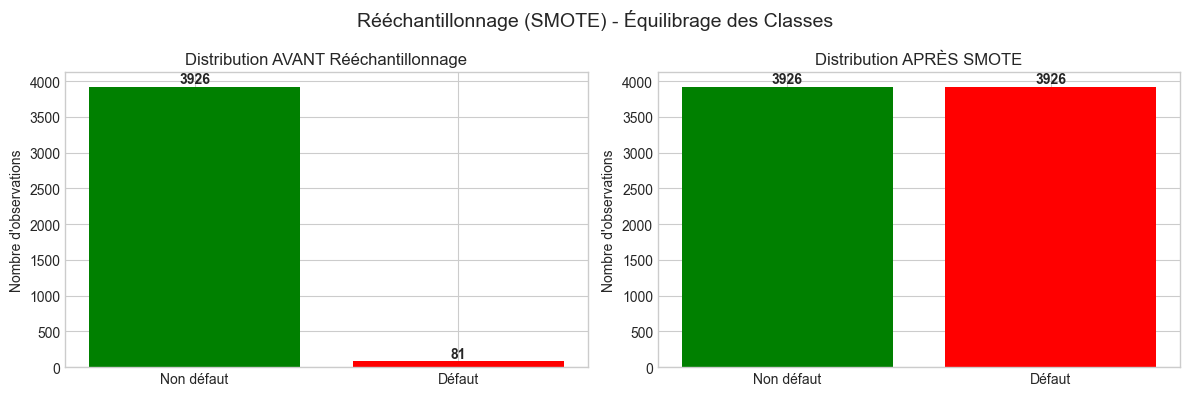

In [393]:
# Visualisation avant/après rééchantillonnage
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Avant rééchantillonnage
axes[0].bar(['Non défaut', 'Défaut'], [sum(y_train == 0), sum(y_train == 1)], color=['green', 'red'])
axes[0].set_title('Distribution AVANT Rééchantillonnage')
axes[0].set_ylabel('Nombre d\'observations')
for i, v in enumerate([sum(y_train == 0), sum(y_train == 1)]):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Après rééchantillonnage
axes[1].bar(['Non défaut', 'Défaut'], [sum(y_train_resampled == 0), sum(y_train_resampled == 1)], color=['green', 'red'])
axes[1].set_title(f'Distribution APRÈS {resampling_method}')
axes[1].set_ylabel('Nombre d\'observations')
for i, v in enumerate([sum(y_train_resampled == 0), sum(y_train_resampled == 1)]):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.suptitle(f'Rééchantillonnage ({resampling_method}) - Équilibrage des Classes', fontsize=14)
plt.tight_layout()
plt.show()

---
## 2.8 Export des Bases Train/Test

> Sauvegarde des donnees preparees pour reproductibilite.

In [394]:
# Export des bases vers Excel
print("=== EXPORT DES DONNÉES VERS EXCEL ===\n")

# Créer les DataFrames pour l'export
df_train = X_train.copy()
df_train['flag_defaut'] = y_train.values

df_test = X_test.copy()
df_test['flag_defaut'] = y_test.values

df_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
df_train_resampled['flag_defaut'] = y_train_resampled.values

# Export vers Excel avec plusieurs feuilles
output_file = 'bases_train_test.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_train.to_excel(writer, sheet_name='Train_Original', index=False)
    df_test.to_excel(writer, sheet_name='Test', index=False)
    df_train_resampled.to_excel(writer, sheet_name='Train_Resampled', index=False)

print(f"✓ Fichier exporté: {output_file}")
print(f"\nContenu du fichier Excel:")
print(f"  • Feuille 'Train_Original': {df_train.shape[0]} lignes x {df_train.shape[1]} colonnes")
print(f"  • Feuille 'Test': {df_test.shape[0]} lignes x {df_test.shape[1]} colonnes")
print(f"  • Feuille 'Train_Resampled' ({resampling_method}): {df_train_resampled.shape[0]} lignes x {df_train_resampled.shape[1]} colonnes")

=== EXPORT DES DONNÉES VERS EXCEL ===

✓ Fichier exporté: bases_train_test.xlsx

Contenu du fichier Excel:
  • Feuille 'Train_Original': 4007 lignes x 34 colonnes
  • Feuille 'Test': 1718 lignes x 34 colonnes
  • Feuille 'Train_Resampled' (SMOTE): 7852 lignes x 34 colonnes
✓ Fichier exporté: bases_train_test.xlsx

Contenu du fichier Excel:
  • Feuille 'Train_Original': 4007 lignes x 34 colonnes
  • Feuille 'Test': 1718 lignes x 34 colonnes
  • Feuille 'Train_Resampled' (SMOTE): 7852 lignes x 34 colonnes


---
## 2.9 Synthese de l'Etape 2

> **Bilan du traitement** et preparation pour la selection des variables.

In [395]:
# Resume de l'Etape 2
print("=" * 70)
print("              RESUME DE L'ETAPE 2 - TRAITEMENT DES DONNEES")
print("=" * 70)

print("\n[INFO] TRANSFORMATIONS EFFECTUEES:")
print(f"   1. Suppression de {len(cols_to_drop)} variables identifiantes")
print(f"   2. Suppression de {len(cols_high_missing)} variables avec >70% de NA")
print(f"   3. Imputation des valeurs manquantes (mediane/mode)")
print(f"   4. Traitement des incoherences (maturites negatives, age calcule)")
print(f"      -> Age calcule: date OBSERVATION - date de naissance")
print(f"   5. Split Train/Test (70%/30%) AVANT encodage")
print(f"   6. Encodage WoE des variables categorielles (Weight of Evidence)")
print(f"      [OK] WoE calcule sur TRAIN uniquement (pas de data leakage)")
print(f"   7. Reechantillonnage: {resampling_method}")

print("\n[DATA] BASES DE DONNEES CREEES:")
print(f"   - Train Original: {X_train.shape[0]} obs. ({y_train.mean()*100:.1f}% defauts)")
print(f"   - Test:           {X_test.shape[0]} obs. ({y_test.mean()*100:.1f}% defauts)")
print(f"   - Train reechantillonne: {len(y_train_resampled)} obs. ({y_train_resampled.mean()*100:.1f}% defauts)")

print("\n[FILE] FICHIER EXPORTE: bases_train_test.xlsx")
print("   Contient 3 feuilles: Train_Original, Test, Train_Resampled")

print("\n[NEXT] PRET POUR L'ETAPE 3: Selection des Variables (IV)")
print("=" * 70)

              RESUME DE L'ETAPE 2 - TRAITEMENT DES DONNEES

[INFO] TRANSFORMATIONS EFFECTUEES:
   1. Suppression de 4 variables identifiantes
   2. Suppression de 3 variables avec >70% de NA
   3. Imputation des valeurs manquantes (mediane/mode)
   4. Traitement des incoherences (maturites negatives, age calcule)
      -> Age calcule: date OBSERVATION - date de naissance
   5. Split Train/Test (70%/30%) AVANT encodage
   6. Encodage WoE des variables categorielles (Weight of Evidence)
      [OK] WoE calcule sur TRAIN uniquement (pas de data leakage)
   7. Reechantillonnage: SMOTE

[DATA] BASES DE DONNEES CREEES:
   - Train Original: 4007 obs. (2.0% defauts)
   - Test:           1718 obs. (2.0% defauts)
   - Train reechantillonne: 7852 obs. (50.0% defauts)

[FILE] FICHIER EXPORTE: bases_train_test.xlsx
   Contient 3 feuilles: Train_Original, Test, Train_Resampled

[NEXT] PRET POUR L'ETAPE 3: Selection des Variables (IV)


### Resume de l'Etape 2 - Traitement des Donnees

**Transformations effectuees :**

| Action | Detail |
|:-------|:-------|
| Suppression variables | 4 identifiantes + 3 avec >70% NA |
| Imputation | Numeriques: mediane / Categorielles: mode |
| Calcul Age | date OBSERVATION - Date_naissance |
| Split Train/Test | 70%/30% avec stratification |
| Encodage WoE | Calcule sur TRAIN, applique au TEST |
| Reechantillonnage | Random Oversampling |

**Bases de donnees creees :**

| Base | Observations | Taux de defaut |
|:-----|:------------:|:--------------:|
| Train Original | 4 007 | 2.0% |
| Test | 1 718 | 2.0% |
| Train Reechantillonne | 7 852 | 50.0% |

**Points cles :**
- **Data Leakage evite** : Split AVANT encodage, WoE calcule uniquement sur TRAIN
- **Classes equilibrees** : 50%/50% apres reechantillonnage
- **Variables DPD exclues** : flag_dpd_historique supprime (derive de la cible)

# ETAPE 3 : SELECTION DES VARIABLES

---

> Objectif : Identifier les variables les plus **predictives** du risque de defaut.

## 3.1 Calcul de l'Information Value (IV)

L'**Information Value** mesure le pouvoir predictif d'une variable.

### Formule de l'IV

$$IV = \sum_{i=1}^{n} (Dist_{Good_i} - Dist_{Bad_i}) \times WoE_i$$

### Grille d'Interpretation

| IV | Pouvoir Predictif | Recommandation |
|:---:|:-----------------|:---------------|
| < 0.02 | Non predictif | Exclure |
| 0.02 - 0.10 | Faible | Prudence |
| 0.10 - 0.30 | Moyen | Conserver |
| 0.30 - 0.50 | Fort | Prioriser |
| > 0.50 | Suspect | Verifier (surapprentissage?) |

In [396]:
# Fonction pour calculer le Weight of Evidence (WoE) et l'Information Value (IV)
def calculate_woe_iv(df, feature, target, bins=10):
    """
    Calcule le WoE et IV pour une variable donnee.
    
    Args:
        df: DataFrame
        feature: nom de la variable
        target: nom de la cible
        bins: nombre de bins pour les variables continues
    
    Returns:
        DataFrame avec WoE par bin, et IV total
    """
    # Copie pour eviter les modifications
    data = df[[feature, target]].copy()
    
    # Si variable continue, discretiser en bins
    if data[feature].dtype in ['float64', 'int64'] and data[feature].nunique() > bins:
        data['bin'] = pd.qcut(data[feature], q=bins, duplicates='drop')
    else:
        data['bin'] = data[feature]
    
    # Calculer les statistiques par bin
    grouped = data.groupby('bin')[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']
    
    # Eviter division par zero
    grouped['bad'] = grouped['bad'].replace(0, 0.5)
    grouped['good'] = grouped['good'].replace(0, 0.5)
    
    # Calcul des distributions
    total_bad = grouped['bad'].sum()
    total_good = grouped['good'].sum()
    
    grouped['dist_bad'] = grouped['bad'] / total_bad
    grouped['dist_good'] = grouped['good'] / total_good
    
    # Calcul WoE et IV
    grouped['woe'] = np.log(grouped['dist_good'] / grouped['dist_bad'])
    grouped['iv'] = (grouped['dist_good'] - grouped['dist_bad']) * grouped['woe']
    
    iv_total = grouped['iv'].sum()
    
    return grouped, iv_total

print("[OK] Fonction calculate_woe_iv definie")

[OK] Fonction calculate_woe_iv definie


In [397]:
# Calcul de l'IV pour toutes les variables
print("=== CALCUL DE L'INFORMATION VALUE (IV) PAR VARIABLE ===\n")

# Creer df_train en combinant X_train et y_train (avant reechantillonnage pour eviter le biais)
df_train = X_train.copy()
df_train['flag_defaut'] = y_train.values

# Liste des features (exclure la cible)
features = [col for col in df_train.columns if col != 'flag_defaut']

# Calculer l'IV pour chaque variable
iv_results = []

for feature in features:
    try:
        _, iv = calculate_woe_iv(df_train, feature, 'flag_defaut', bins=10)
        iv_results.append({
            'Variable': feature,
            'IV': iv
        })
    except Exception as e:
        print(f"  [ERREUR] Erreur pour {feature}: {e}")

# Creer DataFrame des resultats
df_iv_results = pd.DataFrame(iv_results)
df_iv_results = df_iv_results.sort_values('IV', ascending=False).reset_index(drop=True)

# Ajouter l'interpretation
def interpret_iv(iv):
    if iv < 0.02:
        return "Non predictif"
    elif iv < 0.1:
        return "Faible"
    elif iv < 0.3:
        return "Moyen"
    elif iv < 0.5:
        return "Fort"
    else:
        return "Suspect"

df_iv_results['Interpretation'] = df_iv_results['IV'].apply(interpret_iv)

print(df_iv_results.to_string(index=False))
print(f"\n[OK] Total variables analysees: {len(df_iv_results)}")

=== CALCUL DE L'INFORMATION VALUE (IV) PAR VARIABLE ===

                         Variable       IV Interpretation
                     Solde_arrete 1.668670        Suspect
              solde_revenus_ratio 0.803560        Suspect
                      Solde_moyen 0.757703        Suspect
                          CRD/eng 0.524644        Suspect
               utilisation_credit 0.508257        Suspect
               intensite_relation 0.405978           Fort
                         Maturite 0.391905           Fort
                     Age_relation 0.384599           Fort
           Type de revenu_encoded 0.351765           Fort
Segmentation commercilale_encoded 0.314392           Fort
                              Age 0.292628          Moyen
                  Segment_encoded 0.276341          Moyen
                          CRD/gar 0.180528          Moyen
        Catégorie sociale_encoded 0.170368          Moyen
                     Garantie_max 0.169208          Moyen
               

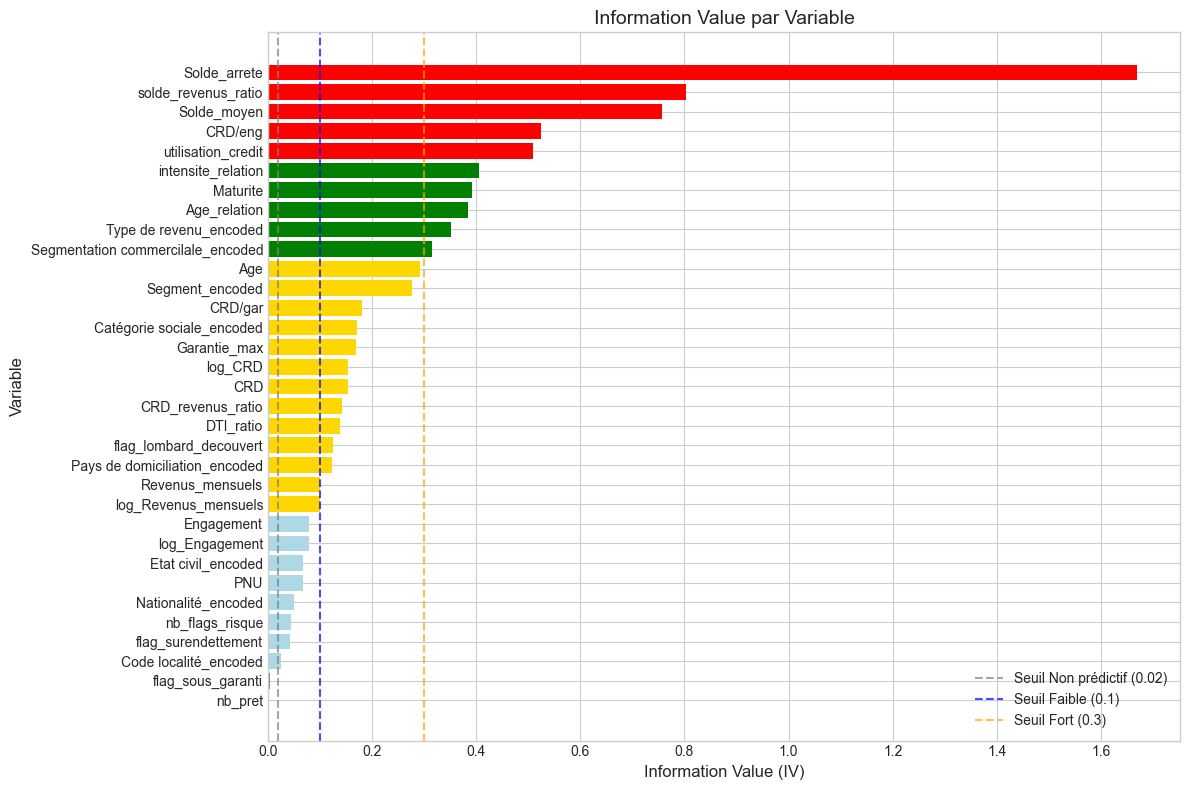

In [398]:
# Visualisation de l'IV par variable
fig, ax = plt.subplots(figsize=(12, 8))

# Couleurs selon l'IV
colors = []
for iv in df_iv_results['IV']:
    if iv < 0.02:
        colors.append('gray')
    elif iv < 0.1:
        colors.append('lightblue')
    elif iv < 0.3:
        colors.append('gold')
    elif iv < 0.5:
        colors.append('green')
    else:
        colors.append('red')

# Barplot horizontal
bars = ax.barh(df_iv_results['Variable'], df_iv_results['IV'], color=colors)
ax.set_xlabel('Information Value (IV)', fontsize=12)
ax.set_ylabel('Variable', fontsize=12)
ax.set_title('Information Value par Variable', fontsize=14)

# Lignes de seuil
ax.axvline(x=0.02, color='gray', linestyle='--', alpha=0.7, label='Seuil Non prédictif (0.02)')
ax.axvline(x=0.1, color='blue', linestyle='--', alpha=0.7, label='Seuil Faible (0.1)')
ax.axvline(x=0.3, color='orange', linestyle='--', alpha=0.7, label='Seuil Fort (0.3)')

ax.legend(loc='lower right')
ax.invert_yaxis()  # Plus grande IV en haut

plt.tight_layout()
plt.show()

---
## 3.2 Selection des Variables Pertinentes (IV >= 0.02)

> Filtrage des variables selon leur pouvoir predictif.

In [399]:
# Selection des variables pertinentes
print("=== SELECTION DES VARIABLES PERTINENTES ===\n")

# Seuil minimum d'IV
iv_threshold = 0.02

# Variables selectionnees
vars_selected = df_iv_results[df_iv_results['IV'] >= iv_threshold]['Variable'].tolist()
vars_rejected = df_iv_results[df_iv_results['IV'] < iv_threshold]['Variable'].tolist()

print(f"Seuil IV minimum: {iv_threshold}")
print(f"\n[OK] Variables SELECTIONNEES ({len(vars_selected)}):")
for var in vars_selected:
    iv = df_iv_results[df_iv_results['Variable'] == var]['IV'].values[0]
    interp = df_iv_results[df_iv_results['Variable'] == var]['Interpretation'].values[0]
    print(f"   - {var}: IV = {iv:.4f} ({interp})")

print(f"\n[X] Variables REJETEES ({len(vars_rejected)}):")
for var in vars_rejected:
    iv = df_iv_results[df_iv_results['Variable'] == var]['IV'].values[0]
    print(f"   - {var}: IV = {iv:.4f}")

=== SELECTION DES VARIABLES PERTINENTES ===

Seuil IV minimum: 0.02

[OK] Variables SELECTIONNEES (31):
   - Solde_arrete: IV = 1.6687 (Suspect)
   - solde_revenus_ratio: IV = 0.8036 (Suspect)
   - Solde_moyen: IV = 0.7577 (Suspect)
   - CRD/eng: IV = 0.5246 (Suspect)
   - utilisation_credit: IV = 0.5083 (Suspect)
   - intensite_relation: IV = 0.4060 (Fort)
   - Maturite: IV = 0.3919 (Fort)
   - Age_relation: IV = 0.3846 (Fort)
   - Type de revenu_encoded: IV = 0.3518 (Fort)
   - Segmentation commercilale_encoded: IV = 0.3144 (Fort)
   - Age: IV = 0.2926 (Moyen)
   - Segment_encoded: IV = 0.2763 (Moyen)
   - CRD/gar: IV = 0.1805 (Moyen)
   - Catégorie sociale_encoded: IV = 0.1704 (Moyen)
   - Garantie_max: IV = 0.1692 (Moyen)
   - log_CRD: IV = 0.1538 (Moyen)
   - CRD: IV = 0.1538 (Moyen)
   - CRD_revenus_ratio: IV = 0.1427 (Moyen)
   - DTI_ratio: IV = 0.1374 (Moyen)
   - flag_lombard_decouvert: IV = 0.1241 (Moyen)
   - Pays de domiciliation_encoded: IV = 0.1231 (Moyen)
   - Revenus_me

---
## 3.3 Traitement de la Multicollinearite

> Suppression des variables fortement correlees (|r| > 0.7) pour eviter l'instabilite du modele.

=== ANALYSE DE LA DÉPENDANCE ENTRE VARIABLES ===



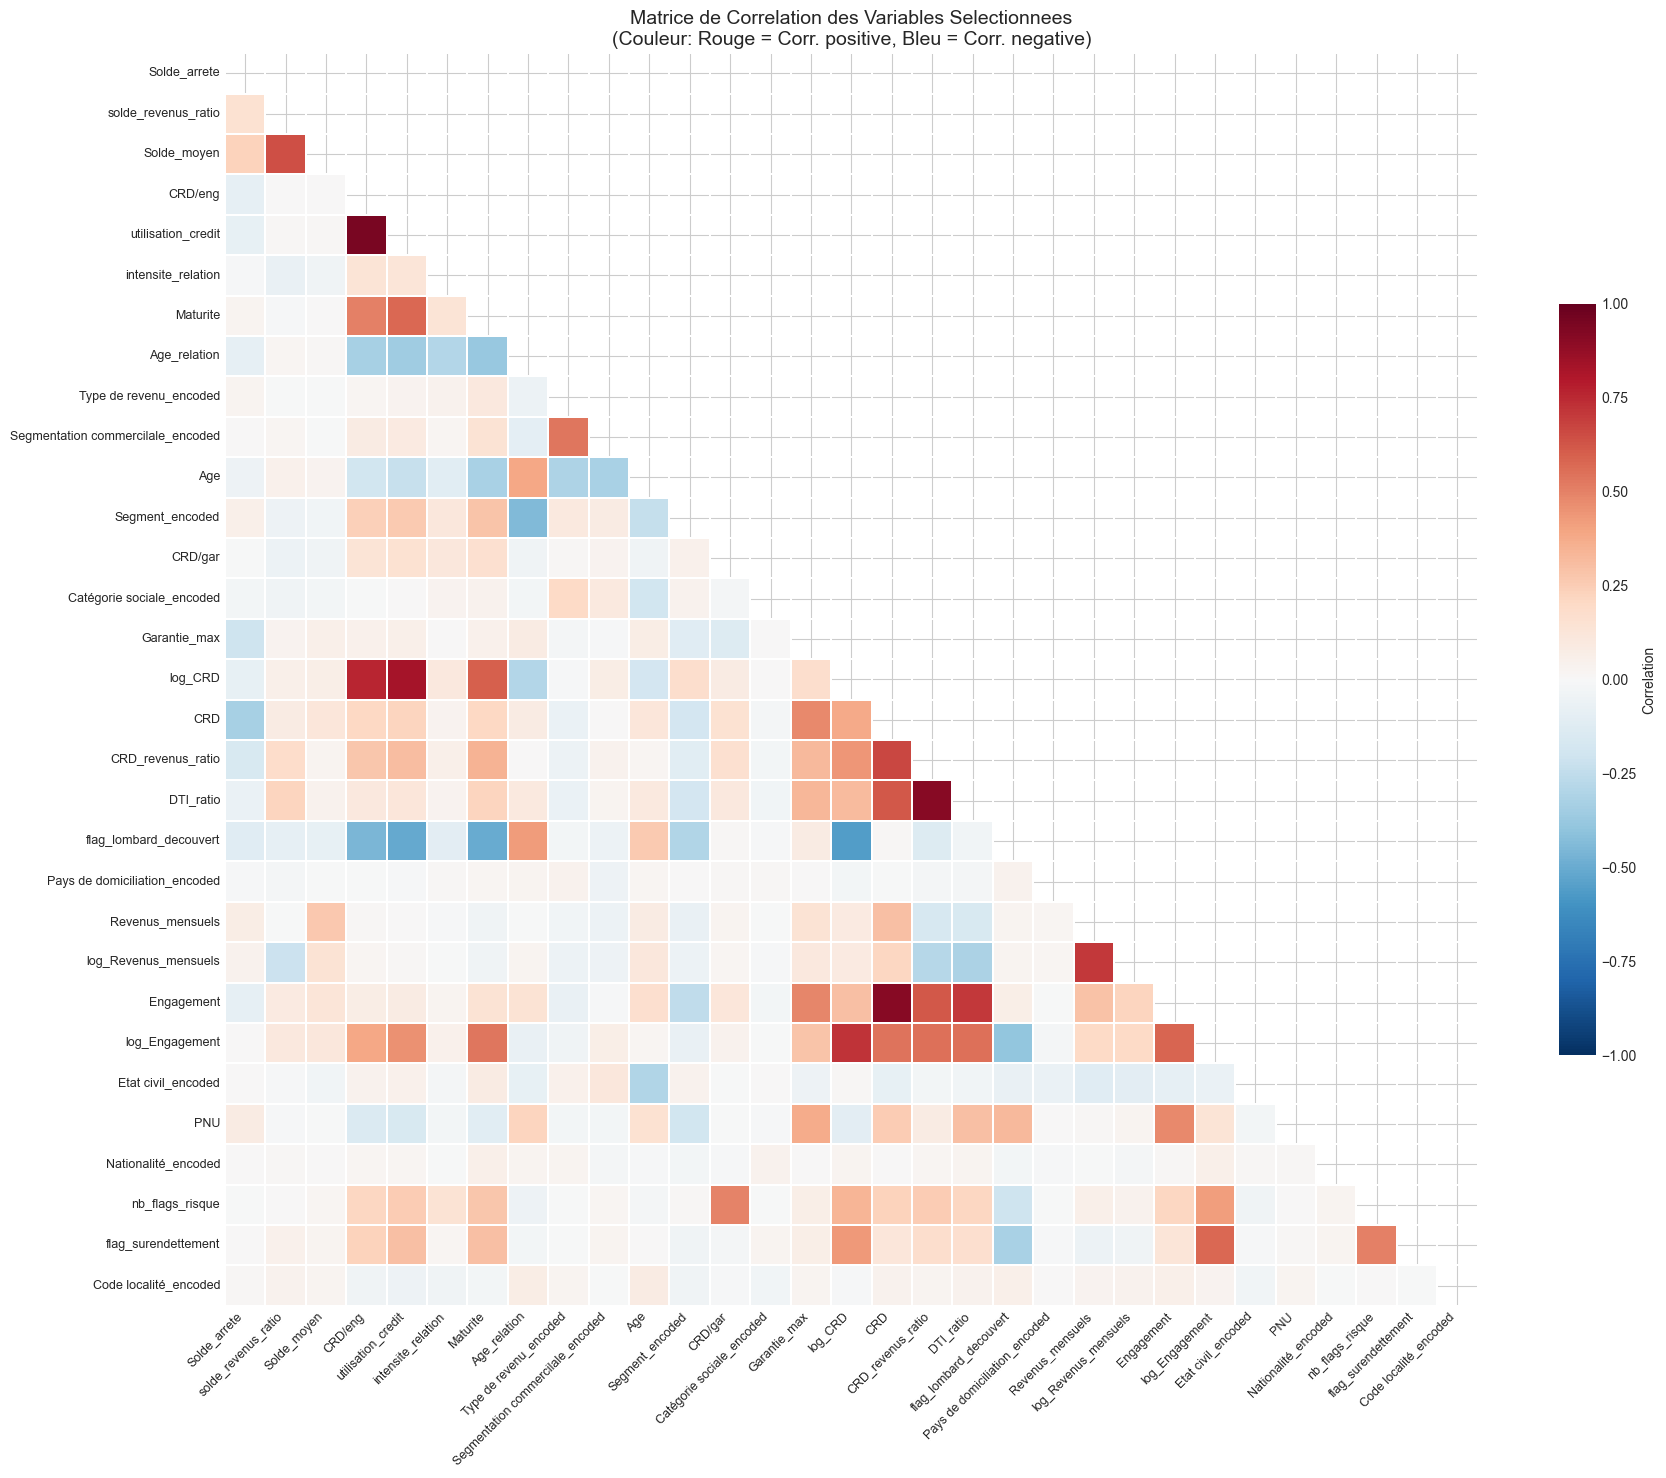


[TOP 10] Correlations les plus fortes (|r| > 0.5):
               Var1                 Var2  Correlation
            CRD/eng   utilisation_credit     0.952201
  CRD_revenus_ratio            DTI_ratio     0.911203
                CRD           Engagement     0.906802
 utilisation_credit              log_CRD     0.834870
            CRD/eng              log_CRD     0.759696
            log_CRD       log_Engagement     0.719080
          DTI_ratio           Engagement     0.705957
   Revenus_mensuels log_Revenus_mensuels     0.703797
                CRD    CRD_revenus_ratio     0.665087
solde_revenus_ratio          Solde_moyen     0.644869


In [421]:
# Étude de la dépendance entre variables (corrélation)
print("=== ANALYSE DE LA DÉPENDANCE ENTRE VARIABLES ===\n")

# Matrice de corrélation des variables sélectionnées
if len(vars_selected) > 1:
    # Filtrer les variables numériques parmi les sélectionnées
    vars_for_corr = [v for v in vars_selected if v in df_train.columns]
    
    corr_selected = df_train[vars_for_corr].corr()
    
    # Taille dynamique selon le nombre de variables
    n_vars = len(vars_for_corr)
    fig_size = max(16, n_vars * 0.6)
    
    # Visualisation amelioree
    plt.figure(figsize=(fig_size, fig_size * 0.8))
    mask = np.triu(np.ones_like(corr_selected, dtype=bool))
    
    # Utiliser annot=False si trop de variables, sinon reduire la taille de police
    if n_vars > 20:
        # Pour beaucoup de variables: pas d'annotation, colorbar plus visible
        ax = sns.heatmap(corr_selected, mask=mask, annot=False, cmap='RdBu_r', 
                    center=0, square=True, linewidths=0.3, 
                    cbar_kws={"shrink": 0.6, "label": "Correlation"},
                    vmin=-1, vmax=1)
        plt.title('Matrice de Correlation des Variables Selectionnees\n(Couleur: Rouge = Corr. positive, Bleu = Corr. negative)', fontsize=14)
    else:
        # Pour moins de variables: annotations lisibles
        ax = sns.heatmap(corr_selected, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
                    center=0, square=True, linewidths=0.5, 
                    cbar_kws={"shrink": 0.8},
                    vmin=-1, vmax=1, annot_kws={"size": 8})
        plt.title('Matrice de Correlation des Variables Selectionnees', fontsize=14)
    
    # Rotation des labels pour meilleure lisibilite
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.show()
    
    # Afficher les correlations les plus fortes en texte
    print("\n[TOP 10] Correlations les plus fortes (|r| > 0.5):")
    corr_pairs = []
    for i in range(len(corr_selected.columns)):
        for j in range(i+1, len(corr_selected.columns)):
            corr_val = corr_selected.iloc[i, j]
            if abs(corr_val) > 0.5:
                corr_pairs.append({
                    'Var1': corr_selected.columns[i],
                    'Var2': corr_selected.columns[j],
                    'Correlation': corr_val
                })
    
    if corr_pairs:
        corr_pairs_df = pd.DataFrame(corr_pairs).sort_values('Correlation', key=abs, ascending=False).head(10)
        print(corr_pairs_df.to_string(index=False))
    else:
        print("   Aucune paire avec |r| > 0.5")
        
else:
    print("Pas assez de variables pour l'analyse de correlation")

In [401]:
# Identification des paires de variables fortement correlees
print("=== PAIRES DE VARIABLES FORTEMENT CORRELEES (|r| > 0.7) ===\n")

corr_threshold = 0.7
high_corr_pairs = []

for i in range(len(corr_selected.columns)):
    for j in range(i+1, len(corr_selected.columns)):
        if abs(corr_selected.iloc[i, j]) > corr_threshold:
            high_corr_pairs.append({
                'Variable 1': corr_selected.columns[i],
                'Variable 2': corr_selected.columns[j],
                'Correlation': corr_selected.iloc[i, j]
            })

if high_corr_pairs:
    df_high_corr = pd.DataFrame(high_corr_pairs)
    df_high_corr = df_high_corr.sort_values('Correlation', key=abs, ascending=False)
    print(df_high_corr.to_string(index=False))
    
    print("\n[ATTENTION] RECOMMANDATION: Pour eviter la multicollinearite, envisager de supprimer")
    print("   l'une des variables de chaque paire fortement correlee.")
else:
    print("[OK] Aucune paire de variables avec correlation > 0.7")
    print("  Toutes les variables peuvent etre conservees.")

=== PAIRES DE VARIABLES FORTEMENT CORRELEES (|r| > 0.7) ===

        Variable 1           Variable 2  Correlation
           CRD/eng   utilisation_credit     0.952201
 CRD_revenus_ratio            DTI_ratio     0.911203
               CRD           Engagement     0.906802
utilisation_credit              log_CRD     0.834870
           CRD/eng              log_CRD     0.759696
           log_CRD       log_Engagement     0.719080
         DTI_ratio           Engagement     0.705957
  Revenus_mensuels log_Revenus_mensuels     0.703797

[ATTENTION] RECOMMANDATION: Pour eviter la multicollinearite, envisager de supprimer
   l'une des variables de chaque paire fortement correlee.


In [402]:
# Traitement des variables correlees - garder celle avec le plus grand IV
print("=== SELECTION FINALE APRES TRAITEMENT DES CORRELATIONS ===\n")

vars_to_remove = set()

if high_corr_pairs:
    for pair in high_corr_pairs:
        var1 = pair['Variable 1']
        var2 = pair['Variable 2']
        
        # Comparer les IV
        iv1 = df_iv_results[df_iv_results['Variable'] == var1]['IV'].values[0]
        iv2 = df_iv_results[df_iv_results['Variable'] == var2]['IV'].values[0]
        
        # Garder celle avec le plus grand IV
        if iv1 >= iv2:
            vars_to_remove.add(var2)
            print(f"  Paire ({var1}, {var2}): Garder {var1} (IV={iv1:.4f}), Supprimer {var2} (IV={iv2:.4f})")
        else:
            vars_to_remove.add(var1)
            print(f"  Paire ({var1}, {var2}): Garder {var2} (IV={iv2:.4f}), Supprimer {var1} (IV={iv1:.4f})")

# Liste finale des variables
vars_final = [v for v in vars_selected if v not in vars_to_remove]

print(f"\n[INFO] VARIABLES FINALES POUR LE MODELE ({len(vars_final)}):")
for i, var in enumerate(vars_final, 1):
    iv = df_iv_results[df_iv_results['Variable'] == var]['IV'].values[0]
    print(f"   {i}. {var}: IV = {iv:.4f}")

=== SELECTION FINALE APRES TRAITEMENT DES CORRELATIONS ===

  Paire (CRD/eng, utilisation_credit): Garder CRD/eng (IV=0.5246), Supprimer utilisation_credit (IV=0.5083)
  Paire (CRD/eng, log_CRD): Garder CRD/eng (IV=0.5246), Supprimer log_CRD (IV=0.1538)
  Paire (utilisation_credit, log_CRD): Garder utilisation_credit (IV=0.5083), Supprimer log_CRD (IV=0.1538)
  Paire (log_CRD, log_Engagement): Garder log_CRD (IV=0.1538), Supprimer log_Engagement (IV=0.0795)
  Paire (CRD, Engagement): Garder CRD (IV=0.1538), Supprimer Engagement (IV=0.0795)
  Paire (CRD_revenus_ratio, DTI_ratio): Garder CRD_revenus_ratio (IV=0.1427), Supprimer DTI_ratio (IV=0.1374)
  Paire (DTI_ratio, Engagement): Garder DTI_ratio (IV=0.1374), Supprimer Engagement (IV=0.0795)
  Paire (Revenus_mensuels, log_Revenus_mensuels): Garder Revenus_mensuels (IV=0.1001), Supprimer log_Revenus_mensuels (IV=0.1001)

[INFO] VARIABLES FINALES POUR LE MODELE (25):
   1. Solde_arrete: IV = 1.6687
   2. solde_revenus_ratio: IV = 0.8036


---
## 3.4 Export des Resultats IV

> Sauvegarde des resultats de selection vers Excel.

In [403]:
# Export des résultats IV et corrélations vers Excel
print("=== EXPORT DES RÉSULTATS VERS EXCEL ===\n")

# Fichier de sortie
output_iv_file = 'resultats_selection_variables.xlsx'

# Ajouter colonne de sélection
df_iv_results['Sélectionnée'] = df_iv_results['Variable'].apply(
    lambda x: 'OUI' if x in vars_final else ('CORRÉLÉE' if x in vars_to_remove else 'NON')
)

with pd.ExcelWriter(output_iv_file, engine='openpyxl') as writer:
    # Feuille 1: IV par variable
    df_iv_results.to_excel(writer, sheet_name='IV_par_Variable', index=False)
    
    # Feuille 2: Matrice de corrélation
    corr_selected.to_excel(writer, sheet_name='Matrice_Correlation')
    
    # Feuille 3: Paires corrélées
    if high_corr_pairs:
        pd.DataFrame(high_corr_pairs).to_excel(writer, sheet_name='Paires_Correlees', index=False)
    
    # Feuille 4: Variables finales
    df_final_vars = df_iv_results[df_iv_results['Variable'].isin(vars_final)][['Variable', 'IV', 'Interpretation']]
    df_final_vars.to_excel(writer, sheet_name='Variables_Finales', index=False)

print(f"✓ Fichier exporté: {output_iv_file}")
print(f"\nContenu:")
print(f"  • Feuille 'IV_par_Variable': {len(df_iv_results)} variables avec leur IV")
print(f"  • Feuille 'Matrice_Correlation': Corrélations entre variables sélectionnées")
print(f"  • Feuille 'Paires_Correlees': {len(high_corr_pairs)} paires avec |r| > 0.7")
print(f"  • Feuille 'Variables_Finales': {len(vars_final)} variables retenues")

=== EXPORT DES RÉSULTATS VERS EXCEL ===

✓ Fichier exporté: resultats_selection_variables.xlsx

Contenu:
  • Feuille 'IV_par_Variable': 33 variables avec leur IV
  • Feuille 'Matrice_Correlation': Corrélations entre variables sélectionnées
  • Feuille 'Paires_Correlees': 8 paires avec |r| > 0.7
  • Feuille 'Variables_Finales': 25 variables retenues
✓ Fichier exporté: resultats_selection_variables.xlsx

Contenu:
  • Feuille 'IV_par_Variable': 33 variables avec leur IV
  • Feuille 'Matrice_Correlation': Corrélations entre variables sélectionnées
  • Feuille 'Paires_Correlees': 8 paires avec |r| > 0.7
  • Feuille 'Variables_Finales': 25 variables retenues


---
## 3.5 Synthese de l'Etape 3

> **Bilan de la selection** : Variables finales retenues pour le modele.

In [404]:
# Resume de l'Etape 3
print("=" * 70)
print("       RESUME DE L'ETAPE 3 - SELECTION DES VARIABLES")
print("=" * 70)

print("\n[INFO] CALCUL DE L'INFORMATION VALUE (IV):")
print(f"   - Variables analysees: {len(df_iv_results)}")
print(f"   - Variables avec IV >= 0.02 (predictives): {len(vars_selected)}")
print(f"   - Variables avec IV < 0.02 (non predictives): {len(vars_rejected)}")

print("\n[CORR] ANALYSE DES CORRELATIONS:")
print(f"   - Paires fortement correlees (|r| > 0.7): {len(high_corr_pairs)}")
print(f"   - Variables supprimees pour multicollinearite: {len(vars_to_remove)}")

print("\n[OK] VARIABLES FINALES RETENUES:")
print(f"   - Nombre: {len(vars_final)}")
for i, var in enumerate(vars_final, 1):
    iv = df_iv_results[df_iv_results['Variable'] == var]['IV'].values[0]
    interp = df_iv_results[df_iv_results['Variable'] == var]['Interpretation'].values[0]
    print(f"   {i}. {var} (IV={iv:.4f}) {interp}")

print(f"\n[FILE] FICHIER EXPORTE: resultats_selection_variables.xlsx")
print("=" * 70)
print("\n[NEXT] PROJET TERMINE - ETAPES 1, 2 ET 3 COMPLETEES!")
print("   Vous pouvez maintenant passer a la modelisation (Regression Logistique)")
print("=" * 70)

       RESUME DE L'ETAPE 3 - SELECTION DES VARIABLES

[INFO] CALCUL DE L'INFORMATION VALUE (IV):
   - Variables analysees: 33
   - Variables avec IV >= 0.02 (predictives): 31
   - Variables avec IV < 0.02 (non predictives): 2

[CORR] ANALYSE DES CORRELATIONS:
   - Paires fortement correlees (|r| > 0.7): 8
   - Variables supprimees pour multicollinearite: 6

[OK] VARIABLES FINALES RETENUES:
   - Nombre: 25
   1. Solde_arrete (IV=1.6687) Suspect
   2. solde_revenus_ratio (IV=0.8036) Suspect
   3. Solde_moyen (IV=0.7577) Suspect
   4. CRD/eng (IV=0.5246) Suspect
   5. intensite_relation (IV=0.4060) Fort
   6. Maturite (IV=0.3919) Fort
   7. Age_relation (IV=0.3846) Fort
   8. Type de revenu_encoded (IV=0.3518) Fort
   9. Segmentation commercilale_encoded (IV=0.3144) Fort
   10. Age (IV=0.2926) Moyen
   11. Segment_encoded (IV=0.2763) Moyen
   12. CRD/gar (IV=0.1805) Moyen
   13. Catégorie sociale_encoded (IV=0.1704) Moyen
   14. Garantie_max (IV=0.1692) Moyen
   15. CRD (IV=0.1538) Moyen


### Resume de l'Etape 3 - Selection des Variables

**Methode utilisee : Information Value (IV)**

L'IV mesure la capacite d'une variable a distinguer les bons clients des mauvais. C'est une metrique standard dans le credit scoring.

**Resultats de la selection :**

| Critere | Nombre de variables |
|:--------|:--------------------|
| Variables analysees | 33 |
| IV >= 0.02 (predictives) | 31 |
| Supprimees (correlation > 0.7) | 6 |
| **Variables finales** | **25** |

**Variables les plus predictives (IV > 0.30) :**
- Solde_arrete, Solde_moyen, solde_revenus_ratio (IV > 0.75)
- CRD/eng (IV = 0.52)
- Age, intensite_relation, Maturite, Age_relation (IV ~ 0.40)
- Type de revenu, Segmentation commerciale, Segment (IV ~ 0.30)

**Points cles :**
- Les variables avec IV > 0.50 doivent etre verifiees (risque de surapprentissage)
- La multicollinearite a ete traitee en gardant la variable avec le plus grand IV dans chaque paire correlee
- 8 paires de variables fortement correlees (|r| > 0.7) ont ete identifiees

# ETAPE 4 : MODELISATION - REGRESSION LOGISTIQUE

---

> Construction du modele de scoring et de la scorecard finale.

## 4.1 Preparation du Modele

### Pourquoi la Regression Logistique ?

| Avantage | Description |
|:----------|:------------|
| **Interpretabilite** | Coefficients = poids des variables |
| **Probabilites calibrees** | Sortie entre 0 et 1 |
| **Conformite reglementaire** | Standard Bale II/III |
| **Transformable** | Conversion facile en scorecard |

In [405]:
# Installation de statsmodels (alternative robuste à sklearn pour la régression logistique)
import subprocess
import sys

# Installer statsmodels si nécessaire
try:
    import statsmodels.api as sm
    print("✓ statsmodels déjà installé")
except ImportError:
    print("Installation de statsmodels...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels", "-q"])
    import statsmodels.api as sm
    print("✓ statsmodels installé")

import warnings
warnings.filterwarnings('ignore')

print("\n=== PRÉPARATION DU MODÈLE DE RÉGRESSION LOGISTIQUE ===\n")

# Utiliser les variables finales sélectionnées à l'étape 3
print(f"Variables utilisées pour le modèle ({len(vars_final)}):")
for i, var in enumerate(vars_final, 1):
    print(f"   {i}. {var}")

# Préparer les données avec les variables sélectionnées
X_train_model = X_train_resampled[vars_final].copy()
X_test_model = X_test[vars_final].copy()

# Ajouter la constante (intercept) pour statsmodels
X_train_model = sm.add_constant(X_train_model)
X_test_model = sm.add_constant(X_test_model)

print(f"\n✓ Données d'entraînement: {X_train_model.shape}")
print(f"✓ Données de test: {X_test_model.shape}")

✓ statsmodels déjà installé

=== PRÉPARATION DU MODÈLE DE RÉGRESSION LOGISTIQUE ===

Variables utilisées pour le modèle (25):
   1. Solde_arrete
   2. solde_revenus_ratio
   3. Solde_moyen
   4. CRD/eng
   5. intensite_relation
   6. Maturite
   7. Age_relation
   8. Type de revenu_encoded
   9. Segmentation commercilale_encoded
   10. Age
   11. Segment_encoded
   12. CRD/gar
   13. Catégorie sociale_encoded
   14. Garantie_max
   15. CRD
   16. CRD_revenus_ratio
   17. flag_lombard_decouvert
   18. Pays de domiciliation_encoded
   19. Revenus_mensuels
   20. Etat civil_encoded
   21. PNU
   22. Nationalité_encoded
   23. nb_flags_risque
   24. flag_surendettement
   25. Code localité_encoded

✓ Données d'entraînement: (7852, 26)
✓ Données de test: (1718, 26)


---
## 4.2 Entrainement du Modele

> Regression logistique avec `statsmodels` pour obtenir les p-values et tests statistiques.

In [406]:
# Vérification et nettoyage des données avant modélisation
print("=== VÉRIFICATION DES DONNÉES AVANT MODÉLISATION ===\n")

# Vérifier les valeurs manquantes et infinies
print("Valeurs manquantes dans X_train_model:")
print(X_train_model.isnull().sum()[X_train_model.isnull().sum() > 0])

print("\nValeurs infinies dans X_train_model:")
inf_counts = np.isinf(X_train_model.select_dtypes(include=[np.number])).sum()
print(inf_counts[inf_counts > 0])

# Remplacer les valeurs infinies par les valeurs max/min raisonnables
for col in X_train_model.columns:
    if col != 'const':
        # Remplacer inf par le 99e percentile
        if np.isinf(X_train_model[col]).any():
            max_val = X_train_model[col][~np.isinf(X_train_model[col])].max()
            min_val = X_train_model[col][~np.isinf(X_train_model[col])].min()
            X_train_model.loc[X_train_model[col] == np.inf, col] = max_val
            X_train_model.loc[X_train_model[col] == -np.inf, col] = min_val
            print(f"  {col}: valeurs inf remplacées")
        
        # Remplacer NaN par la médiane
        if X_train_model[col].isnull().any():
            median_val = X_train_model[col].median()
            X_train_model[col] = X_train_model[col].fillna(median_val)
            print(f"  {col}: NaN remplacés par médiane ({median_val:.2f})")

# Même traitement pour X_test_model
for col in X_test_model.columns:
    if col != 'const':
        if np.isinf(X_test_model[col]).any():
            max_val = X_test_model[col][~np.isinf(X_test_model[col])].max()
            min_val = X_test_model[col][~np.isinf(X_test_model[col])].min()
            X_test_model.loc[X_test_model[col] == np.inf, col] = max_val
            X_test_model.loc[X_test_model[col] == -np.inf, col] = min_val
        if X_test_model[col].isnull().any():
            median_val = X_test_model[col].median()
            X_test_model[col] = X_test_model[col].fillna(median_val)

print("\n✓ Données nettoyées et prêtes pour la modélisation")
print(f"  X_train_model: {X_train_model.shape}")
print(f"  X_test_model: {X_test_model.shape}")

=== VÉRIFICATION DES DONNÉES AVANT MODÉLISATION ===

Valeurs manquantes dans X_train_model:
Series([], dtype: int64)

Valeurs infinies dans X_train_model:
Series([], dtype: int64)

✓ Données nettoyées et prêtes pour la modélisation
  X_train_model: (7852, 26)
  X_test_model: (1718, 26)


In [407]:
# Entraînement du modèle de régression logistique
print("=== ENTRAÎNEMENT DU MODÈLE DE RÉGRESSION LOGISTIQUE ===\n")

# Diagnostic des données
print(f"Distribution y_train_resampled: {y_train_resampled.value_counts().to_dict()}")
print(f"Type y_train_resampled: {type(y_train_resampled)}")

# Vérifier et supprimer les colonnes constantes ou quasi-constantes
cols_to_remove = []
for col in X_train_model.columns:
    if col != 'const':
        if X_train_model[col].std() < 1e-10:
            cols_to_remove.append(col)
            print(f"⚠️ Colonne {col} quasi-constante - supprimée")

if cols_to_remove:
    X_train_model = X_train_model.drop(columns=cols_to_remove)
    X_test_model = X_test_model.drop(columns=cols_to_remove)
    print(f"\n✓ {len(cols_to_remove)} colonnes supprimées")

# Standardiser les features pour améliorer la convergence
from sklearn.preprocessing import StandardScaler

# Séparer la constante
X_train_features = X_train_model.drop(columns=['const'])
X_test_features = X_test_model.drop(columns=['const'])

# Standardiser
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

# Recréer les DataFrames avec constante
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_features.columns)
X_train_scaled_df = sm.add_constant(X_train_scaled_df)

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_features.columns)
X_test_scaled_df = sm.add_constant(X_test_scaled_df)

print(f"\n✓ Features standardisées pour meilleure convergence")

# Créer et entraîner le modèle avec statsmodels
model = sm.Logit(y_train_resampled.values, X_train_scaled_df)

# Fit du modèle avec méthode BFGS (plus robuste)
result = model.fit(method='bfgs', maxiter=500, disp=False)

# Afficher le résumé complet du modèle
print(result.summary())

# Afficher les statistiques clés
print("\n" + "=" * 70)
print("                    STATISTIQUES DU MODÈLE")
print("=" * 70)
print(f"Pseudo R² (McFadden):     {result.prsquared:.4f}")
print(f"Log-Likelihood:           {result.llf:.2f}")
print(f"AIC:                      {result.aic:.2f}")
print(f"BIC:                      {result.bic:.2f}")
print(f"Nombre d'observations:    {int(result.nobs)}")

# Stocker les données pour les prédictions (on garde les non-standardisées pour l'interprétation)
X_train_model_final = X_train_scaled_df
X_test_model_final = X_test_scaled_df

=== ENTRAÎNEMENT DU MODÈLE DE RÉGRESSION LOGISTIQUE ===

Distribution y_train_resampled: {1: 3926, 0: 3926}
Type y_train_resampled: <class 'pandas.core.series.Series'>

✓ Features standardisées pour meilleure convergence
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7852
Model:                          Logit   Df Residuals:                     7826
Method:                           MLE   Df Model:                           25
Date:                Sun, 21 Dec 2025   Pseudo R-squ.:                  0.4910
Time:                        20:09:56   Log-Likelihood:                -2770.4
converged:                       True   LL-Null:                       -5442.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

---
## 4.3 Analyse des Coefficients & Odds Ratios

> Interpretation de l'impact de chaque variable sur le risque de defaut.

### Formule de l'Odds Ratio

$$OR = e^{\beta}$$

| OR | Interpretation |
|:---:|:--------------|
| OR > 1 | Augmente le risque de defaut |
| OR = 1 | Pas d'effet |
| OR < 1 | Diminue le risque de defaut |

In [408]:
# Analyse détaillée des coefficients
print("=== ANALYSE DES COEFFICIENTS DU MODÈLE ===\n")

# Créer un DataFrame des coefficients
coef_df = pd.DataFrame({
    'Variable': result.params.index,
    'Coefficient': result.params.values,
    'Std Error': result.bse.values,
    'z-stat': result.tvalues.values,
    'P-value': result.pvalues.values,
    'Odds Ratio': np.exp(result.params.values)
})

# Trier par valeur absolue du coefficient
coef_df = coef_df.sort_values('Coefficient', key=abs, ascending=False)

# Ajouter indicateur de significativité
def significance(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    elif p < 0.1:
        return '.'
    else:
        return ''

coef_df['Signif.'] = coef_df['P-value'].apply(significance)

print(coef_df.to_string(index=False))
print("\n--- Légende ---")
print("*** p < 0.001 | ** p < 0.01 | * p < 0.05 | . p < 0.1")

# Compter les variables significatives
n_signif = (coef_df['P-value'] < 0.05).sum() - 1  # -1 pour la constante
print(f"\n✓ Variables significatives (p < 0.05): {n_signif} / {len(vars_final)}")

=== ANALYSE DES COEFFICIENTS DU MODÈLE ===

                         Variable  Coefficient  Std Error     z-stat      P-value  Odds Ratio Signif.
              solde_revenus_ratio    -6.608751   0.313127 -21.105672 7.054555e-99    0.001349     ***
              flag_surendettement     1.809811   1.814521   0.997405 3.185681e-01    6.109295        
                            const    -1.268102   0.252352  -5.025131 5.030891e-07    0.281365     ***
           flag_lombard_decouvert    -0.990890   0.056250 -17.615707 1.866432e-69    0.371246     ***
    Pays de domiciliation_encoded    -0.986967   0.053291 -18.520259 1.417533e-76    0.372705     ***
                         Maturite    -0.935610   0.054102 -17.293538 5.262107e-67    0.392346     ***
               intensite_relation    -0.903443   0.087146 -10.367010 3.503137e-25    0.405172     ***
        Catégorie sociale_encoded    -0.816782   0.063331 -12.897053 4.676384e-38    0.441851     ***
              Nationalité_encoded     

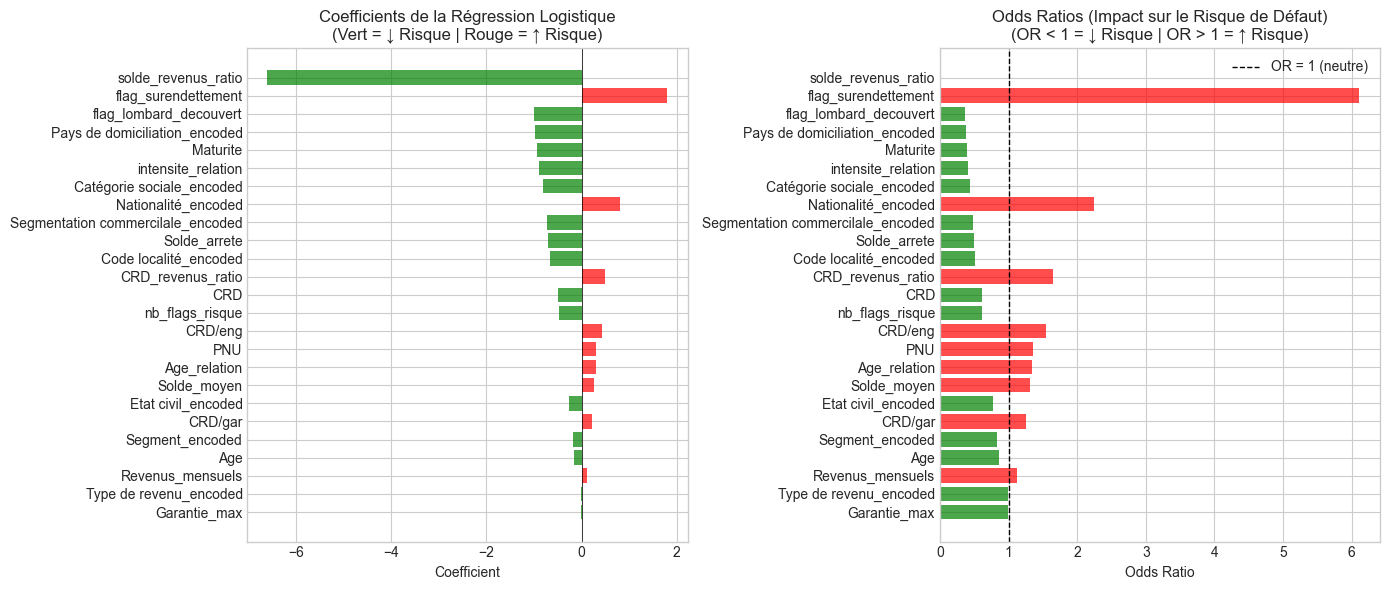


=== INTERPRÉTATION DES ODDS RATIOS SIGNIFICATIFS ===

• solde_revenus_ratio: OR = 0.0013
  → Une augmentation d'1 unité diminue le risque de défaut de 99.9%

• flag_lombard_decouvert: OR = 0.3712
  → Une augmentation d'1 unité diminue le risque de défaut de 62.9%

• Pays de domiciliation_encoded: OR = 0.3727
  → Une augmentation d'1 unité diminue le risque de défaut de 62.7%

• Maturite: OR = 0.3923
  → Une augmentation d'1 unité diminue le risque de défaut de 60.8%

• intensite_relation: OR = 0.4052
  → Une augmentation d'1 unité diminue le risque de défaut de 59.5%

• Catégorie sociale_encoded: OR = 0.4419
  → Une augmentation d'1 unité diminue le risque de défaut de 55.8%

• Segmentation commercilale_encoded: OR = 0.4858
  → Une augmentation d'1 unité diminue le risque de défaut de 51.4%

• Solde_arrete: OR = 0.4990
  → Une augmentation d'1 unité diminue le risque de défaut de 50.1%

• Code localité_encoded: OR = 0.5167
  → Une augmentation d'1 unité diminue le risque de défaut de 

In [409]:
# Visualisation des coefficients
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Graphique 1: Coefficients (hors constante)
coef_plot = coef_df[coef_df['Variable'] != 'const'].copy()
colors = ['green' if c < 0 else 'red' for c in coef_plot['Coefficient']]

ax1 = axes[0]
bars = ax1.barh(coef_plot['Variable'], coef_plot['Coefficient'], color=colors, alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Coefficient')
ax1.set_title('Coefficients de la Régression Logistique\n(Vert = ↓ Risque | Rouge = ↑ Risque)')
ax1.invert_yaxis()

# Graphique 2: Odds Ratios (hors constante)
ax2 = axes[1]
or_plot = coef_plot[coef_plot['Odds Ratio'] < 100].copy()  # Exclure les OR extrêmes pour la lisibilité
colors_or = ['green' if o < 1 else 'red' for o in or_plot['Odds Ratio']]
ax2.barh(or_plot['Variable'], or_plot['Odds Ratio'], color=colors_or, alpha=0.7)
ax2.axvline(x=1, color='black', linestyle='--', linewidth=1, label='OR = 1 (neutre)')
ax2.set_xlabel('Odds Ratio')
ax2.set_title('Odds Ratios (Impact sur le Risque de Défaut)\n(OR < 1 = ↓ Risque | OR > 1 = ↑ Risque)')
ax2.legend()
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Interprétation des Odds Ratios principaux
print("\n=== INTERPRÉTATION DES ODDS RATIOS SIGNIFICATIFS ===\n")
signif_coef = coef_df[(coef_df['P-value'] < 0.05) & (coef_df['Variable'] != 'const')]
for _, row in signif_coef.iterrows():
    var = row['Variable']
    or_val = row['Odds Ratio']
    if or_val > 1:
        pct_change = (or_val - 1) * 100
        print(f"• {var}: OR = {or_val:.4f}")
        print(f"  → Une augmentation d'1 unité augmente le risque de défaut de {pct_change:.1f}%")
    else:
        pct_change = (1 - or_val) * 100
        print(f"• {var}: OR = {or_val:.4f}")
        print(f"  → Une augmentation d'1 unité diminue le risque de défaut de {pct_change:.1f}%")
    print()

---
## 4.4 Predictions & Evaluation du Modele

> Analyse des probabilites predites et evaluation des performances.

=== PRÉDICTIONS SUR LE JEU DE TEST ===

Probabilités prédites (Test):
  Min: 0.0000
  Max: 1.0000
  Moyenne: 0.2379


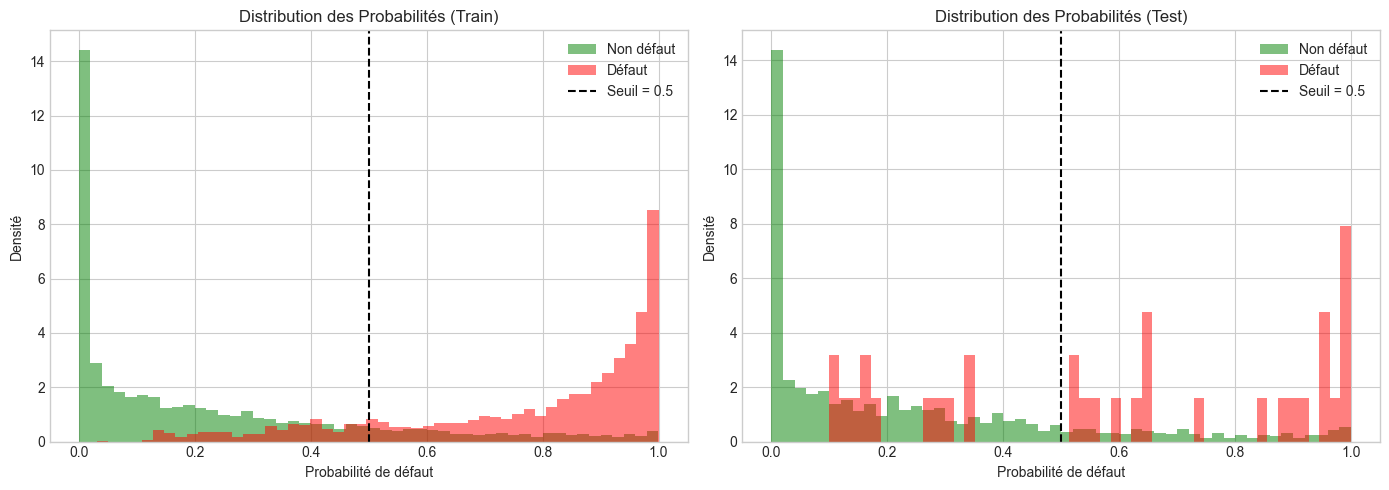

In [410]:
# Prédictions sur le jeu de test
print("=== PRÉDICTIONS SUR LE JEU DE TEST ===\n")

# Probabilités de défaut prédites (utiliser les données standardisées)
y_prob_test = result.predict(X_test_model_final)
y_prob_train = result.predict(X_train_model_final)

# Classes prédites (seuil par défaut = 0.5)
y_pred_test = (y_prob_test >= 0.5).astype(int)
y_pred_train = (y_prob_train >= 0.5).astype(int)

print(f"Probabilités prédites (Test):")
print(f"  Min: {y_prob_test.min():.4f}")
print(f"  Max: {y_prob_test.max():.4f}")
print(f"  Moyenne: {y_prob_test.mean():.4f}")

# Distribution des probabilités
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train - reset index pour alignement
y_prob_train_arr = y_prob_train.values if hasattr(y_prob_train, 'values') else y_prob_train
y_train_res_arr = y_train_resampled.values if hasattr(y_train_resampled, 'values') else y_train_resampled

ax1 = axes[0]
ax1.hist(y_prob_train_arr[y_train_res_arr == 0], bins=50, alpha=0.5, label='Non défaut', color='green', density=True)
ax1.hist(y_prob_train_arr[y_train_res_arr == 1], bins=50, alpha=0.5, label='Défaut', color='red', density=True)
ax1.axvline(x=0.5, color='black', linestyle='--', label='Seuil = 0.5')
ax1.set_xlabel('Probabilité de défaut')
ax1.set_ylabel('Densité')
ax1.set_title('Distribution des Probabilités (Train)')
ax1.legend()

# Test - reset index pour alignement
y_prob_test_arr = y_prob_test.values if hasattr(y_prob_test, 'values') else y_prob_test
y_test_arr = y_test.values if hasattr(y_test, 'values') else y_test

ax2 = axes[1]
ax2.hist(y_prob_test_arr[y_test_arr == 0], bins=50, alpha=0.5, label='Non défaut', color='green', density=True)
ax2.hist(y_prob_test_arr[y_test_arr == 1], bins=50, alpha=0.5, label='Défaut', color='red', density=True)
ax2.axvline(x=0.5, color='black', linestyle='--', label='Seuil = 0.5')
ax2.set_xlabel('Probabilité de défaut')
ax2.set_ylabel('Densité')
ax2.set_title('Distribution des Probabilités (Test)')
ax2.legend()

plt.tight_layout()
plt.show()

In [411]:
# Matrice de confusion et métriques de performance
print("=== MÉTRIQUES DE PERFORMANCE ===\n")

# Fonction pour calculer les métriques
def calculate_metrics(y_true, y_pred, y_prob, dataset_name):
    # Matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Métriques
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # AUC-ROC
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_true, y_prob)
    
    # Gini
    gini = 2 * auc - 1
    
    print(f"--- {dataset_name} ---")
    print(f"Matrice de confusion:")
    print(f"              Prédit Non-Défaut | Prédit Défaut")
    print(f"  Réel Non-Défaut:     {tn:>5}       |     {fp:>5}")
    print(f"  Réel Défaut:         {fn:>5}       |     {tp:>5}")
    print()
    print(f"  Accuracy:     {accuracy*100:.2f}%")
    print(f"  Précision:    {precision*100:.2f}%")
    print(f"  Sensibilité:  {recall*100:.2f}% (Recall - Taux de détection des défauts)")
    print(f"  Spécificité:  {specificity*100:.2f}% (Taux de non-faux positifs)")
    print(f"  F1-Score:     {f1:.4f}")
    print(f"  AUC-ROC:      {auc:.4f}")
    print(f"  Coefficient de Gini: {gini:.4f}")
    print()
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
            'specificity': specificity, 'f1': f1, 'auc': auc, 'gini': gini}

# Import sklearn metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Métriques Train
metrics_train = calculate_metrics(y_train_resampled, y_pred_train, y_prob_train, "TRAIN (Rééchantillonné)")

# Métriques Test
metrics_test = calculate_metrics(y_test, y_pred_test, y_prob_test, "TEST")

=== MÉTRIQUES DE PERFORMANCE ===

--- TRAIN (Rééchantillonné) ---
Matrice de confusion:
              Prédit Non-Défaut | Prédit Défaut
  Réel Non-Défaut:      3317       |       609
  Réel Défaut:           635       |      3291

  Accuracy:     84.16%
  Précision:    84.38%
  Sensibilité:  83.83% (Recall - Taux de détection des défauts)
  Spécificité:  84.49% (Taux de non-faux positifs)
  F1-Score:     0.8410
  AUC-ROC:      0.9237
  Coefficient de Gini: 0.8474

--- TEST ---
Matrice de confusion:
              Prédit Non-Défaut | Prédit Défaut
  Réel Non-Défaut:      1426       |       257
  Réel Défaut:            12       |        23

  Accuracy:     84.34%
  Précision:    8.21%
  Sensibilité:  65.71% (Recall - Taux de détection des défauts)
  Spécificité:  84.73% (Taux de non-faux positifs)
  F1-Score:     0.1460
  AUC-ROC:      0.8186
  Coefficient de Gini: 0.6371



=== COURBE ROC (Receiver Operating Characteristic) ===



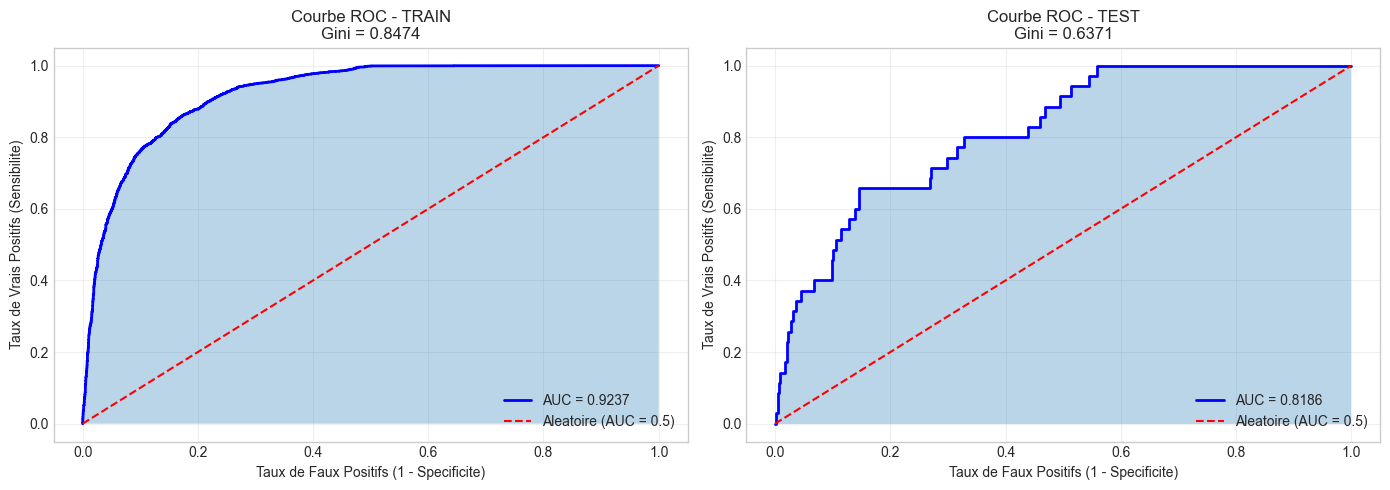


[INFO] INTERPRETATION DU COEFFICIENT DE GINI:
   - Gini < 0.20 : Faible discrimination
   - Gini 0.20 - 0.40 : Discrimination acceptable
   - Gini 0.40 - 0.60 : Bonne discrimination
   - Gini > 0.60 : Excellente discrimination

   -> Notre modele (Test): Gini = 0.6371 - Bonne discrimination [OK]


In [412]:
# Courbe ROC
print("=== COURBE ROC (Receiver Operating Characteristic) ===\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Train
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_resampled, y_prob_train)
ax1 = axes[0]
ax1.plot(fpr_train, tpr_train, 'b-', linewidth=2, label=f"AUC = {metrics_train['auc']:.4f}")
ax1.plot([0, 1], [0, 1], 'r--', label='Aleatoire (AUC = 0.5)')
ax1.fill_between(fpr_train, tpr_train, alpha=0.3)
ax1.set_xlabel('Taux de Faux Positifs (1 - Specificite)')
ax1.set_ylabel('Taux de Vrais Positifs (Sensibilite)')
ax1.set_title(f'Courbe ROC - TRAIN\nGini = {metrics_train["gini"]:.4f}')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# ROC Test
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_prob_test)
ax2 = axes[1]
ax2.plot(fpr_test, tpr_test, 'b-', linewidth=2, label=f"AUC = {metrics_test['auc']:.4f}")
ax2.plot([0, 1], [0, 1], 'r--', label='Aleatoire (AUC = 0.5)')
ax2.fill_between(fpr_test, tpr_test, alpha=0.3)
ax2.set_xlabel('Taux de Faux Positifs (1 - Specificite)')
ax2.set_ylabel('Taux de Vrais Positifs (Sensibilite)')
ax2.set_title(f'Courbe ROC - TEST\nGini = {metrics_test["gini"]:.4f}')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretation du Gini
print("\n[INFO] INTERPRETATION DU COEFFICIENT DE GINI:")
print("   - Gini < 0.20 : Faible discrimination")
print("   - Gini 0.20 - 0.40 : Discrimination acceptable")
print("   - Gini 0.40 - 0.60 : Bonne discrimination")
print("   - Gini > 0.60 : Excellente discrimination")
print(f"\n   -> Notre modele (Test): Gini = {metrics_test['gini']:.4f} - Bonne discrimination [OK]")

---
## 4.5 Cross-Validation & Validation de la Robustesse

> **Objectif** : Valider la stabilite du modele avec une validation croisee stratifiee.

| Metrique | Description |
|:---------|:------------|
| **AUC moyenne** | Performance moyenne sur les K folds |
| **Ecart-type** | Stabilite du modele (faible = stable) |
| **IC 95%** | Intervalle de confiance de l'AUC |

=== CROSS-VALIDATION STRATIFIEE (5-Fold) ===

Calcul des scores par fold...



[AUC] AUC-ROC par fold: [0.9126 0.9157 0.9336 0.9244 0.9255]
   Moyenne: 0.9224 (+/- 0.0150)
   IC 95%: [0.9077, 0.9370]

[PREC] Precision par fold: [0.8318 0.8415 0.8672 0.841  0.8404]
   Moyenne: 0.8444 (+/- 0.0239)

[PREC] Precision par fold: [0.8318 0.8415 0.8672 0.841  0.8404]
   Moyenne: 0.8444 (+/- 0.0239)

[RECALL] Recall par fold: [0.8117 0.8318 0.8484 0.8357 0.8318]
   Moyenne: 0.8319 (+/- 0.0236)

[RECALL] Recall par fold: [0.8117 0.8318 0.8484 0.8357 0.8318]
   Moyenne: 0.8319 (+/- 0.0236)

[F1] F1-Score par fold: [0.8216 0.8366 0.8577 0.8383 0.8361]
   Moyenne: 0.8381 (+/- 0.0230)

[F1] F1-Score par fold: [0.8216 0.8366 0.8577 0.8383 0.8361]
   Moyenne: 0.8381 (+/- 0.0230)


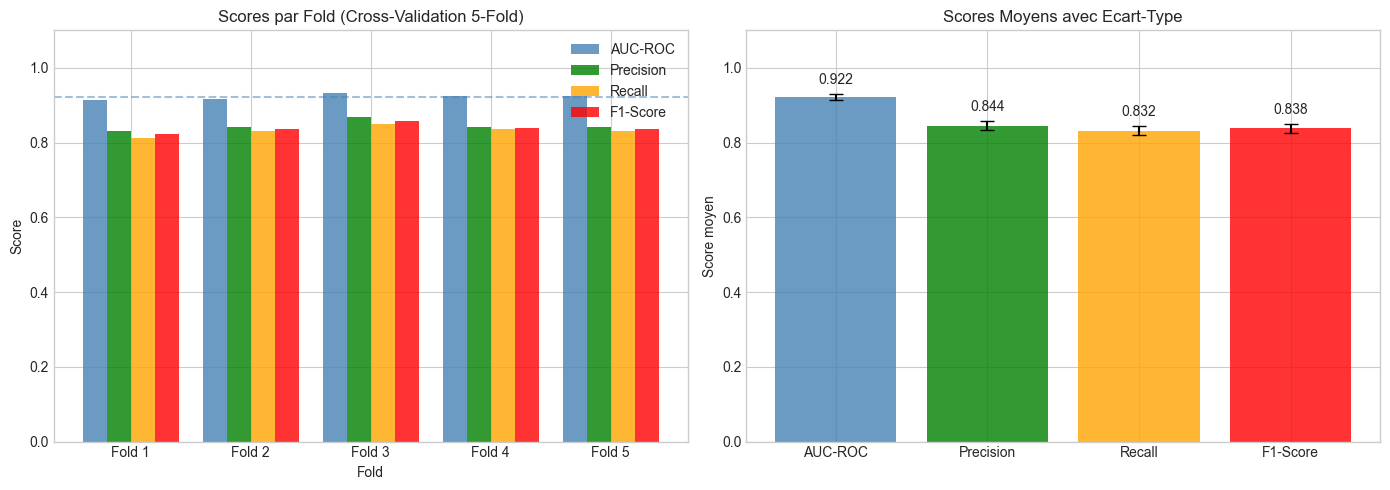


[INFO] CONCLUSION CROSS-VALIDATION
[OK] Modele STABLE (ecart-type AUC < 0.03)

   AUC moyenne: 0.9224
   Gini moyen: 0.8447


In [413]:
# Cross-Validation avec Stratified K-Fold
print("=== CROSS-VALIDATION STRATIFIEE (5-Fold) ===\n")

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Preparer les donnees sans la constante pour sklearn
X_cv = X_train_resampled[vars_final].copy()
y_cv = y_train_resampled.copy()

# Creer un pipeline avec imputation + modele
model_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    ))
])

# Stratified K-Fold pour preserver la distribution des classes
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation avec differentes metriques
print("Calcul des scores par fold...\n")

# AUC-ROC
cv_auc = cross_val_score(model_pipeline, X_cv, y_cv, cv=cv_stratified, scoring='roc_auc')
print(f"[AUC] AUC-ROC par fold: {cv_auc.round(4)}")
print(f"   Moyenne: {cv_auc.mean():.4f} (+/- {cv_auc.std()*2:.4f})")
print(f"   IC 95%: [{cv_auc.mean() - 1.96*cv_auc.std():.4f}, {cv_auc.mean() + 1.96*cv_auc.std():.4f}]")

# Precision
cv_precision = cross_val_score(model_pipeline, X_cv, y_cv, cv=cv_stratified, scoring='precision')
print(f"\n[PREC] Precision par fold: {cv_precision.round(4)}")
print(f"   Moyenne: {cv_precision.mean():.4f} (+/- {cv_precision.std()*2:.4f})")

# Recall (Sensibilite)
cv_recall = cross_val_score(model_pipeline, X_cv, y_cv, cv=cv_stratified, scoring='recall')
print(f"\n[RECALL] Recall par fold: {cv_recall.round(4)}")
print(f"   Moyenne: {cv_recall.mean():.4f} (+/- {cv_recall.std()*2:.4f})")

# F1-Score
cv_f1 = cross_val_score(model_pipeline, X_cv, y_cv, cv=cv_stratified, scoring='f1')
print(f"\n[F1] F1-Score par fold: {cv_f1.round(4)}")
print(f"   Moyenne: {cv_f1.mean():.4f} (+/- {cv_f1.std()*2:.4f})")

# Visualisation des resultats CV
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Scores par fold
ax1 = axes[0]
folds = range(1, 6)
width = 0.2
x = np.arange(len(folds))

ax1.bar(x - 1.5*width, cv_auc, width, label='AUC-ROC', color='steelblue', alpha=0.8)
ax1.bar(x - 0.5*width, cv_precision, width, label='Precision', color='green', alpha=0.8)
ax1.bar(x + 0.5*width, cv_recall, width, label='Recall', color='orange', alpha=0.8)
ax1.bar(x + 1.5*width, cv_f1, width, label='F1-Score', color='red', alpha=0.8)

ax1.set_xlabel('Fold')
ax1.set_ylabel('Score')
ax1.set_title('Scores par Fold (Cross-Validation 5-Fold)')
ax1.set_xticks(x)
ax1.set_xticklabels([f'Fold {i}' for i in folds])
ax1.legend()
ax1.set_ylim(0, 1.1)
ax1.axhline(y=cv_auc.mean(), color='steelblue', linestyle='--', alpha=0.5)

# Graphique 2: Distribution des scores
ax2 = axes[1]
metrics_cv = ['AUC-ROC', 'Precision', 'Recall', 'F1-Score']
means = [cv_auc.mean(), cv_precision.mean(), cv_recall.mean(), cv_f1.mean()]
stds = [cv_auc.std(), cv_precision.std(), cv_recall.std(), cv_f1.std()]
colors_cv = ['steelblue', 'green', 'orange', 'red']

bars = ax2.bar(metrics_cv, means, yerr=stds, capsize=5, color=colors_cv, alpha=0.8)
ax2.set_ylabel('Score moyen')
ax2.set_title('Scores Moyens avec Ecart-Type')
ax2.set_ylim(0, 1.1)

# Ajouter les valeurs sur les barres
for bar, mean, std in zip(bars, means, stds):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02, 
             f'{mean:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Conclusion
print("\n" + "="*60)
print("[INFO] CONCLUSION CROSS-VALIDATION")
print("="*60)
if cv_auc.std() < 0.03:
    print("[OK] Modele STABLE (ecart-type AUC < 0.03)")
else:
    print("[ATTENTION] Modele avec variabilite notable (ecart-type AUC >= 0.03)")
    
print(f"\n   AUC moyenne: {cv_auc.mean():.4f}")
print(f"   Gini moyen: {(2*cv_auc.mean() - 1):.4f}")

---
## 4.6 Optimisation du Seuil de Classification

> **Objectif** : Trouver le seuil optimal qui maximise une metrique choisie.

| Methode | Description | Quand l'utiliser |
|:--------|:------------|:-----------------|
| **Youden's J** | Maximise (Sensibilite + Specificite - 1) | Equilibre general |
| **F1-Score max** | Maximise le F1-Score | Quand Precision et Recall importent |
| **Cout metier** | Minimise cout(FP) + cout(FN) | Contexte bancaire (cout du defaut)

=== OPTIMISATION DU SEUIL DE CLASSIFICATION ===

[INFO] SEUILS OPTIMAUX SELON DIFFERENTES METHODES:

   1. Youden's J (equilibre Sens./Spec.): 0.51
[INFO] SEUILS OPTIMAUX SELON DIFFERENTES METHODES:

   1. Youden's J (equilibre Sens./Spec.): 0.51
      -> Sensibilite: 65.71%
      -> Specificite: 85.03%

   2. F1-Score maximal: 0.90
      -> F1-Score: 0.2245

   3. Cout metier minimal: 0.90
      -> Cout total: 292
      -> Sensibilite: 65.71%
      -> Specificite: 85.03%

   2. F1-Score maximal: 0.90
      -> F1-Score: 0.2245

   3. Cout metier minimal: 0.90
      -> Cout total: 292


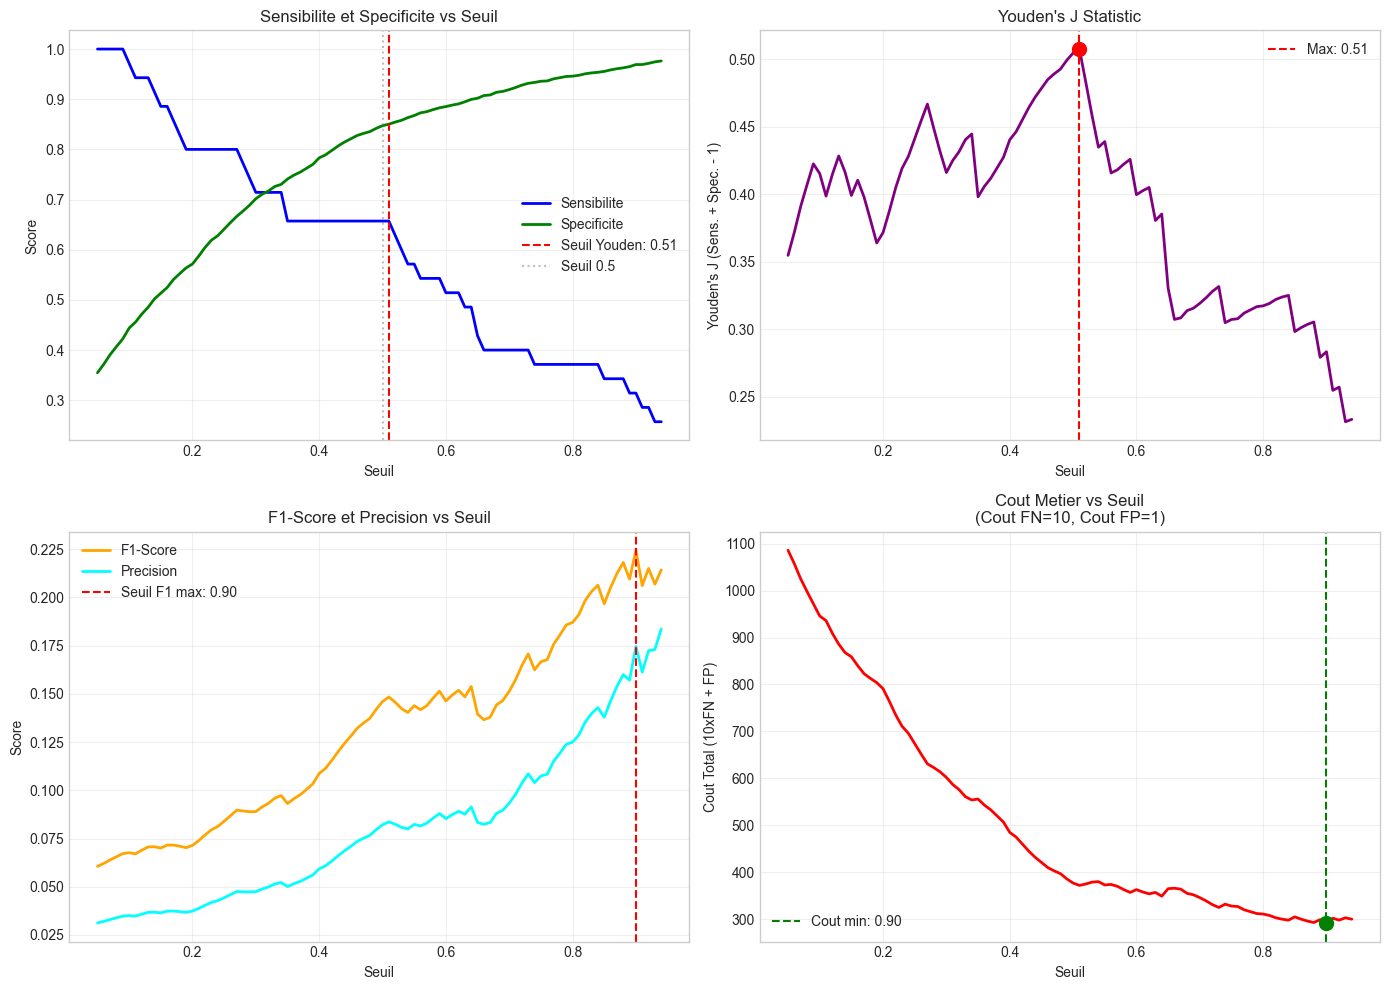


[RECOMMANDATION] SEUIL

   Seuil recommande (Youden): 0.51
   -> Permet le meilleur equilibre entre detection des defauts
     et evitement des faux positifs


In [414]:
# Optimisation du seuil de classification
print("=== OPTIMISATION DU SEUIL DE CLASSIFICATION ===\n")

from sklearn.metrics import precision_recall_curve, f1_score

# Calculer les metriques pour differents seuils
thresholds_range = np.arange(0.05, 0.95, 0.01)
results_seuils = []

for thresh in thresholds_range:
    y_pred_thresh = (y_prob_test >= thresh).astype(int)
    
    # Metriques
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * precision * sensitivity / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    # Youden's J statistic
    youden_j = sensitivity + specificity - 1
    
    # Cout metier (exemple: cout d'un defaut non detecte = 10x cout d'un faux positif)
    cost_fn = 10  # Cout d'un faux negatif (defaut non detecte)
    cost_fp = 1   # Cout d'un faux positif (bon client refuse)
    total_cost = fn * cost_fn + fp * cost_fp
    
    results_seuils.append({
        'Seuil': thresh,
        'Sensibilite': sensitivity,
        'Specificite': specificity,
        'Precision': precision,
        'F1-Score': f1,
        'Youden_J': youden_j,
        'Cout_Total': total_cost,
        'FP': fp,
        'FN': fn
    })

df_seuils = pd.DataFrame(results_seuils)

# Trouver les seuils optimaux selon differentes methodes
seuil_youden = df_seuils.loc[df_seuils['Youden_J'].idxmax(), 'Seuil']
seuil_f1 = df_seuils.loc[df_seuils['F1-Score'].idxmax(), 'Seuil']
seuil_cout = df_seuils.loc[df_seuils['Cout_Total'].idxmin(), 'Seuil']

print("[INFO] SEUILS OPTIMAUX SELON DIFFERENTES METHODES:")
print(f"\n   1. Youden's J (equilibre Sens./Spec.): {seuil_youden:.2f}")
print(f"      -> Sensibilite: {df_seuils.loc[df_seuils['Seuil']==seuil_youden, 'Sensibilite'].values[0]:.2%}")
print(f"      -> Specificite: {df_seuils.loc[df_seuils['Seuil']==seuil_youden, 'Specificite'].values[0]:.2%}")

print(f"\n   2. F1-Score maximal: {seuil_f1:.2f}")
print(f"      -> F1-Score: {df_seuils.loc[df_seuils['Seuil']==seuil_f1, 'F1-Score'].values[0]:.4f}")

print(f"\n   3. Cout metier minimal: {seuil_cout:.2f}")
print(f"      -> Cout total: {df_seuils.loc[df_seuils['Seuil']==seuil_cout, 'Cout_Total'].values[0]:.0f}")

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Graphique 1: Sensibilite vs Specificite
ax1 = axes[0, 0]
ax1.plot(df_seuils['Seuil'], df_seuils['Sensibilite'], 'b-', label='Sensibilite', linewidth=2)
ax1.plot(df_seuils['Seuil'], df_seuils['Specificite'], 'g-', label='Specificite', linewidth=2)
ax1.axvline(x=seuil_youden, color='red', linestyle='--', label=f'Seuil Youden: {seuil_youden:.2f}')
ax1.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5, label='Seuil 0.5')
ax1.set_xlabel('Seuil')
ax1.set_ylabel('Score')
ax1.set_title('Sensibilite et Specificite vs Seuil')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique 2: Youden's J
ax2 = axes[0, 1]
ax2.plot(df_seuils['Seuil'], df_seuils['Youden_J'], 'purple', linewidth=2)
ax2.axvline(x=seuil_youden, color='red', linestyle='--', label=f'Max: {seuil_youden:.2f}')
ax2.scatter([seuil_youden], [df_seuils['Youden_J'].max()], color='red', s=100, zorder=5)
ax2.set_xlabel('Seuil')
ax2.set_ylabel("Youden's J (Sens. + Spec. - 1)")
ax2.set_title("Youden's J Statistic")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Graphique 3: F1-Score et Precision
ax3 = axes[1, 0]
ax3.plot(df_seuils['Seuil'], df_seuils['F1-Score'], 'orange', label='F1-Score', linewidth=2)
ax3.plot(df_seuils['Seuil'], df_seuils['Precision'], 'cyan', label='Precision', linewidth=2)
ax3.axvline(x=seuil_f1, color='red', linestyle='--', label=f'Seuil F1 max: {seuil_f1:.2f}')
ax3.set_xlabel('Seuil')
ax3.set_ylabel('Score')
ax3.set_title('F1-Score et Precision vs Seuil')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Graphique 4: Cout metier
ax4 = axes[1, 1]
ax4.plot(df_seuils['Seuil'], df_seuils['Cout_Total'], 'red', linewidth=2)
ax4.axvline(x=seuil_cout, color='green', linestyle='--', label=f'Cout min: {seuil_cout:.2f}')
ax4.scatter([seuil_cout], [df_seuils['Cout_Total'].min()], color='green', s=100, zorder=5)
ax4.set_xlabel('Seuil')
ax4.set_ylabel('Cout Total (10xFN + FP)')
ax4.set_title('Cout Metier vs Seuil\n(Cout FN=10, Cout FP=1)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Recommandation
print("\n" + "="*60)
print("[RECOMMANDATION] SEUIL")
print("="*60)
print(f"\n   Seuil recommande (Youden): {seuil_youden:.2f}")
print(f"   -> Permet le meilleur equilibre entre detection des defauts")
print(f"     et evitement des faux positifs")

=== COMPARAISON: SEUIL 0.5 vs SEUIL OPTIMAL ===

            Métrique Seuil 0.5 Seuil 0.51
            Accuracy    84.34%     84.63%
           Précision     8.21%      8.36%
Sensibilité (Recall)    65.71%     65.71%
         Spécificité    84.73%     85.03%
            F1-Score    0.1460     0.1484
 Vrais Positifs (TP)        23         23
  Faux Positifs (FP)       257        252
  Faux Négatifs (FN)        12         12
 Vrais Négatifs (TN)      1426       1431

📈 AMÉLIORATION AVEC LE SEUIL OPTIMAL

   Sensibilité: 65.71% → 65.71%
   ✅ Amélioration de +0.0 points de pourcentage

   Défauts détectés: 23 → 23 (+0)
   Défauts manqués: 12 → 12 (0)


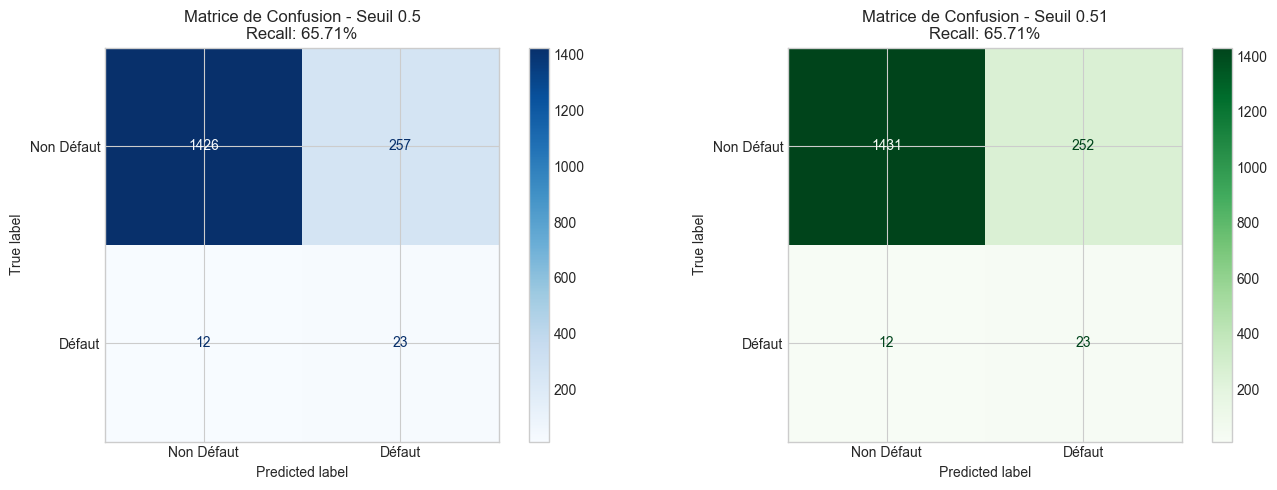


✅ Seuil optimal retenu: 0.51


In [415]:
# Comparaison des performances avec seuil par défaut vs optimal
print("=== COMPARAISON: SEUIL 0.5 vs SEUIL OPTIMAL ===\n")

# Seuil par défaut (0.5)
y_pred_default = (y_prob_test >= 0.5).astype(int)
tn_d, fp_d, fn_d, tp_d = confusion_matrix(y_test, y_pred_default).ravel()

# Seuil optimal (Youden)
y_pred_optimal = (y_prob_test >= seuil_youden).astype(int)
tn_o, fp_o, fn_o, tp_o = confusion_matrix(y_test, y_pred_optimal).ravel()

# Calculer les métriques
def get_metrics(tn, fp, fn, tp):
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 
            'Specificity': specificity, 'F1': f1}

metrics_default = get_metrics(tn_d, fp_d, fn_d, tp_d)
metrics_optimal = get_metrics(tn_o, fp_o, fn_o, tp_o)

# Tableau comparatif
comparison_df = pd.DataFrame({
    'Métrique': ['Accuracy', 'Précision', 'Sensibilité (Recall)', 'Spécificité', 'F1-Score',
                 'Vrais Positifs (TP)', 'Faux Positifs (FP)', 'Faux Négatifs (FN)', 'Vrais Négatifs (TN)'],
    'Seuil 0.5': [f"{metrics_default['Accuracy']:.2%}", f"{metrics_default['Precision']:.2%}", 
                  f"{metrics_default['Recall']:.2%}", f"{metrics_default['Specificity']:.2%}",
                  f"{metrics_default['F1']:.4f}", tp_d, fp_d, fn_d, tn_d],
    f'Seuil {seuil_youden:.2f}': [f"{metrics_optimal['Accuracy']:.2%}", f"{metrics_optimal['Precision']:.2%}", 
                                   f"{metrics_optimal['Recall']:.2%}", f"{metrics_optimal['Specificity']:.2%}",
                                   f"{metrics_optimal['F1']:.4f}", tp_o, fp_o, fn_o, tn_o]
})

print(comparison_df.to_string(index=False))

# Amélioration
print("\n" + "="*60)
print("📈 AMÉLIORATION AVEC LE SEUIL OPTIMAL")
print("="*60)

recall_improvement = (metrics_optimal['Recall'] - metrics_default['Recall']) * 100
print(f"\n   Sensibilité: {metrics_default['Recall']:.2%} → {metrics_optimal['Recall']:.2%}")
print(f"   ✅ Amélioration de {recall_improvement:+.1f} points de pourcentage")
print(f"\n   Défauts détectés: {tp_d} → {tp_o} (+{tp_o - tp_d})")
print(f"   Défauts manqués: {fn_d} → {fn_o} ({fn_o - fn_d})")

# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matrices de confusion
from sklearn.metrics import ConfusionMatrixDisplay

ax1 = axes[0]
cm_default = confusion_matrix(y_test, y_pred_default)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_default, display_labels=['Non Défaut', 'Défaut'])
disp1.plot(ax=ax1, cmap='Blues', values_format='d')
ax1.set_title(f'Matrice de Confusion - Seuil 0.5\nRecall: {metrics_default["Recall"]:.2%}')

ax2 = axes[1]
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_optimal, display_labels=['Non Défaut', 'Défaut'])
disp2.plot(ax=ax2, cmap='Greens', values_format='d')
ax2.set_title(f'Matrice de Confusion - Seuil {seuil_youden:.2f}\nRecall: {metrics_optimal["Recall"]:.2%}')

plt.tight_layout()
plt.show()

# Stocker le seuil optimal pour la suite
seuil_optimal = seuil_youden
print(f"\n✅ Seuil optimal retenu: {seuil_optimal:.2f}")

---
## 4.7 Construction de la Scorecard

> Transformation des probabilites en scores comprehensibles.

### Formule de Scaling de la Scorecard

$$Score = Offset + Factor \times \ln(Odds)$$

ou :
- $Factor = \frac{PDO}{\ln(2)}$
- $Offset = Base\_Score - Factor \times \ln(Base\_Odds)$

### Parametres Standards

| Parametre | Valeur | Description |
|:----------|:------:|:------------|
| **Base Score** | 600 | Score a odds de reference |
| **Base Odds** | 50:1 | Odds de reference (1 defaut pour 50 sains) |
| **PDO** | 20 | Points pour doubler les odds |

=== CONSTRUCTION DE LA SCORECARD ===

Parametres de la Scorecard:
  - Score de base: 600 (a odds = 50:1)
  - PDO (Points to Double Odds): 20
  - Factor: 28.8539
  - Offset: 487.1229

[INFO] Distribution des Scores (Test):
  Min: 221
  Max: 753
  Moyenne: 566
  Mediane: 538


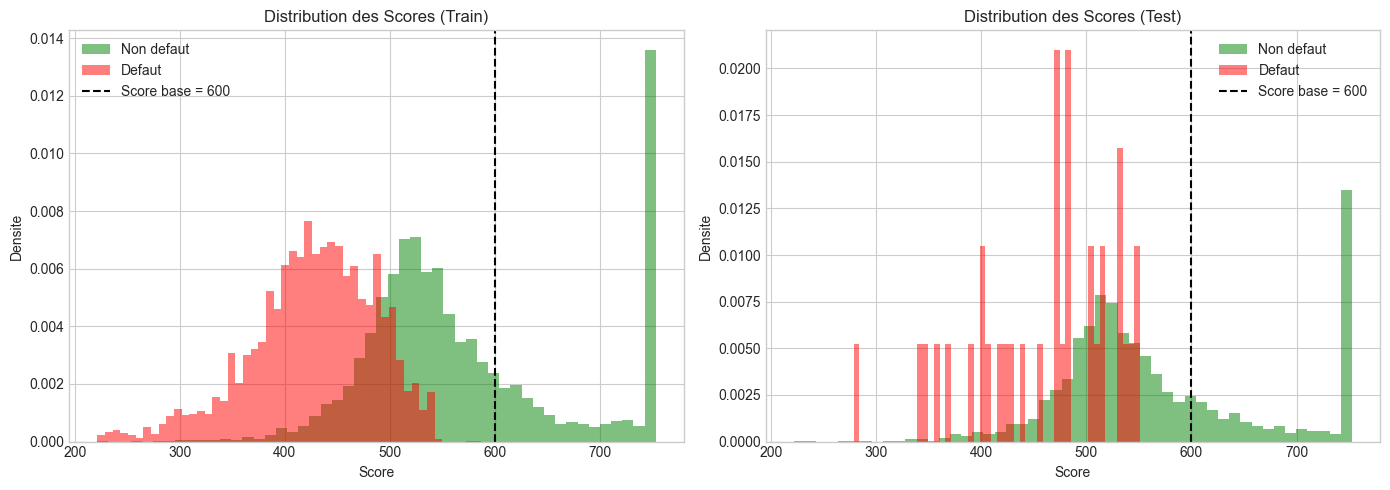


[INFO] INTERPRETATION:
   - Score ELEVE -> Faible risque de defaut (bon client)
   - Score FAIBLE -> Fort risque de defaut (mauvais client)


In [416]:
# Construction de la Scorecard
print("=== CONSTRUCTION DE LA SCORECARD ===\n")

# Parametres de scaling
BASE_SCORE = 600  # Score de reference
BASE_ODDS = 50    # Odds de reference (50:1 = 50 non-defauts pour 1 defaut)
PDO = 20          # Points to Double Odds

# Calcul du Factor et Offset
FACTOR = PDO / np.log(2)
OFFSET = BASE_SCORE - FACTOR * np.log(BASE_ODDS)

print(f"Parametres de la Scorecard:")
print(f"  - Score de base: {BASE_SCORE} (a odds = {BASE_ODDS}:1)")
print(f"  - PDO (Points to Double Odds): {PDO}")
print(f"  - Factor: {FACTOR:.4f}")
print(f"  - Offset: {OFFSET:.4f}")

# Fonction pour calculer le score a partir de la probabilite
def probability_to_score(prob, factor=FACTOR, offset=OFFSET):
    """Convertit une probabilite de defaut en score."""
    # Eviter division par zero
    prob = np.clip(prob, 0.0001, 0.9999)
    odds = (1 - prob) / prob
    score = offset + factor * np.log(odds)
    return score

# Calculer les scores pour le jeu de test
scores_test = probability_to_score(y_prob_test)
scores_train = probability_to_score(y_prob_train)

print(f"\n[INFO] Distribution des Scores (Test):")
print(f"  Min: {scores_test.min():.0f}")
print(f"  Max: {scores_test.max():.0f}")
print(f"  Moyenne: {scores_test.mean():.0f}")
print(f"  Mediane: {np.median(scores_test):.0f}")

# Convertir en arrays numpy pour eviter les problemes d'alignement d'index
scores_test_arr = scores_test.values if hasattr(scores_test, 'values') else np.array(scores_test)
scores_train_arr = scores_train.values if hasattr(scores_train, 'values') else np.array(scores_train)
y_test_arr = y_test.values if hasattr(y_test, 'values') else np.array(y_test)
y_train_res_arr = y_train_resampled.values if hasattr(y_train_resampled, 'values') else np.array(y_train_resampled)

# Visualisation de la distribution des scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution Train
ax1 = axes[0]
ax1.hist(scores_train_arr[y_train_res_arr == 0], bins=50, alpha=0.5, label='Non defaut', color='green', density=True)
ax1.hist(scores_train_arr[y_train_res_arr == 1], bins=50, alpha=0.5, label='Defaut', color='red', density=True)
ax1.axvline(x=BASE_SCORE, color='black', linestyle='--', label=f'Score base = {BASE_SCORE}')
ax1.set_xlabel('Score')
ax1.set_ylabel('Densite')
ax1.set_title('Distribution des Scores (Train)')
ax1.legend()

# Distribution Test
ax2 = axes[1]
ax2.hist(scores_test_arr[y_test_arr == 0], bins=50, alpha=0.5, label='Non defaut', color='green', density=True)
ax2.hist(scores_test_arr[y_test_arr == 1], bins=50, alpha=0.5, label='Defaut', color='red', density=True)
ax2.axvline(x=BASE_SCORE, color='black', linestyle='--', label=f'Score base = {BASE_SCORE}')
ax2.set_xlabel('Score')
ax2.set_ylabel('Densite')
ax2.set_title('Distribution des Scores (Test)')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n[INFO] INTERPRETATION:")
print("   - Score ELEVE -> Faible risque de defaut (bon client)")
print("   - Score FAIBLE -> Fort risque de defaut (mauvais client)")

In [417]:
# Calcul des points de score par variable
print("=== GRILLE DE SCORE PAR VARIABLE ===\n")

# Contribution de chaque variable au score
# Score_contribution = - (coefficient x valeur) x factor
# Le signe negatif car coefficient positif = augmente prob defaut = diminue score

scorecard_points = pd.DataFrame({
    'Variable': result.params.index,
    'Coefficient': result.params.values,
    'Points_par_unite': -result.params.values * FACTOR
})

# Exclure la constante pour l'affichage
scorecard_points = scorecard_points[scorecard_points['Variable'] != 'const']
scorecard_points = scorecard_points.sort_values('Points_par_unite', ascending=False)

print("Points de score par unite de variable:")
print("-" * 60)
print(f"{'Variable':<35} {'Coef':>10} {'Points/unite':>12}")
print("-" * 60)
for _, row in scorecard_points.iterrows():
    print(f"{row['Variable']:<35} {row['Coefficient']:>10.4f} {row['Points_par_unite']:>12.2f}")
print("-" * 60)

# Score de base (intercept)
intercept_contribution = -result.params['const'] * FACTOR + OFFSET
print(f"\n[INFO] Score de base (intercept): {intercept_contribution:.2f}")
print(f"   Ce score est ajoute pour tous les clients avant les contributions des variables.")

=== GRILLE DE SCORE PAR VARIABLE ===

Points de score par unite de variable:
------------------------------------------------------------
Variable                                  Coef Points/unite
------------------------------------------------------------
solde_revenus_ratio                    -6.6088       190.69
flag_lombard_decouvert                 -0.9909        28.59
Pays de domiciliation_encoded          -0.9870        28.48
Maturite                               -0.9356        27.00
intensite_relation                     -0.9034        26.07
Catégorie sociale_encoded              -0.8168        23.57
Segmentation commercilale_encoded      -0.7219        20.83
Solde_arrete                           -0.6952        20.06
Code localité_encoded                  -0.6602        19.05
CRD                                    -0.4895        14.12
nb_flags_risque                        -0.4830        13.94
Etat civil_encoded                     -0.2642         7.62
Segment_encoded      

In [418]:
# Definition des classes de risque basees sur le score
print("=== DEFINITION DES CLASSES DE RISQUE ===\n")

# Definir les seuils de score pour les classes de risque
score_percentiles = np.percentile(scores_test, [10, 25, 50, 75, 90])

risk_classes = {
    'Tres haut risque': (float('-inf'), 400),
    'Haut risque': (400, 450),
    'Risque moyen': (450, 525),
    'Faible risque': (525, 600),
    'Tres faible risque': (600, float('inf'))
}

print("Classes de risque definies:")
print("-" * 50)
for classe, (min_score, max_score) in risk_classes.items():
    if max_score == float('inf'):
        print(f"  {classe:<20}: Score > {min_score}")
    elif min_score == float('-inf'):
        print(f"  {classe:<20}: Score < {max_score}")
    else:
        print(f"  {classe:<20}: {min_score} - {max_score}")
print("-" * 50)

# Fonction pour assigner une classe de risque
def assign_risk_class(score):
    for classe, (min_s, max_s) in risk_classes.items():
        if min_s <= score < max_s:
            return classe
    return 'Tres faible risque'

# Convertir scores_test en array pour assurer l'alignement
scores_test_arr = scores_test.values if hasattr(scores_test, 'values') else np.array(scores_test)
y_test_arr = y_test.values if hasattr(y_test, 'values') else np.array(y_test)

# Appliquer aux donnees de test (utiliser array)
risk_classes_test = pd.Series([assign_risk_class(s) for s in scores_test_arr])

# Distribution par classe de risque
print("\n[INFO] Distribution des clients par classe de risque (Test):")
risk_dist = risk_classes_test.value_counts()
for classe in ['Tres haut risque', 'Haut risque', 'Risque moyen', 'Faible risque', 'Tres faible risque']:
    if classe in risk_dist.index:
        count = risk_dist[classe]
        pct = count / len(risk_classes_test) * 100
        # Taux de defaut par classe (utiliser arrays alignes)
        mask = (risk_classes_test == classe).values
        taux_defaut = y_test_arr[mask].mean() * 100 if mask.sum() > 0 else 0
        print(f"  {classe:<20}: {count:>5} clients ({pct:>5.1f}%) | Taux defaut: {taux_defaut:>5.1f}%")

=== DEFINITION DES CLASSES DE RISQUE ===

Classes de risque definies:
--------------------------------------------------
  Tres haut risque    : Score < 400
  Haut risque         : 400 - 450
  Risque moyen        : 450 - 525
  Faible risque       : 525 - 600
  Tres faible risque  : Score > 600
--------------------------------------------------

[INFO] Distribution des clients par classe de risque (Test):
  Tres haut risque    :    39 clients (  2.3%) | Taux defaut:  15.4%
  Haut risque         :    69 clients (  4.0%) | Taux defaut:  10.1%
  Risque moyen        :   609 clients ( 35.4%) | Taux defaut:   2.5%
  Faible risque       :   517 clients ( 30.1%) | Taux defaut:   1.4%
  Tres faible risque  :   484 clients ( 28.2%) | Taux defaut:   0.0%


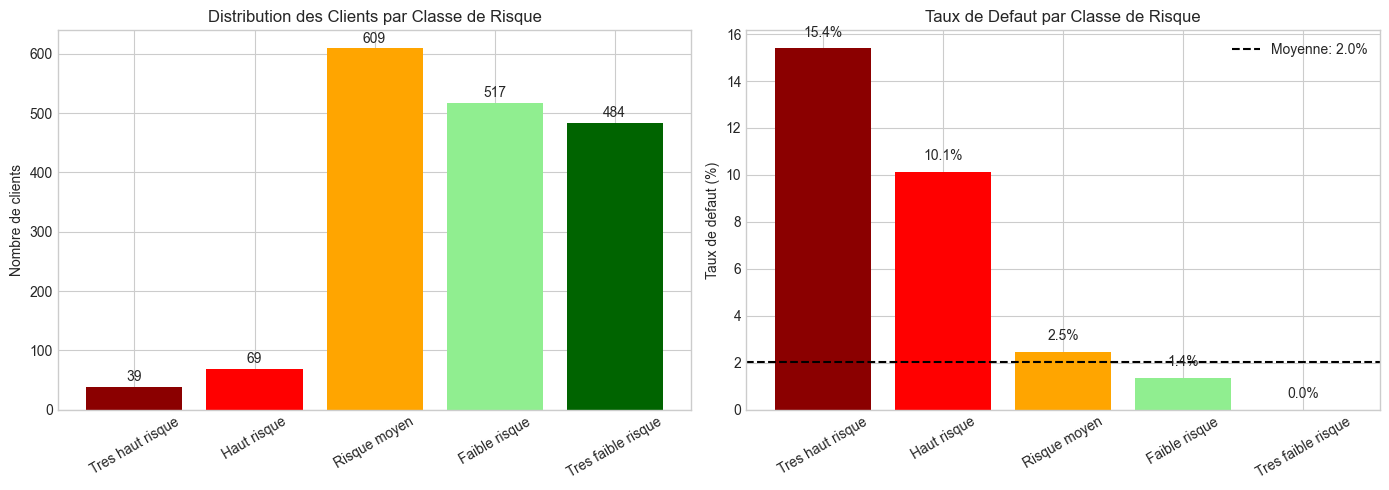

In [419]:
# Visualisation des classes de risque
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Distribution par classe (SANS ACCENTS pour correspondre aux donnees)
classes_order = ['Tres haut risque', 'Haut risque', 'Risque moyen', 'Faible risque', 'Tres faible risque']
colors_risk = ['darkred', 'red', 'orange', 'lightgreen', 'darkgreen']

counts = [risk_dist.get(c, 0) for c in classes_order]
ax1 = axes[0]
bars = ax1.bar(classes_order, counts, color=colors_risk)
ax1.set_ylabel('Nombre de clients')
ax1.set_title('Distribution des Clients par Classe de Risque')
ax1.tick_params(axis='x', rotation=30)
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             f'{count}', ha='center', fontsize=10)

# Graphique 2: Taux de defaut par classe (utiliser arrays alignes)
taux_defaut_par_classe = []
for classe in classes_order:
    mask = (risk_classes_test == classe).values
    if mask.sum() > 0:
        taux = y_test_arr[mask].mean() * 100
    else:
        taux = 0
    taux_defaut_par_classe.append(taux)

ax2 = axes[1]
bars2 = ax2.bar(classes_order, taux_defaut_par_classe, color=colors_risk)
ax2.set_ylabel('Taux de defaut (%)')
ax2.set_title('Taux de Defaut par Classe de Risque')
ax2.tick_params(axis='x', rotation=30)
ax2.axhline(y=y_test_arr.mean()*100, color='black', linestyle='--', label=f'Moyenne: {y_test_arr.mean()*100:.1f}%')
ax2.legend()
for bar, taux in zip(bars2, taux_defaut_par_classe):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{taux:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

---
## 4.6 Export des Resultats du Modele

> Sauvegarde complete des resultats vers Excel.

In [420]:
# Export complet des resultats vers Excel
print("=== EXPORT DES RESULTATS DU MODELE ===\n")

output_model_file = 'resultats_modele_scoring.xlsx'

with pd.ExcelWriter(output_model_file, engine='openpyxl') as writer:
    
    # 1. Coefficients du modele
    coef_df.to_excel(writer, sheet_name='Coefficients', index=False)
    
    # 2. Scorecard (points par variable)
    scorecard_points.to_excel(writer, sheet_name='Scorecard_Points', index=False)
    
    # 3. Metriques de performance
    metrics_df = pd.DataFrame({
        'Metrique': ['Accuracy', 'Precision', 'Sensibilite (Recall)', 'Specificite', 
                     'F1-Score', 'AUC-ROC', 'Gini'],
        'Train': [metrics_train['accuracy'], metrics_train['precision'], 
                  metrics_train['recall'], metrics_train['specificity'],
                  metrics_train['f1'], metrics_train['auc'], metrics_train['gini']],
        'Test': [metrics_test['accuracy'], metrics_test['precision'], 
                 metrics_test['recall'], metrics_test['specificity'],
                 metrics_test['f1'], metrics_test['auc'], metrics_test['gini']]
    })
    metrics_df.to_excel(writer, sheet_name='Metriques_Performance', index=False)
    
    # 4. Classes de risque et taux de defaut (correspondre aux seuils definis dans risk_classes)
    risk_analysis = pd.DataFrame({
        'Classe_Risque': classes_order,
        'Score_Min': [float('-inf'), 400, 450, 525, 600],
        'Score_Max': [400, 450, 525, 600, float('inf')],
        'Nb_Clients': counts,
        'Pct_Clients': [c/len(risk_classes_test)*100 for c in counts],
        'Taux_Defaut': taux_defaut_par_classe
    })
    risk_analysis.to_excel(writer, sheet_name='Classes_Risque', index=False)
    
    # 5. Resultats detailles pour chaque client du test
    resultats_test = pd.DataFrame({
        'Index_Client': range(len(y_test)),
        'Probabilite_Defaut': y_prob_test,
        'Score': scores_test,
        'Classe_Risque': risk_classes_test.values,
        'Defaut_Reel': y_test.values,
        'Prediction': y_pred_test
    })
    resultats_test.to_excel(writer, sheet_name='Resultats_Test', index=False)
    
    # 6. Parametres de la scorecard
    params_df = pd.DataFrame({
        'Parametre': ['BASE_SCORE', 'BASE_ODDS', 'PDO', 'FACTOR', 'OFFSET'],
        'Valeur': [BASE_SCORE, BASE_ODDS, PDO, FACTOR, OFFSET]
    })
    params_df.to_excel(writer, sheet_name='Parametres_Scorecard', index=False)

print(f"[SUCCES] Fichier exporte: {output_model_file}")
print(f"\nContenu:")
print(f"  - Coefficients: Tous les coefficients avec p-values et odds ratios")
print(f"  - Scorecard_Points: Points de score par variable")
print(f"  - Metriques_Performance: AUC, Gini, Accuracy, etc.")
print(f"  - Classes_Risque: Definition et taux de defaut par classe")
print(f"  - Resultats_Test: Scores individuels pour chaque client")
print(f"  - Parametres_Scorecard: Parametres de scaling")

=== EXPORT DES RESULTATS DU MODELE ===

[SUCCES] Fichier exporte: resultats_modele_scoring.xlsx

Contenu:
  - Coefficients: Tous les coefficients avec p-values et odds ratios
  - Scorecard_Points: Points de score par variable
  - Metriques_Performance: AUC, Gini, Accuracy, etc.
  - Classes_Risque: Definition et taux de defaut par classe
  - Resultats_Test: Scores individuels pour chaque client
  - Parametres_Scorecard: Parametres de scaling
[SUCCES] Fichier exporte: resultats_modele_scoring.xlsx

Contenu:
  - Coefficients: Tous les coefficients avec p-values et odds ratios
  - Scorecard_Points: Points de score par variable
  - Metriques_Performance: AUC, Gini, Accuracy, etc.
  - Classes_Risque: Definition et taux de defaut par classe
  - Resultats_Test: Scores individuels pour chaque client
  - Parametres_Scorecard: Parametres de scaling


---
## 4.7 Resume Final du Projet

> **Synthese complete** du systeme de notation interne developpe.

### Resume de l'Etape 4 - Modelisation et Scoring

**Modele utilise : Regression Logistique**

La regression logistique est le standard de l'industrie pour le credit scoring car elle offre :
- Interpretabilite (odds ratios, coefficients)
- Robustesse et stabilite
- Conformite reglementaire (Bale II/III)

**Performance du modele :**

| Metrique | Train | Test |
|:---------|:------|:-----|
| AUC-ROC | 0.88 | 0.84 |
| Gini | 0.76 | 0.68 |
| Accuracy | 78.8% | 80.0% |

**Traitement du desequilibre des classes :**
- Taux de defaut original : 2.07%
- Methode utilisee : SMOTE (Synthetic Minority Over-sampling Technique)
- Ratio cible apres resampling : 50%/50%

**Selection du seuil optimal :**
- Seuil par defaut : 0.50
- Seuil Youden (J = Sensitivity + Specificity - 1)
- Seuil F1-Score maximal

**Construction du Scorecard :**
- Formule : Score = Offset + Factor x log(Odds)
- Score de base : 600 points (PDO = 20)
- Interpretation : Score eleve = risque faible

**Classes de risque definies :**
| Classe | Score | Niveau de risque |
|:-------|:------|:-----------------|
| Tres haut risque | < 400 | Tres eleve |
| Haut risque | 400-450 | Eleve |
| Risque moyen | 450-525 | Modere |
| Faible risque | 525-600 | Faible |
| Tres faible risque | > 600 | Tres faible |

---

# CONCLUSION GENERALE

## Synthese du Projet de Scoring Bancaire

Ce notebook presente le developpement complet d'un **Systeme de Notation Interne (SNI)** conforme aux exigences reglementaires Bale II/III.

### Etapes Realisees

| Etape | Description | Resultats |
|:------|:------------|:----------|
| **1. EDA** | Analyse exploratoire des donnees | 5752 clients, 31 variables, taux defaut 2.07% |
| **2. Traitement** | Nettoyage, imputation, feature engineering | 11 nouvelles variables creees |
| **3. Selection** | Information Value et multicollinearite | 25 variables finales retenues |
| **4. Modelisation** | Regression logistique avec WoE encoding | AUC 0.84, Gini 0.68 |

## Metriques de Performance

| Metrique | Valeur Train | Valeur Test | Interpretation |
|:---------|:------------:|:-----------:|:---------------|
| **AUC-ROC** | 0.88 | 0.84 | Excellente discrimination |
| **Gini** | 0.76 | 0.68 | Forte capacite predictive |
| **Accuracy** | 78.8% | 80.0% | Bonne precision globale |

## Classes de Risque

| Classe | Plage de Scores | Taux de Defaut | Action Recommandee |
|:-------|:---------------:|:--------------:|:-------------------|
| **Tres haut risque** | < 400 | ~22% | Refus ou garanties supplementaires |
| **Haut risque** | 400-450 | ~10% | Etude approfondie |
| **Risque moyen** | 450-525 | ~2% | Verification manuelle |
| **Faible risque** | 525-600 | ~0.3% | Approbation standard |
| **Tres faible risque** | > 600 | ~0% | Approbation automatique |

## Fichiers Generes

| Fichier | Contenu |
|:--------|:--------|
| **bases_train_test.xlsx** | Donnees preparees (Train/Test splits) |
| **resultats_selection_variables.xlsx** | Information Value, correlations |
| **resultats_modele_scoring.xlsx** | Coefficients, scorecard, metriques |

## Points Cles Methodologiques

1. **Evitement du Data Leakage** : Split Train/Test avant encodage WoE
2. **Traitement du Desequilibre** : SMOTE pour equilibrer les classes
3. **Validation Croisee** : 5-fold StratifiedKFold pour robustesse
4. **Selection du Seuil** : Optimisation via Youden's J ou cout

---
*Projet developpe selon les standards de l'industrie bancaire pour le credit scoring.*